# Estimation and Filtering

## Imports and Load Data

In [114]:
# Imports
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
from importlib import reload
from scipy.stats import zscore
import scipy.io
import gget
import scipy
import textwrap
from scipy import sparse
import importlib

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 3

# Controls/filtering
# !pip install filterpy
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

# working with MATLAB
import mat73

# local imports
sys.path.append("../python/")

import nb_util as nb
reload(nb)

import utils as ut
reload(ut)

import hasnain_DMD
reload(hasnain_DMD)

import sensorSelection
reload(sensorSelection)

def getC(n, idxs):
    C = np.zeros((len(idxs), n))
    for i in range(len(idxs)):
        C[i, int(idxs[i])] = 1
    return C

def wrap_ylabels(ax, width):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=False))
    ax.set_yticklabels(labels, rotation=0)

In [2]:
# 2015 data
data_path_2015 = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/countMatrix/counts.raw.txt"
gene_path_2015 = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/references/geneTable.csv"

# 2018 data
data_path_2018 = f"/nfs/turbo/umms-indikar/shared/projects/myod/data/rnaseq/2018_rna/countMatrix/counts.raw.txt"
gene_path_2018 = f"/nfs/turbo/umms-indikar/shared/projects/myod/data/rnaseq/2018_rna/references/geneTable.csv"

# Load the raw expression
df_2015 = pd.read_csv(data_path_2015, index_col=0)
df_2018 = pd.read_csv(data_path_2018, index_col=0)

# remove MT and ribosomal genes
all_genes_2015 = df_2015.index.to_list()
all_genes_2018 = df_2018.index.to_list()
mt_genes_2015 = [x for x in all_genes_2015 if x.startswith('MT-')]
rp_genes_2015 = [x for x in all_genes_2015 if x.startswith('RP')]
mt_genes_2018 = [x for x in all_genes_2018 if x.startswith('MT-')]
rp_genes_2018 = [x for x in all_genes_2018 if x.startswith('RP')]
df_2015 = df_2015.drop(mt_genes_2015) # drop MT genes
df_2015 = df_2015.drop(rp_genes_2015) # drop ribosomal genes
df_2018 = df_2018.drop(mt_genes_2018) # drop MT genes
df_2018 = df_2018.drop(rp_genes_2018) # drop ribosomal genes

# rewrite the list for removed genes
gene_names_2015 = df_2015.index.to_list()
gene_names_2018 = df_2018.index.to_list()

# Load gene lengths
gf_2015 = nb.getGeneLengths(gene_path_2015, gene_names_2015)
gf_2018 = nb.getGeneLengths(gene_path_2018, gene_names_2018)

# Convert to TPM
tpm_2015 = nb.TPM(df_2015, gf_2015)
tpm_2018 = nb.TPM(df_2018, gf_2018)

print(tpm_2015.shape)
print(tpm_2018.shape)

/home/jpic/DMD_gene/notebooks/nb_util.py:113: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gf = pd.read_csv(gene_table_path)
/home/jpic/DMD_gene/notebooks/nb_util.py:113: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gf = pd.read_csv(gene_table_path)


(19235, 18)
(19235, 48)


### System Output

In [3]:
sensorGenes = ['PCNA','CDT1','GEM']
output = tpm_2015[(tpm_2015.index == sensorGenes[0]) | 
                  (tpm_2015.index == sensorGenes[1]) | 
                  (tpm_2015.index == sensorGenes[2])]
outputSignals = nb.data2DMD(output, rescale=False)
print(outputSignals.shape)

(3, 8, 2)


Text(0, 0.5, 'PCNA')

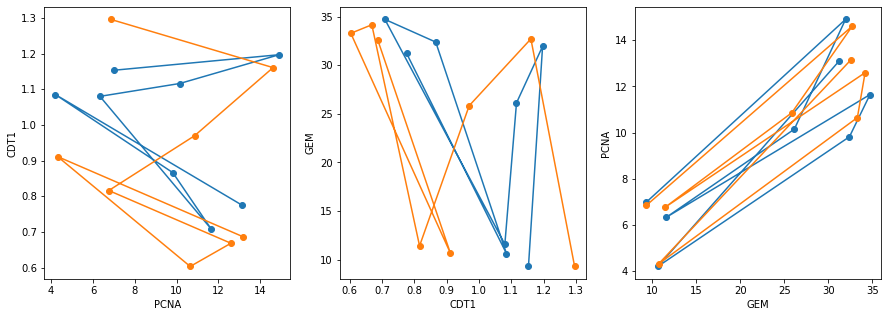

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(outputSignals[0,:,0],outputSignals[1,:,0], '-o')
axes[0].plot(outputSignals[0,:,1],outputSignals[1,:,1], '-o')
axes[0].set_xlabel('PCNA')
axes[0].set_ylabel('CDT1')

axes[1].plot(outputSignals[1,:,0],outputSignals[2,:,0], '-o')
axes[1].plot(outputSignals[1,:,1],outputSignals[2,:,1], '-o')
axes[1].set_xlabel('CDT1')
axes[1].set_ylabel('GEM')

axes[2].plot(outputSignals[2,:,0],outputSignals[0,:,0], '-o')
axes[2].plot(outputSignals[2,:,1],outputSignals[0,:,1], '-o')
axes[2].set_xlabel('GEM')
axes[2].set_ylabel('PCNA')


Text(0.5, 0, 'Time (hours)')

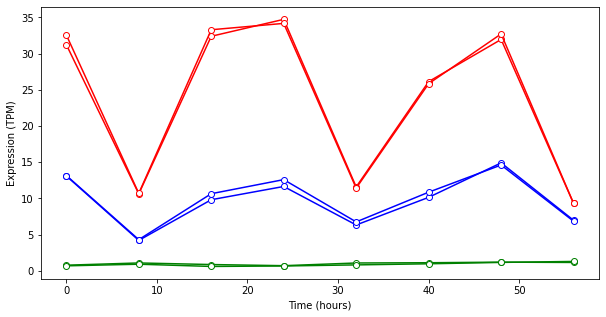

In [5]:
xrange = 8 * np.array(range(8))
plt.figure(figsize=(10,5))
plt.plot(xrange, outputSignals[0,:,0], '-o', color='blue', markerfacecolor='white')
plt.plot(xrange, outputSignals[0,:,1], '-o', color='blue', markerfacecolor='white')
plt.plot(xrange, outputSignals[1,:,0], '-o', color='green', markerfacecolor='white')
plt.plot(xrange, outputSignals[1,:,1], '-o', color='green', markerfacecolor='white')
plt.plot(xrange, outputSignals[2,:,0], '-o', color='red', markerfacecolor='white')
plt.plot(xrange, outputSignals[2,:,1], '-o', color='red', markerfacecolor='white')

plt.ylabel('Expression (TPM)')
plt.xlabel('Time (hours)')

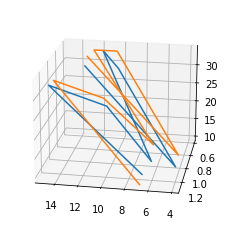

In [6]:
# visualize the output
outputSignals
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(outputSignals[0,:,0],outputSignals[1,:,0],outputSignals[2,:,0])
ax.plot(outputSignals[0,:,1],outputSignals[1,:,1],outputSignals[2,:,1])
ax.view_init(elev=20, azim=100)
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.zlabel('Z')
plt.show()

## Kalman Filtering Intro

In [7]:
import control as ct
from control.matlab import *

In [8]:
for gene in gene_names_2015:
    if gene in ['A1BG']: continue
    sensorGenes = ['PCNA','CDT1','GEM']
    # targetGenes = ['A1BG', gene]
    targetGenes = ['AGTPBP1','ARHGDIB', 'ATG10', 'ATG7', 'CABLES1', 'CCDC12', 'CCDC88C', 'CLEC16A', 'CNTRL']
    # targetGenes = ["AAK1", 'RNF220', 'UBXN8', 'TEAD3', 'SEC22A', 'MMP2'] #,"CCND1","CCND2","CCND3","CDK4","CDK6","RB1","RBL1","RBL2","E2F4","E2F1","E2F2","E2F3","E2F4","E2F5"]
    genes = sensorGenes + targetGenes

    # Subset the data and convert to DMD format
    output = tpm_2015[tpm_2015.index.isin(genes)]
    trajectory = nb.data2DMD(output, rescale=False)
    #print(trajectory.shape)
    dmd_res = hasnain_DMD.dmd(trajectory, rank=7)
    A = dmd_res['A']
    #print(dmd_res['A'].shape)
    #print(len(genes))
    C = getC(A.shape[0], [0,1,2])
    #print(C.shape)
    O = obsv(A, C)
    r = np.linalg.matrix_rank(O, tol=1e-20)
    if r == C.shape[1]:
        print('Observable')
        print(gene)
        break
    else:
        print(r)
        break
    #else:
        #print(r)
        #print(C.shape[1])
        #print('NOT OBSERVABLE')
    #print(O.shape)
    

Observable
A1CF


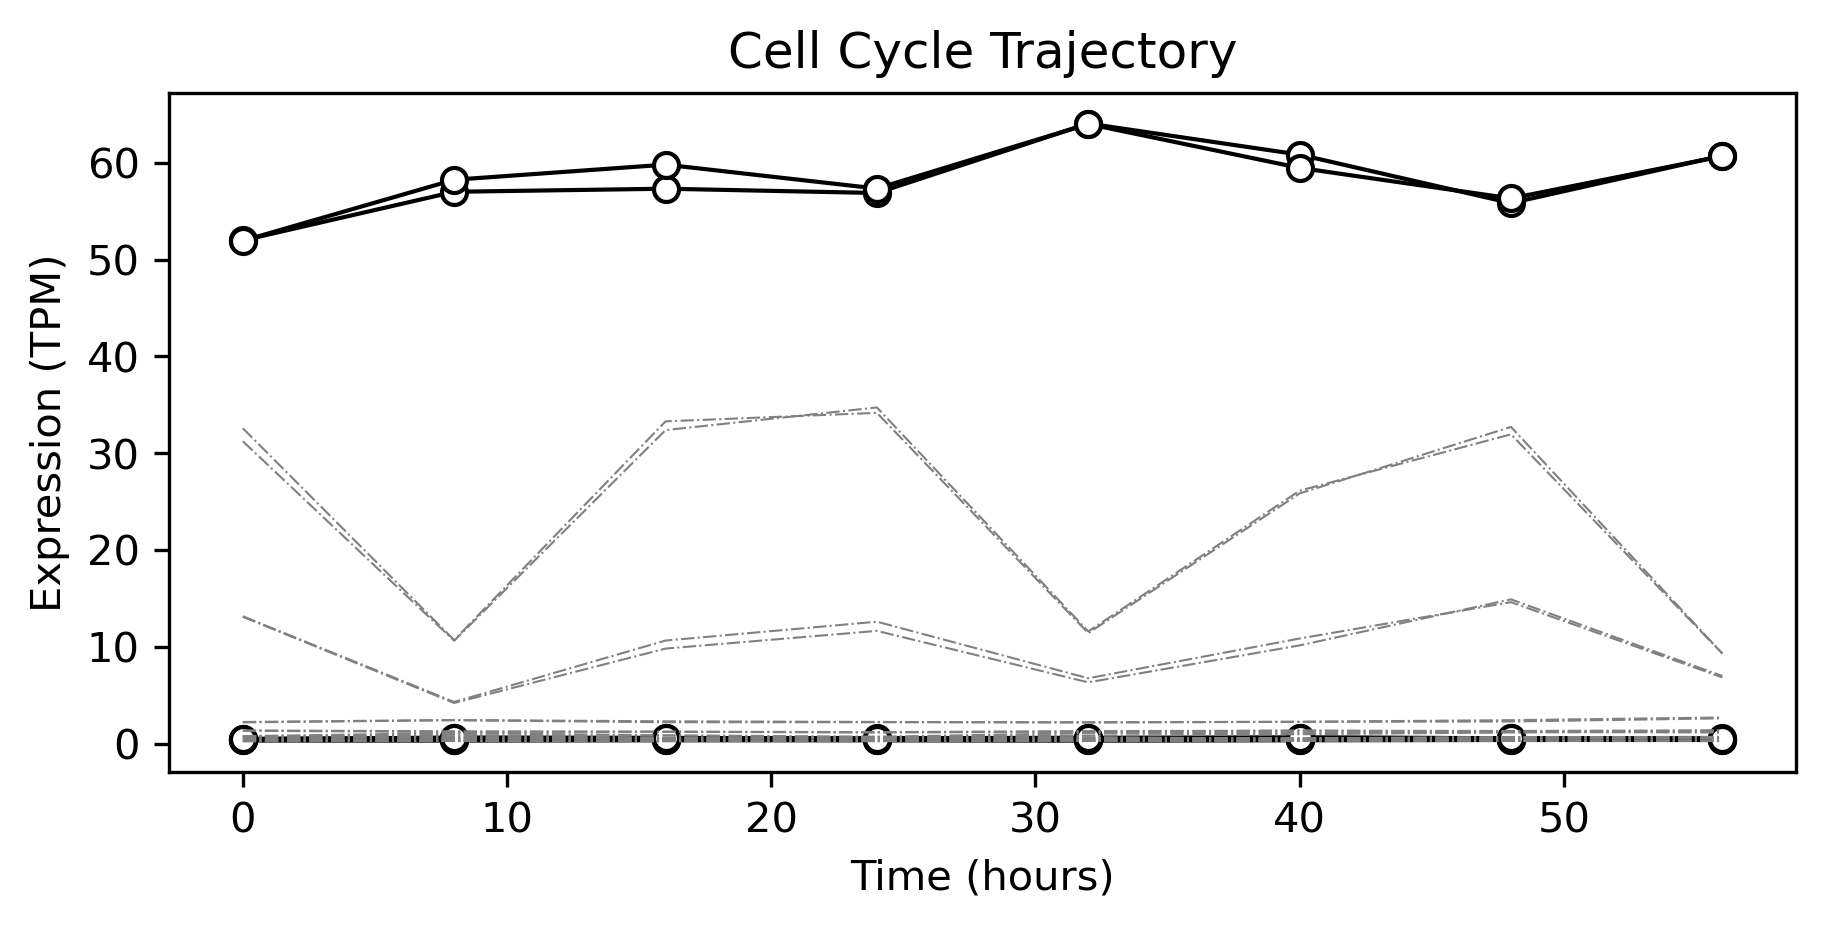

In [14]:
# plot data
sensorArgs = {'style': '-o',
              'color': 'black',
              'linewidth': 1}
stateArgs = {'style': '-.',
             'color': 'grey',
              'linewidth': 0.5}
n, t, r = trajectory.shape
xrange = 8 * np.array(range(t))
for i in range(n):
    if i < len(sensorGenes):
        line = sensorArgs
    else:
        line = stateArgs
    plt.plot(xrange, trajectory[i,:,0], line['style'], color=line['color'], markerfacecolor='white', linewidth=line['linewidth'])
    plt.plot(xrange, trajectory[i,:,1], line['style'], color=line['color'], markerfacecolor='white', linewidth=line['linewidth'])

plt.xlabel('Time (hours)')
plt.ylabel('Expression (TPM)')
plt.title('Cell Cycle Trajectory')
plt.show()

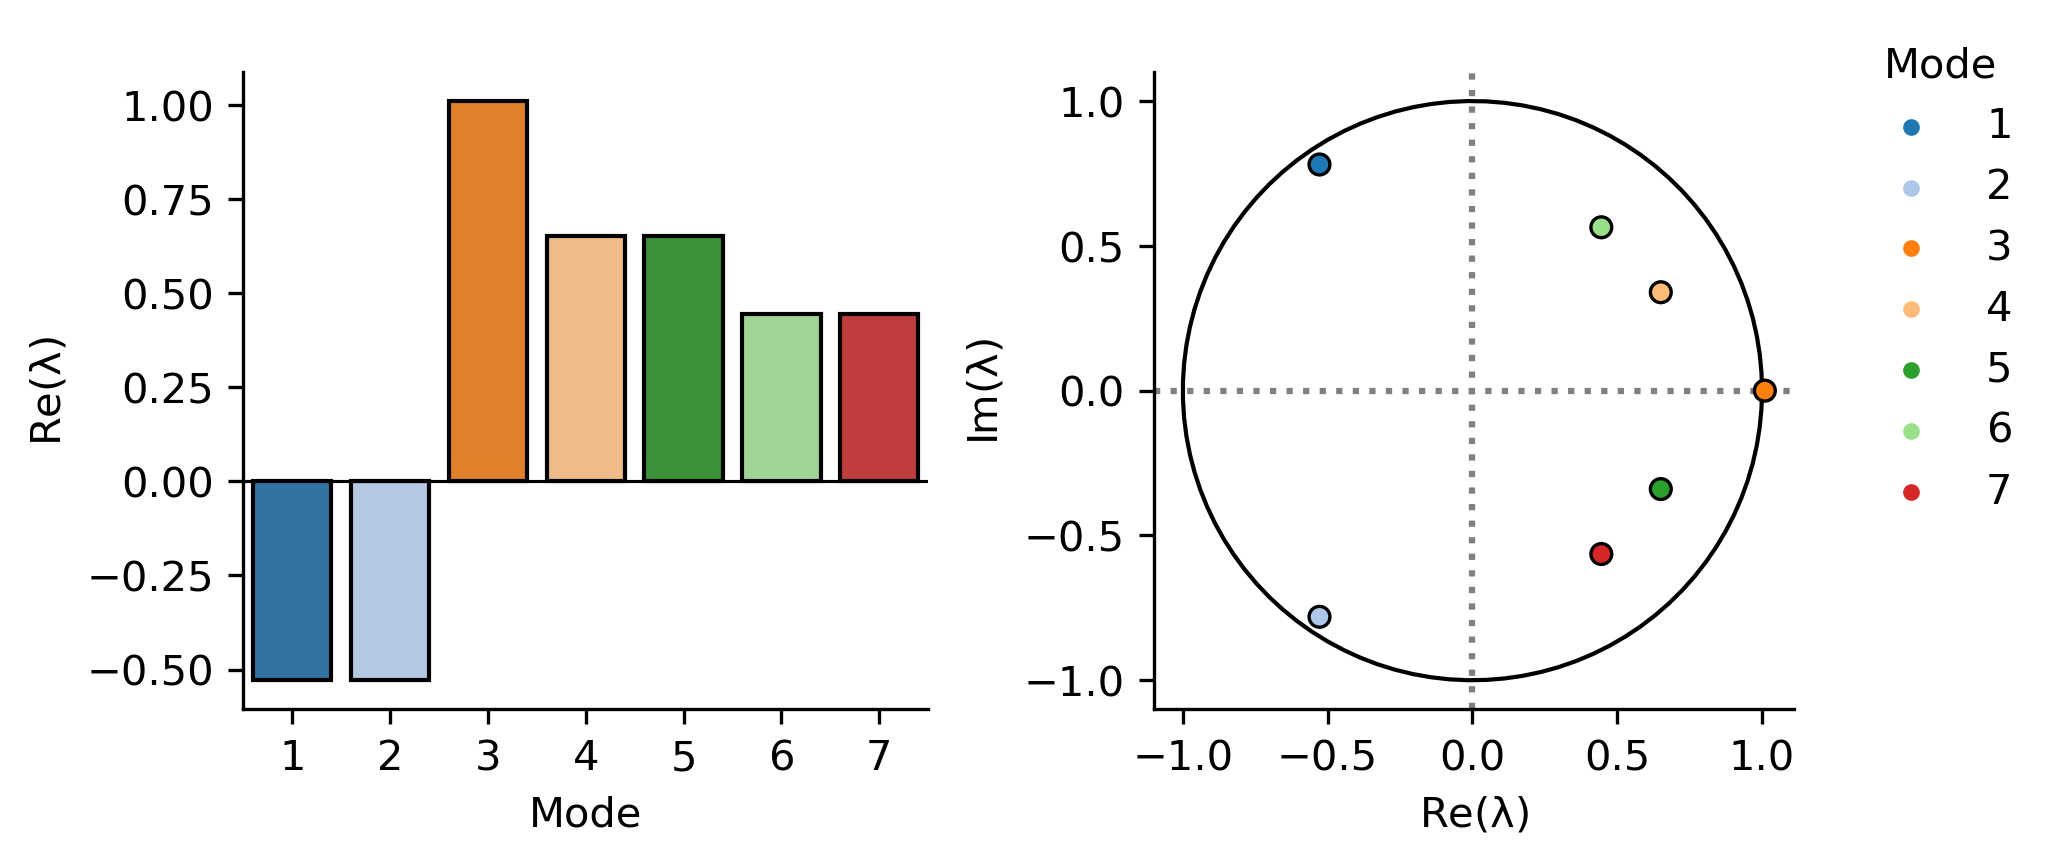

In [10]:
""" Plot DMD eigenvalues  """
t = np.linspace(0, np.pi*2, 100)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 3
fig, axs = plt.subplots(1, 2)
L = dmd_res['L']
pdf = pd.DataFrame({'real' : np.real(L), 'imaginary' : np.imag(L)})
pdf['mode'] = list(range(1, len(pdf)+1))
# plot real parts
sns.barplot(data=pdf, x='mode',y='real',hue='mode',ax=axs[0],dodge=False,ec='k',palette='tab20',)
axs[0].legend().remove()
axs[0].axhline(y=0, zorder=1, lw=0.75, c='k')
axs[0].set_xlabel("Mode")
axs[0].set_ylabel(r'$\mathregular{Re(\lambda)}$')
axs[1].plot(np.cos(t), np.sin(t), linewidth=1, c='k',zorder=1)
sns.scatterplot(data=pdf, x='real', y='imaginary', s=100, marker=".", hue='mode', ax=axs[1], ec='k', palette='tab20', zorder=3)
axs[1].axvline(x=0, ls=":", c='grey', zorder=0)
axs[1].axhline(y=0, ls=":", c='grey', zorder=0)
axs[1].set_aspect('equal')
axs[1].set_xlabel(r'$\mathregular{Re(\lambda)}$')
axs[1].set_ylabel(r'$\mathregular{Im(\lambda)}$')

sns.move_legend(axs[1], title='Mode',frameon=False, loc='upper right',markerscale=0.5,bbox_to_anchor=(1.4, 1.1))

sns.despine()
plt.tight_layout()

In [11]:
# tuning kalman filter
print(trajectory.shape)
trajectoryUnfolded = trajectory.reshape([trajectory.shape[0], trajectory.shape[1]*2])
print(trajectoryUnfolded.shape)
Q = 1 * np.cov(trajectoryUnfolded)
print(Q.shape)


(12, 8, 2)
(12, 16)
(12, 12)


In [35]:
# construct Kalman filter
f = KalmanFilter (dim_x=A.shape[0], dim_z=C.shape[0])
f.F = A
f.H = C
f.P *= 1
f.Q = np.random.rand(A.shape[0], A.shape[0])
f.x = np.random.rand(A.shape[0])
f.x

array([0.07893848, 0.86888945, 0.27185224, 0.21281794, 0.80011933,
       0.05780827, 0.42117777, 0.70159978, 0.34632997, 0.56718772,
       0.63495013, 0.22010255])

(12, 8)
(12, 8, 2)


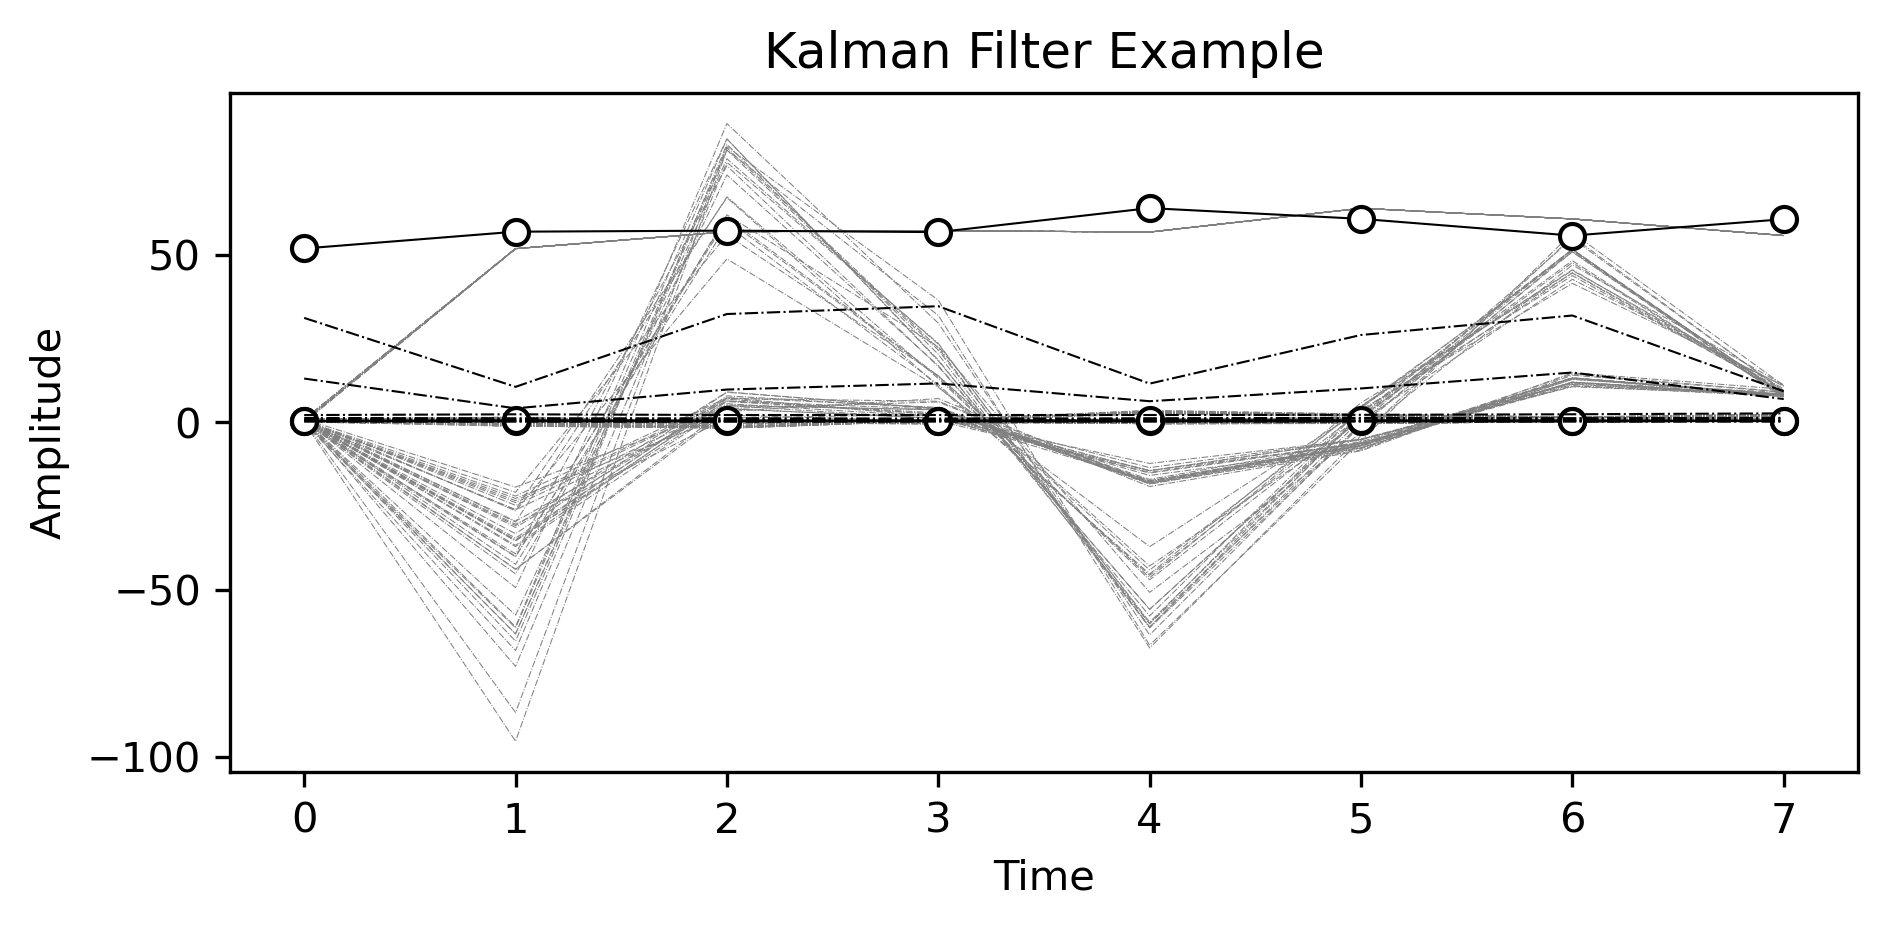

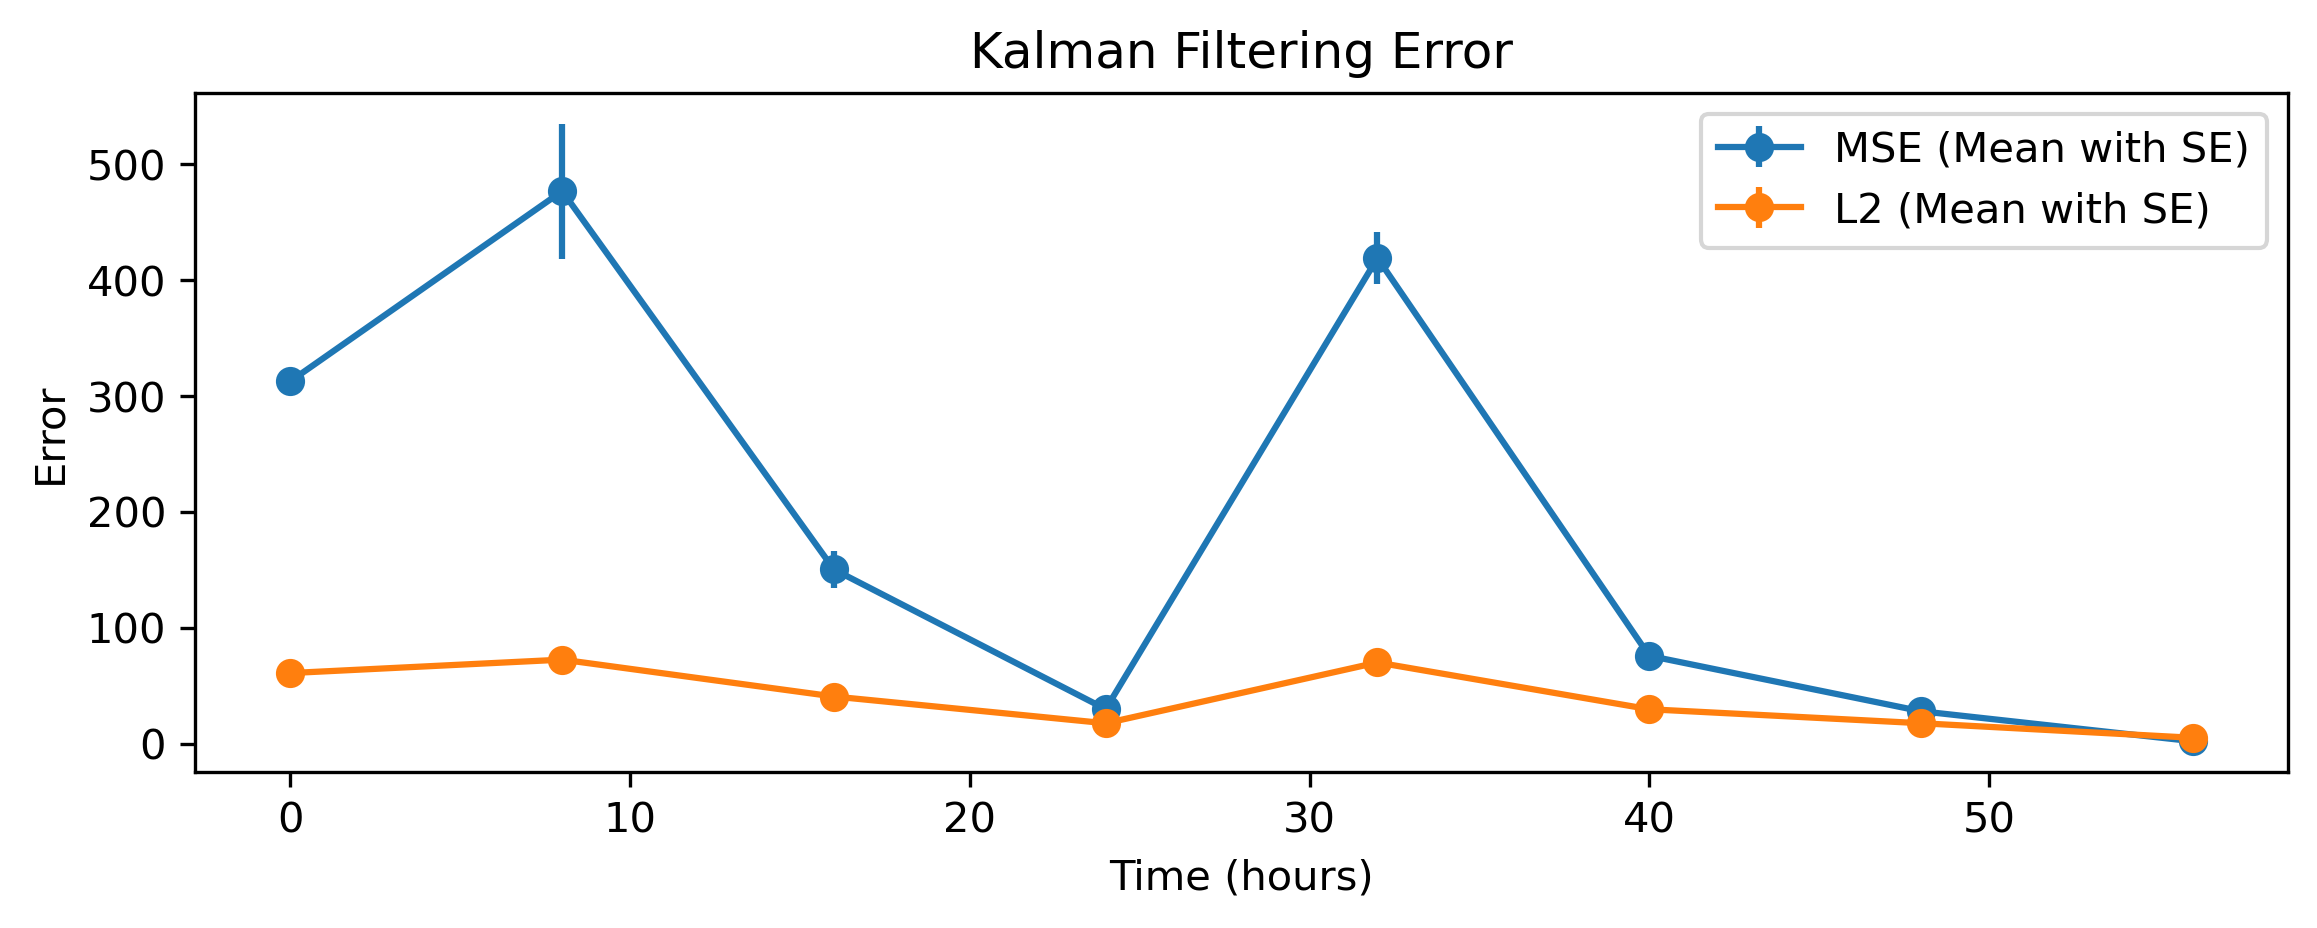

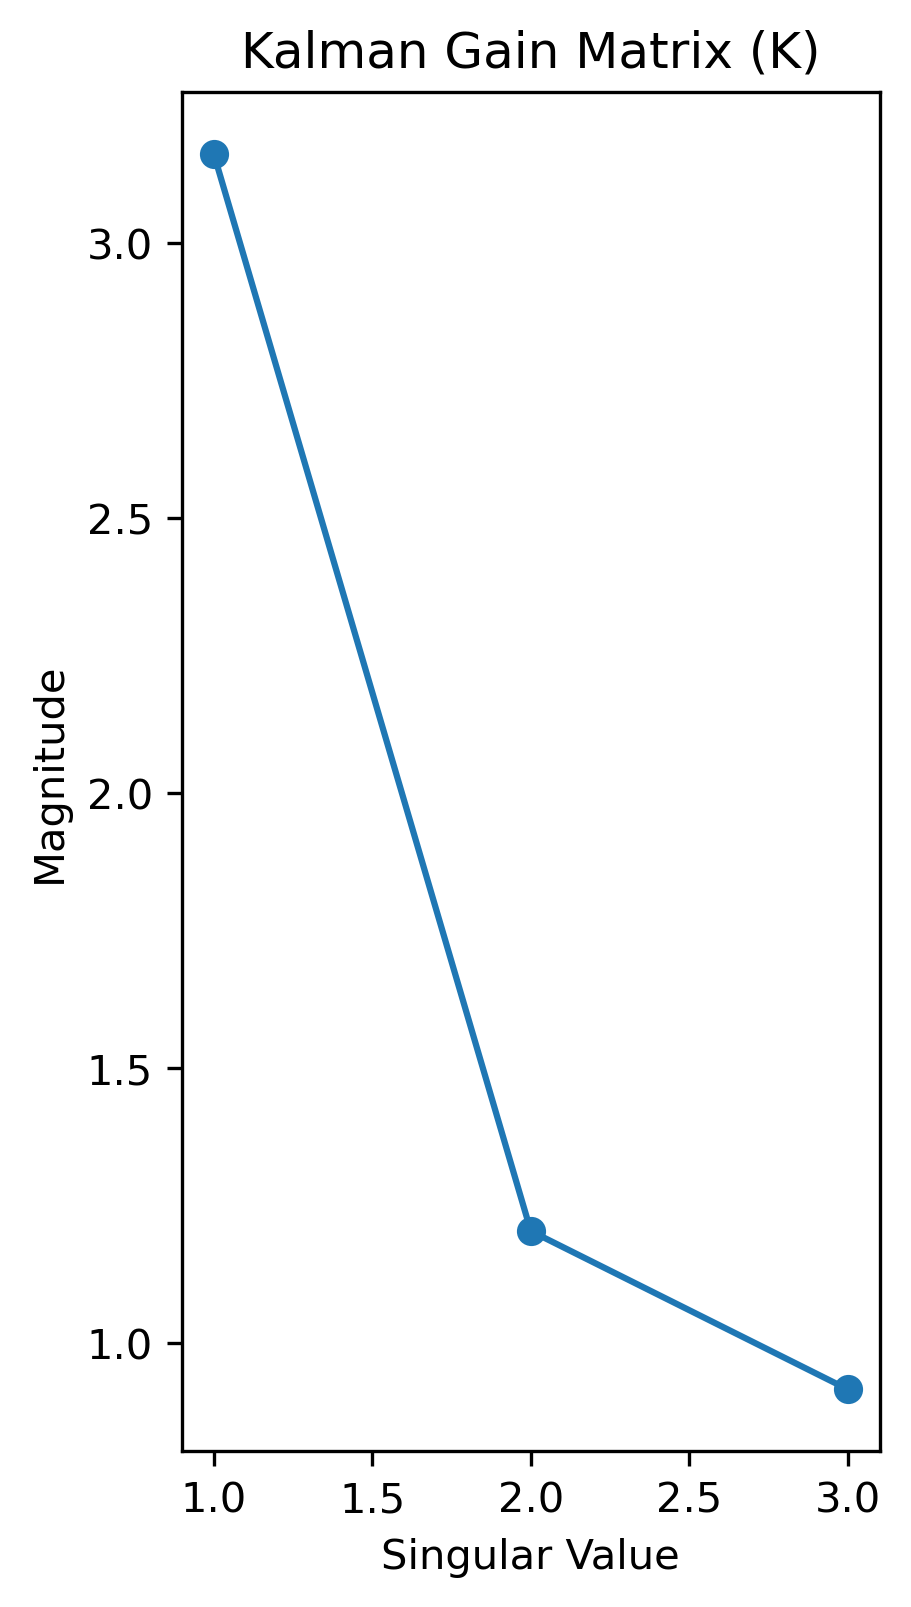

In [43]:
nsims = 20
trajs = []
for i in range(nsims):
    f.x = 1 * np.random.rand(A.shape[0])
    # apply kalman filter
    Xhat = [f.x]
    for i in range(trajectory.shape[1]-1):
        f.predict()
        f.update(C @ trajectory[:,i,0])
        Xhat.append(f.x)
    trajectoriesHat = np.array(Xhat).T
    trajs.append(trajectoriesHat)
    
print(trajectoriesHat.shape)
print(trajectory.shape)

trueLine = {'style': '-.',
        'color': 'black',
        'linewidth': 0.5}
predLine = {'style': '-.',
        'color': 'grey',
        'linewidth': 0.25}
sampLine = {'style': '-o',
            'color': 'black',
            'linewidth': 0.5}

xrange = np.array(range(trajectory.shape[1]))
for j in range(nsims):
    trajectoriesHat = trajs[j]
    for i in range(n):
        plt.plot(xrange, trajectoriesHat[i,:], predLine['style'], color=predLine['color'], markerfacecolor='white', linewidth=predLine['linewidth'])
        
for i in range(n):
    if i < C.shape[0]:
        line = sampLine
    else:
        line = trueLine
    plt.plot(xrange, trajectory[i,:,0], line['style'], color=line['color'], markerfacecolor='white', linewidth=line['linewidth'])    
plt.title('Kalman Filter Example')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.show()

## plot errors
MSE = []
L2 = []
for t in range(trajectory.shape[1]):
    mse = []
    l2 = []
    for i in range(nsims):
        trajectoriesHat = trajs[i]
        mse.append((np.square(trajectory[:,t,0] - trajectoriesHat[:,t])).mean())
        l2.append(np.linalg.norm(trajectory[:,t,0] - trajectoriesHat[:,t]))
    MSE.append(mse)
    L2.append(l2)

MSE = np.array(MSE)
L2 = np.array(L2)

# Calculate mean and standard error for each column
mse_mean_values = np.mean(MSE, axis=1)
mse_std_errors = np.std(MSE, axis=1) / np.sqrt(MSE.shape[1])
l2_mean_values = np.mean(L2, axis=1)
l2_std_errors = np.std(L2, axis=1) / np.sqrt(L2.shape[1])
xrange = 8 * np.array(range(mse_mean_values.shape[0]))
plt.figure(figsize=(9,3))
plt.errorbar(xrange, mse_mean_values, yerr=mse_std_errors, fmt='-o', label='MSE (Mean with SE)')
plt.errorbar(xrange, l2_mean_values, yerr=l2_std_errors, fmt='-o', label='L2 (Mean with SE)')
plt.xlabel('Time (hours)')
plt.ylabel('Error')
plt.title('Kalman Filtering Error')
plt.legend()
plt.show()

plt.figure(figsize=(3,6))
U, sigma, V = np.linalg.svd(f.K)
plt.plot(np.arange(1, len(sigma)+1), sigma, '-o')
plt.ylabel('Magnitude')
plt.xlabel('Singular Value')
plt.title('Kalman Gain Matrix (K)')
plt.show()

## Kalman Filtering from Hasnain (2023) Sensors

This section implements Kalman filtering according to the sensor selection from the Hasnain method

In [123]:
# filter out uninteresting genes
def filterGeneSet(tpm_2015, tpm_2018, k=1000, criteria='entropy', mergeGeneSets=True):
    if criteria == 'entropy':
        tpm_2015_normalized = tpm_2015.div(tpm_2015.sum(axis=1), axis=0)
        tpm_2018_normalized = tpm_2018.div(tpm_2018.sum(axis=1), axis=0)
        tpm_score_2015 = -(tpm_2015_normalized * np.log(tpm_2015_normalized)).sum(axis=1)
        tpm_score_2018 = -(tpm_2018_normalized * np.log(tpm_2018_normalized)).sum(axis=1)
    elif criteria == 'avg. expression':
        tpm_score_2015 = tpm_2015.mean(axis=1)
        tpm_score_2018 = tpm_2018.mean(axis=1)
    elif criteria == 'std.':
        tpm_score_2015 = tpm_2015.std(axis=1)
        tpm_score_2018 = tpm_2018.std(axis=1)

    # select k largest indices
    top_k_indices_2015 = tpm_score_2015.nlargest(k).index
    top_k_indices_2018 = tpm_score_2018.nlargest(k).index

    if mergeGeneSets:
        # take union of genes selected from 2015 and 2018
        include_indices = (top_k_indices_2015).union(top_k_indices_2018)

        # remove genes not aparent in both 2015 and 2018
        common_indices = set(tpm_2015.index) & set(tpm_2018.index)
        include_indices = include_indices.intersection(common_indices)

        # recude the data to have the same indices
        tpm_r_2015 = tpm_2015[tpm_2015.index.isin(include_indices)]
        tpm_r_2018 = tpm_2018[tpm_2015.index.isin(include_indices)]
        gene_list = include_indices
    else:
        tpm_r_2015 = tpm_2015[tpm_2015.index.isin(top_k_indices_2015)]
        tpm_r_2018 = tpm_2018[tpm_2018.index.isin(top_k_indices_2018)]
        gene_list = (top_k_indices_2015, top_k_indices_2018)

    # convert to DMD format
    dmd_data_2015 = nb.data2DMD(tpm_r_2015, rescale=False)
    dmd_data_2018 = nb.data2DMD2017(tpm_r_2018, rescale=False)

    return dmd_data_2015, dmd_data_2018, gene_list

selectionCriteria = ['entropy', 'avg. expression', 'std.']
dmd_data_2015, dmd_data_2018, gene_list = filterGeneSet(tpm_2015, tpm_2018, k=1000, criteria=selectionCriteria[0])

print(dmd_data_2015.shape)
print(dmd_data_2018.shape)

(1770, 8, 2)
(1770, 15, 2)


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [48]:
ss2015 = sensorSelection.hasnain2023(dmd_data_2015, dmd_rank=7, gramT=30, vxNames=gene_list)
ss2018 = sensorSelection.hasnain2023(dmd_data_2018, dmd_rank=7, gramT=30, vxNames=gene_list)
ds = {'2015': {
                'ss': ss2015
            },
      '2018': {
                'ss': ss2018
            }
     }

In [111]:
for data in ds.keys():
    print(data)
    ss = ds[data]['ss']
    estimatorSet = {}
    for numSensors in [1, 2, 3, 5, 10, 50, 100, 200]: #[3, 5, 7, 10, 12, 15, 17]:
        if numSensors == 0:
            numSensors = 1
        print(numSensors)
        trajectory = dmd_data_2015
        A = ss2015['dmd']['A']
        sensors = ss['sensors']
        sensorGenes = sensors['gene'].values[:numSensors]
        idxs = [list(gene_list).index(gene) for gene in sensorGenes]
        C = getC(A.shape[0], idxs)

        trajectoryUnfolded = trajectory.reshape([trajectory.shape[0], trajectory.shape[1]*2])
        Q = 1 * np.cov(trajectoryUnfolded)

        # construct Kalman filter
        f = KalmanFilter (dim_x=A.shape[0], dim_z=C.shape[0])
        f.F = A
        f.H = C
        f.P *= 1
        f.Q = Q

        nsims = 5
        trajs = []
        for i in range(nsims):
            print('   ' + str(i))
            f.x = 1 * np.random.rand(A.shape[0])
            # apply kalman filter
            Xhat = [f.x]
            for i in range(trajectory.shape[1]-1):
                f.predict()
                f.update(C @ trajectory[:,i,0])
                Xhat.append(f.x)
            trajectoriesHat = np.array(Xhat).T
            trajs.append(trajectoriesHat)

        estimatorSet[numSensors] = trajs
    ds[data]['estimatorSet'] = estimatorSet

2015
1
   0
   1
   2
   3
   4
2
   0
   1
   2
   3
   4
3
   0
   1
   2
   3
   4
5
   0
   1
   2
   3
   4
10
   0
   1
   2
   3
   4
50
   0
   1
   2
   3
   4
100
   0
   1
   2
   3
   4
200
   0
   1
   2
   3
   4
2018
1
   0
   1
   2
   3
   4
2
   0
   1
   2
   3
   4
3
   0
   1
   2
   3
   4
5
   0
   1
   2
   3
   4
10
   0
   1
   2
   3
   4
50
   0
   1
   2
   3
   4
100
   0
   1
   2
   3
   4
200
   0
   1
   2
   3
   4


(1770, 8)
(1770, 8, 2)


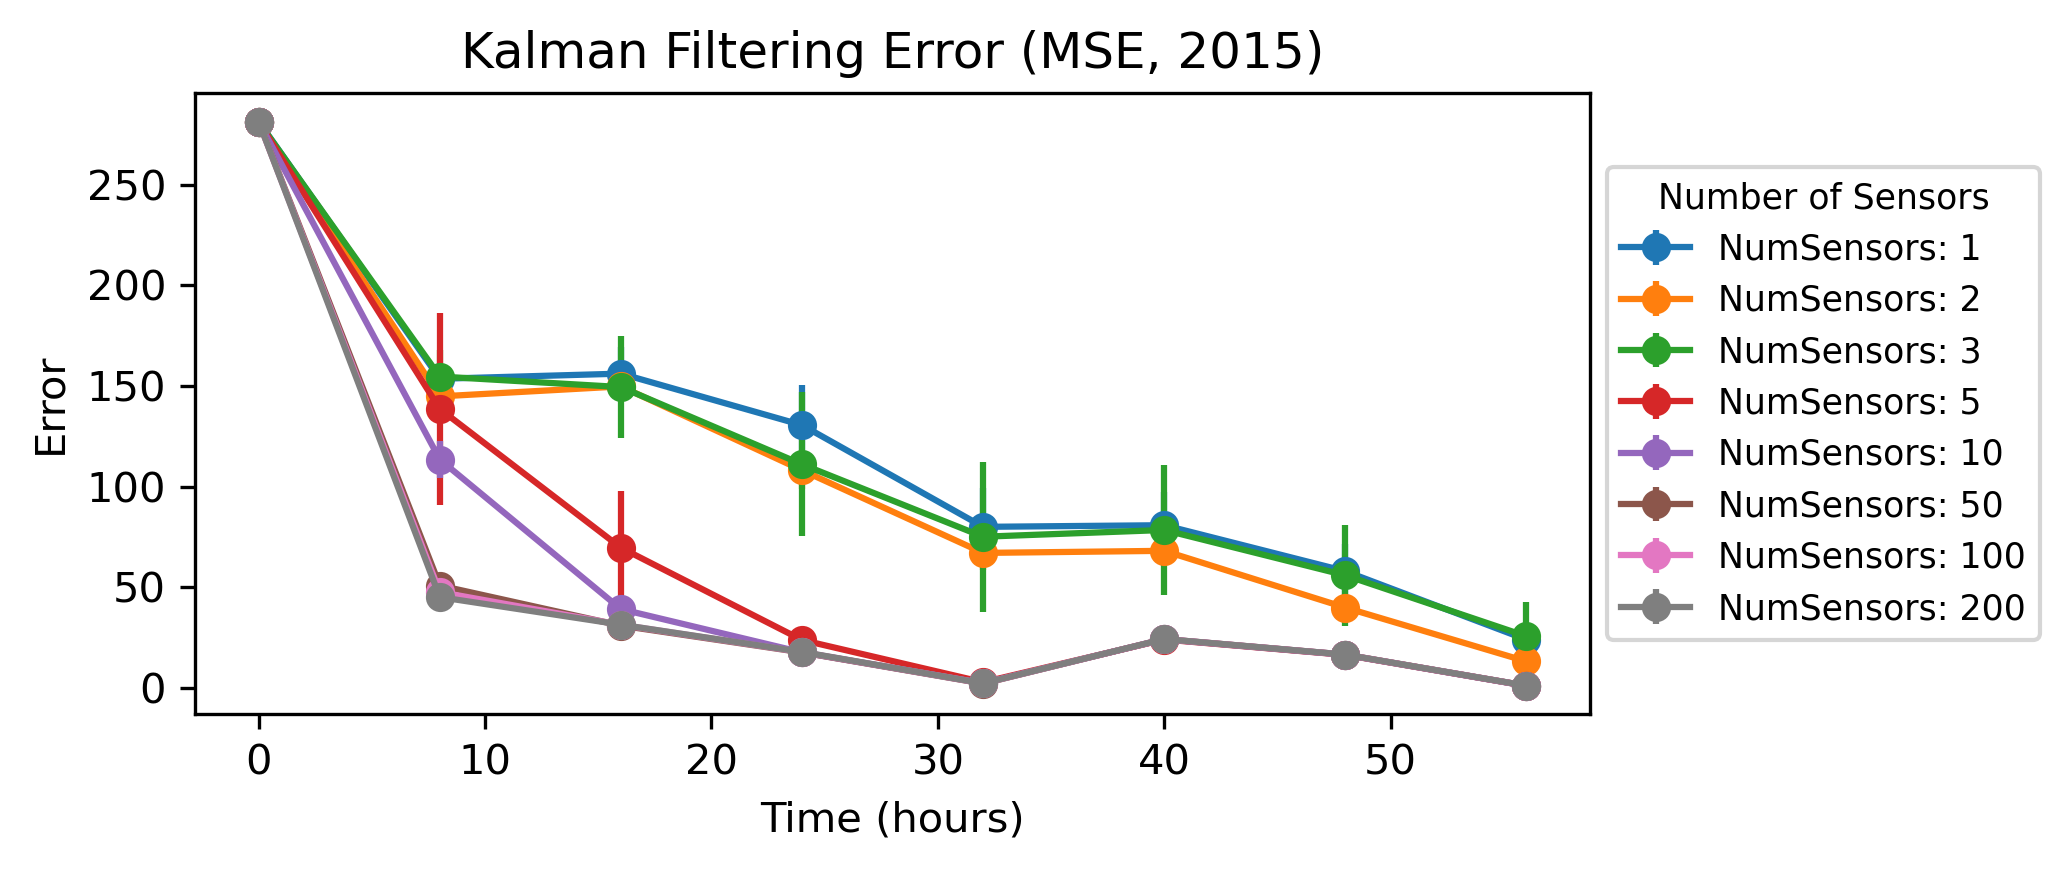

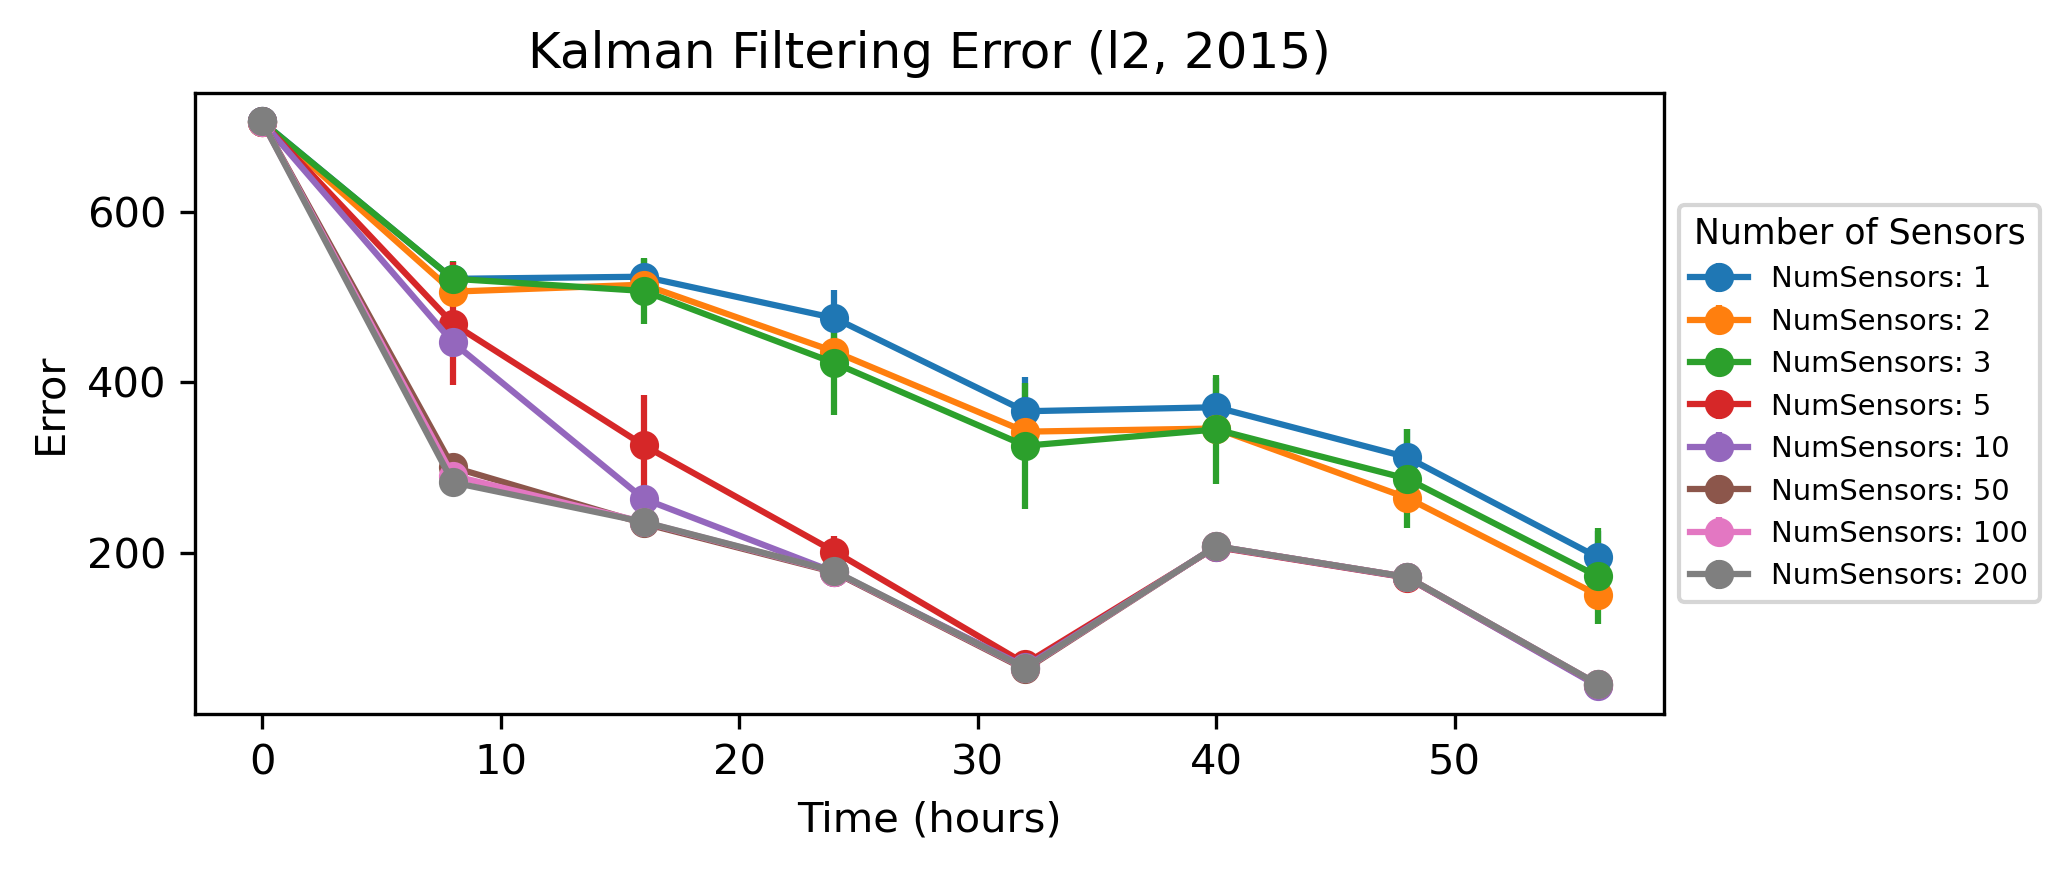

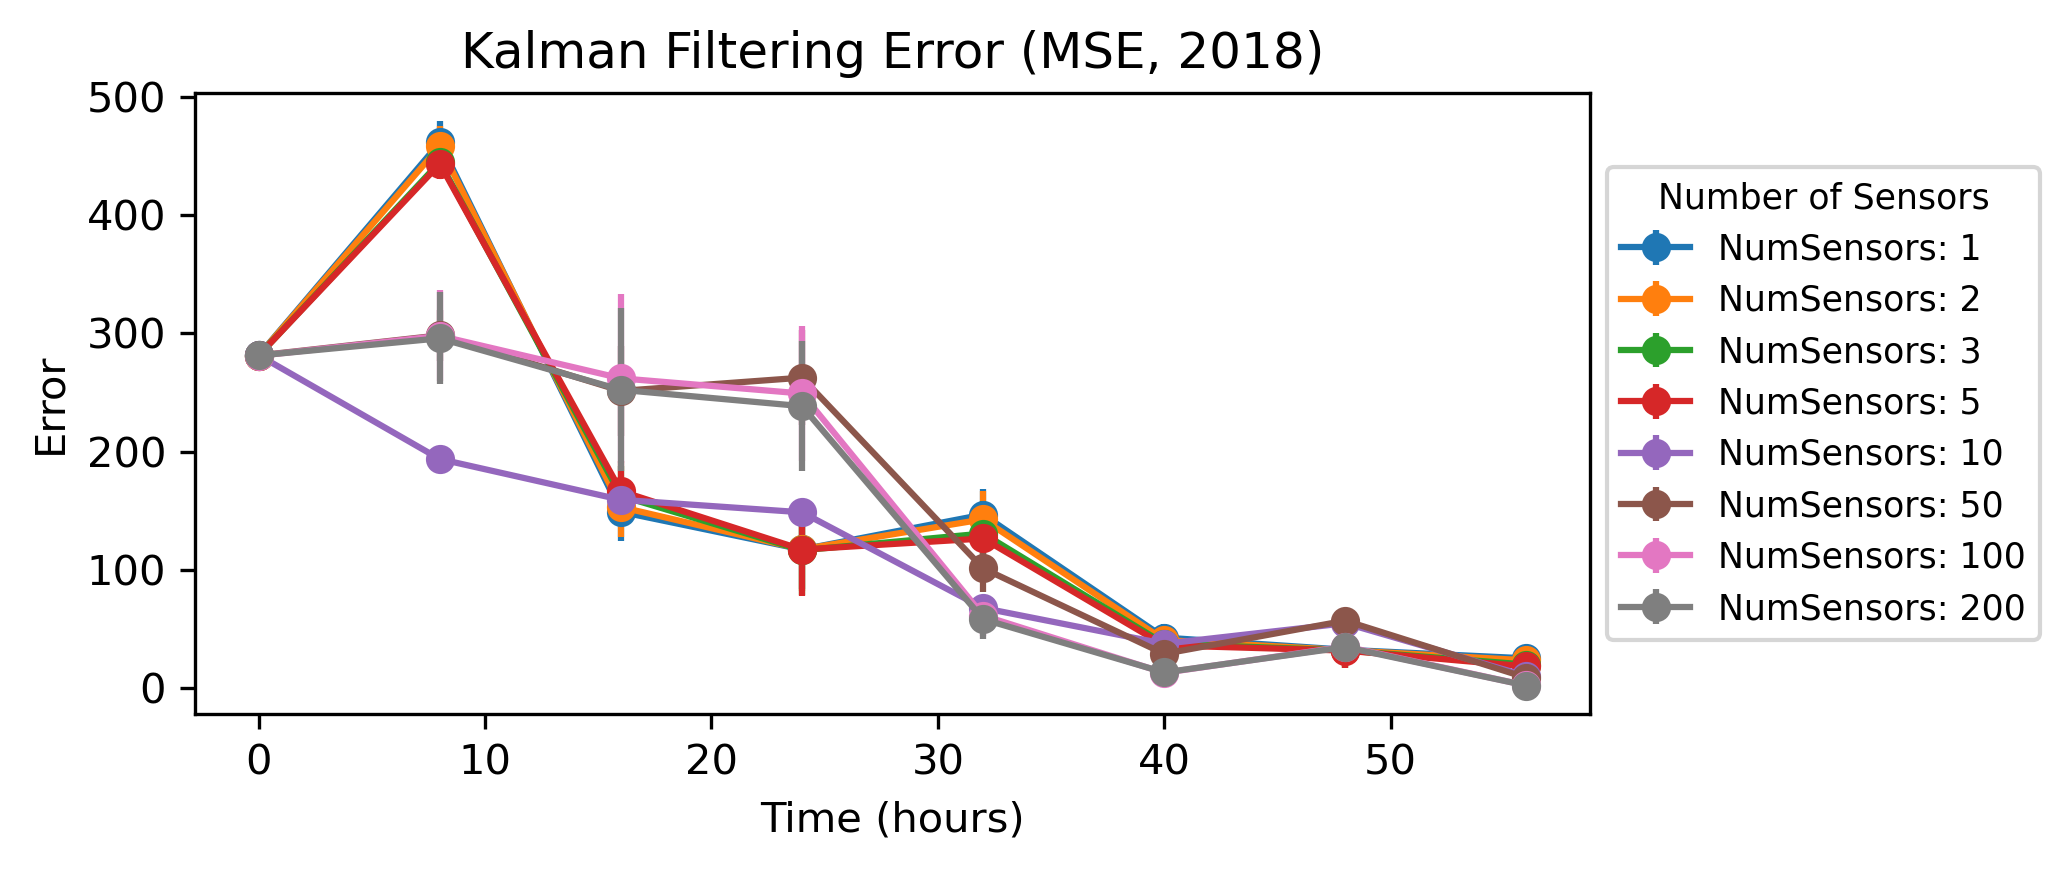

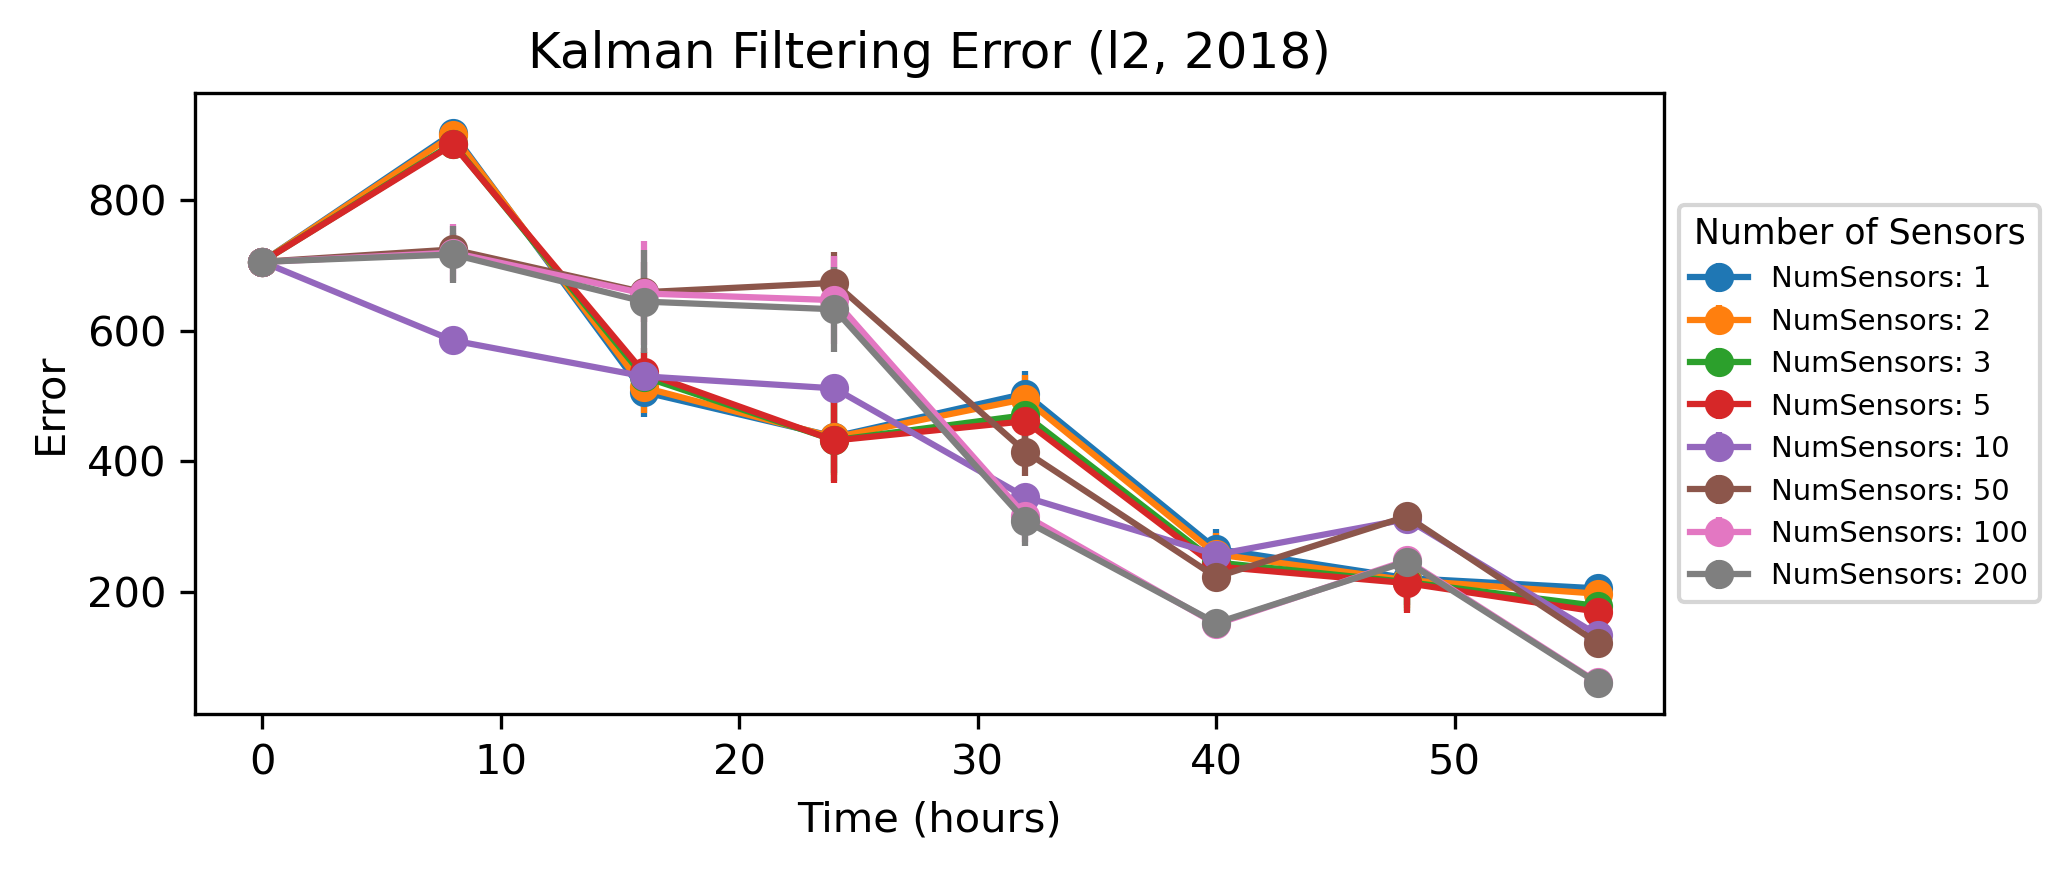

In [112]:
print(trajectoriesHat.shape)
print(trajectory.shape)

trueLine = {'style': '-.',
        'color': 'black',
        'linewidth': 0.5}
predLine = {'style': '-.',
        'color': 'grey',
        'linewidth': 0.25}
sampLine = {'style': '-o',
            'color': 'black',
            'linewidth': 0.5}
for data in ds.keys():
    estimatorSet = ds[data]['estimatorSet']
    
    keys = list(estimatorSet.keys())
    keys.sort()

    ## MSE plot
    for numSensors in keys:
        MSE = []
        trajs = estimatorSet[numSensors]
        for t in range(trajectory.shape[1]):
            mse = []
            for i in range(nsims):
                trajectoriesHat = trajs[i]
                mse.append((np.square(trajectory[:,t,0] - trajectoriesHat[:,t])).mean())
            MSE.append(mse)
        MSE = np.array(MSE)
        mse_mean_values = np.mean(MSE, axis=1)
        mse_std_errors = np.std(MSE, axis=1) / np.sqrt(MSE.shape[1])
        xrange = 8 * np.array(range(mse_mean_values.shape[0]))
        plt.errorbar(xrange, mse_mean_values, yerr=mse_std_errors, fmt='-o', label='NumSensors: ' + str(numSensors))
    plt.xlabel('Time (hours)')
    plt.ylabel('Error')
    plt.title('Kalman Filtering Error (MSE, ' + str(data) + ')')
    legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
    legend.set_title('Number of Sensors', prop={'size': 'small'})
    plt.tight_layout()
    plt.show()

    for numSensors in keys:
        L2 = []
        trajs = estimatorSet[numSensors]
        for t in range(trajectory.shape[1]):
            l2 = []
            for i in range(nsims):
                trajectoriesHat = trajs[i]
                l2.append(np.linalg.norm(trajectory[:,t,0] - trajectoriesHat[:,t]))
            L2.append(l2)
        L2 = np.array(L2)
        l2_mean_values = np.mean(L2, axis=1)
        l2_std_errors = np.std(L2, axis=1) / np.sqrt(L2.shape[1])
        xrange = 8 * np.array(range(mse_mean_values.shape[0]))
        plt.errorbar(xrange, l2_mean_values, yerr=l2_std_errors, fmt='-o', label='NumSensors: ' + str(numSensors))
    plt.xlabel('Time (hours)')
    plt.ylabel('Error')
    plt.title('Kalman Filtering Error (l2, ' + str(data) + ')')
    legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='x-small')
    legend.set_title('Number of Sensors', prop={'size': 'small'})
    plt.tight_layout()
    plt.show()

## Kalman Filtering from Hasnain (2023) Sensors

This section implements Kalman filtering according to the sensor selection from submodular optimization (criteria is maximize `tr(G)`). We only have this for 2015 data currently

In [115]:
df = pd.read_csv('submodularOpt/geneNames_std_filtered_A_thresh_1.csv')
ssPath = '/scratch/indikar_root/indikar0/jpic/subOptSS/2015/std1/'
ssFile = 'soss_itr100_criteria1_gramT1.mat'
mat = mat73.loadmat(ssPath + ssFile)
# print(mat['out']['S'])

idx2gene = {index: gene_name for index, gene_name in enumerate(df['geneName'].unique())}
genes = []
for idx in mat['out']['S']:
    genes.append(idx2gene[idx])
    
df = pd.DataFrame()
df['gene'] = genes
df['rank'] = np.arange(1,len(genes)+ 1)

selectionCriteria = ['entropy', 'avg. expression', 'std.']
dmd_data_2015, _, gene_list = filterGeneSet(tpm_2015, tpm_2018, k=int(mat['out']['n']), criteria=selectionCriteria[1], mergeGeneSets=False)
gene_list = gene_list[0].values

In [118]:
mat['out']

{'M': array([114.54039152, 114.54033993, 114.54024569, ..., 114.54139983,
        114.54031491, 114.54032966]),
 'R': array([1.000e+00, 2.000e+00, 3.000e+00, ..., 1.473e+03, 1.474e+03,
        1.476e+03]),
 'S': array([1363., 1309.,  611., 1360.,  466.,  573.,   92., 1364., 1382.,
         455.,  567.,  762.,  198.,  509.,  519.,  520., 1328.,  523.,
          12.,  569.,  801.,  163.,  916.,  363.,  930.,  348.,  311.,
         606.,  492.,  202.,  698., 1228., 1044., 1384., 1094.,  166.,
          11.,   64.,  735., 1177., 1308., 1321.,  271.,   29.,  170.,
         368., 1383.,  151.,  376.,  559.,  169.,  610., 1223.,  766.,
         816.,  319.,  737.,  672.,  361.,  255.,  121., 1152.,  704.,
         947.,  313.,   76.,  557.,  967.,  120.,  497., 1167.,  216.,
         721., 1446., 1061.,  622., 1109.,  958.,  469.,  585.,  207.,
         177.,  673.,  825.,   60.,  790.,  383., 1372., 1178.,  394.,
        1325., 1475.,  432.,  798.,  589., 1142.,  195.,  364.,  683.,
        

In [124]:
selectionCriteria = ['entropy', 'avg. expression', 'std.']
dmd_data_2015, _, gene_list = filterGeneSet(tpm_2015, tpm_2018, k=int(mat['out']['n']), criteria=selectionCriteria[1], mergeGeneSets=False)
gene_list = gene_list[0].values
print(dmd_data_2015.shape)

(1476, 8, 2)


In [127]:
gene_list[0].values

array(['GAPDH', 'TMSB4X', 'B2M', ..., 'SARAF', 'CNOT9', 'PARP3'],
      dtype=object)

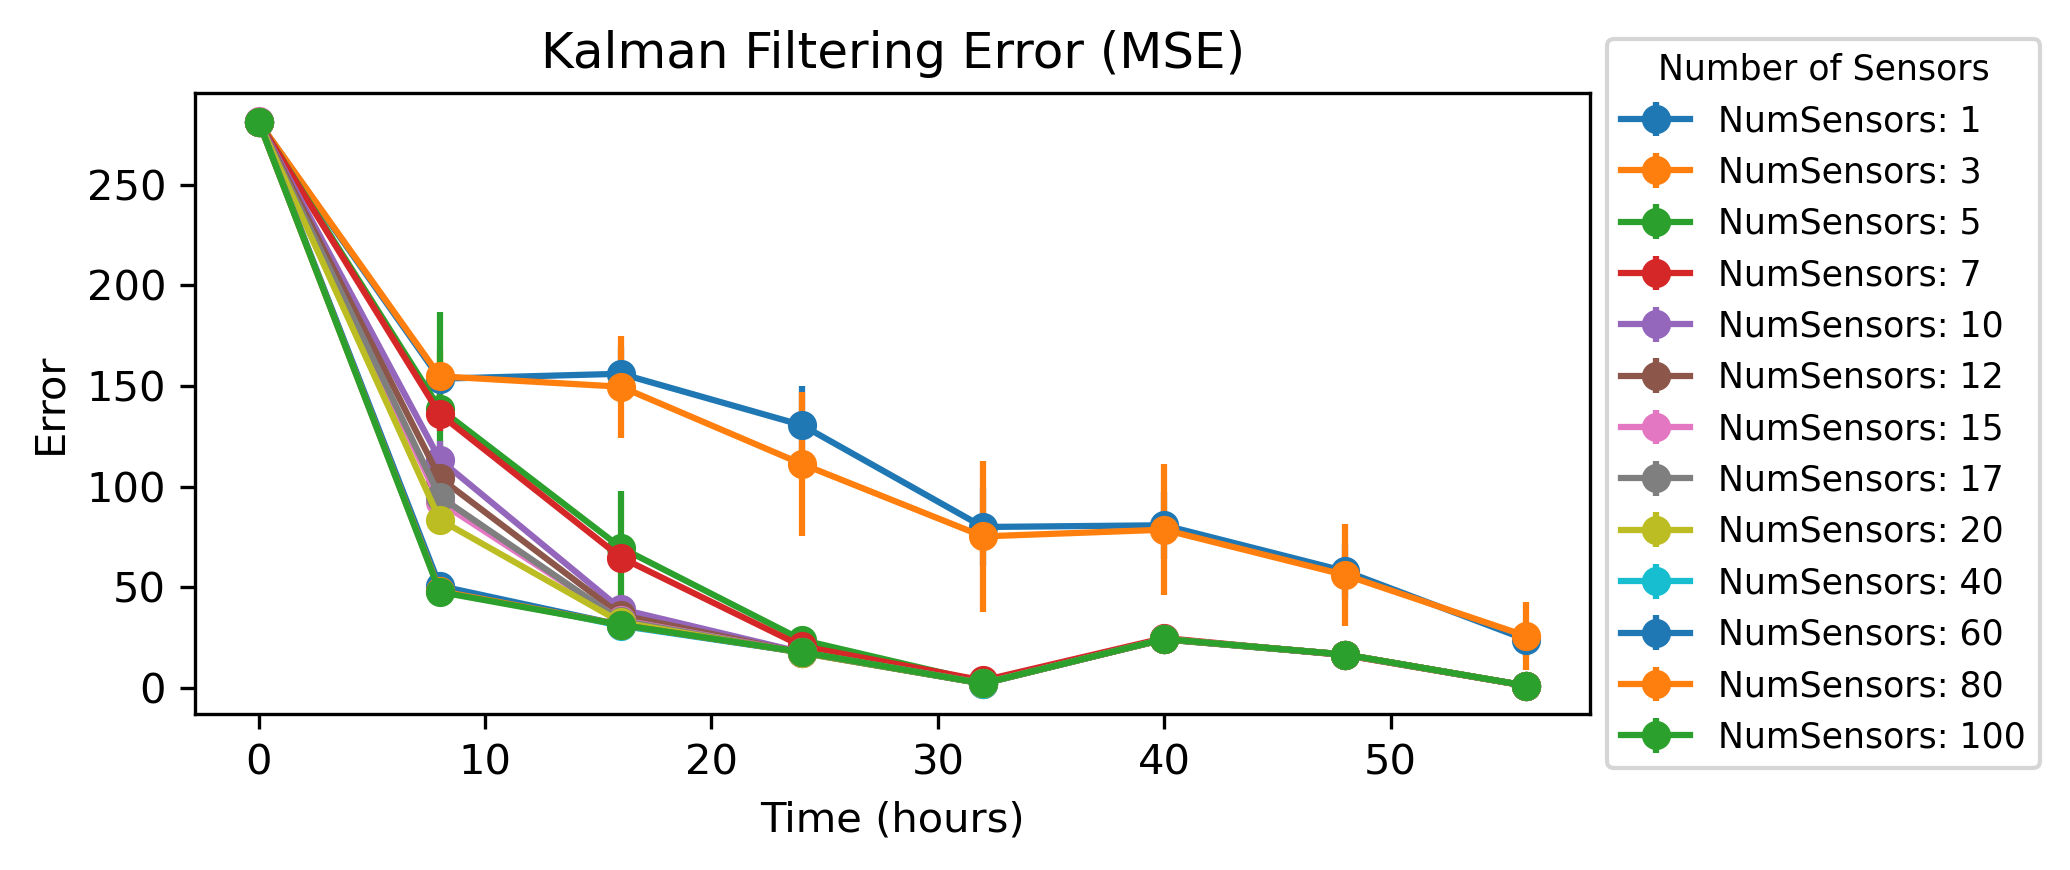

In [104]:
## MSE plot
for numSensors in keys:
    MSE = []
    trajs = estimatorSet[numSensors]
    for t in range(trajectory.shape[1]):
        mse = []
        for i in range(nsims):
            trajectoriesHat = trajs[i]
            mse.append((np.square(trajectory[:,t,0] - trajectoriesHat[:,t])).mean())
        MSE.append(mse)
    MSE = np.array(MSE)
    mse_mean_values = np.mean(MSE, axis=1)
    mse_std_errors = np.std(MSE, axis=1) / np.sqrt(MSE.shape[1])
    xrange = 8 * np.array(range(mse_mean_values.shape[0]))
    plt.errorbar(xrange, mse_mean_values, yerr=mse_std_errors, fmt='-o', label='NumSensors: ' + str(numSensors))
plt.xlabel('Time (hours)')
plt.ylabel('Error')
plt.title('Kalman Filtering Error (MSE)')
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
legend.set_title('Number of Sensors', prop={'size': 'small'})

# Improve overall layout
plt.tight_layout()

# Show the plot
plt.show()

In [102]:
print(list(estimatorSet.keys()).sort())
keys = list(estimatorSet.keys())
keys.sort()
print(keys)

None
[1, 3, 5, 7, 10, 12, 15, 17, 20, 40, 60, 80, 100]


In [78]:
nsims = 20
trajs = []
for i in range(nsims):
    f.x = 1 * np.random.rand(A.shape[0])
    # apply kalman filter
    Xhat = [f.x]
    for i in range(trajectory.shape[1]-1):
        f.predict()
        f.update(C @ trajectory[:,i,0])
        Xhat.append(f.x)
    trajectoriesHat = np.array(Xhat).T
    trajs.append(trajectoriesHat)

(1770, 8)
(1770, 8, 2)


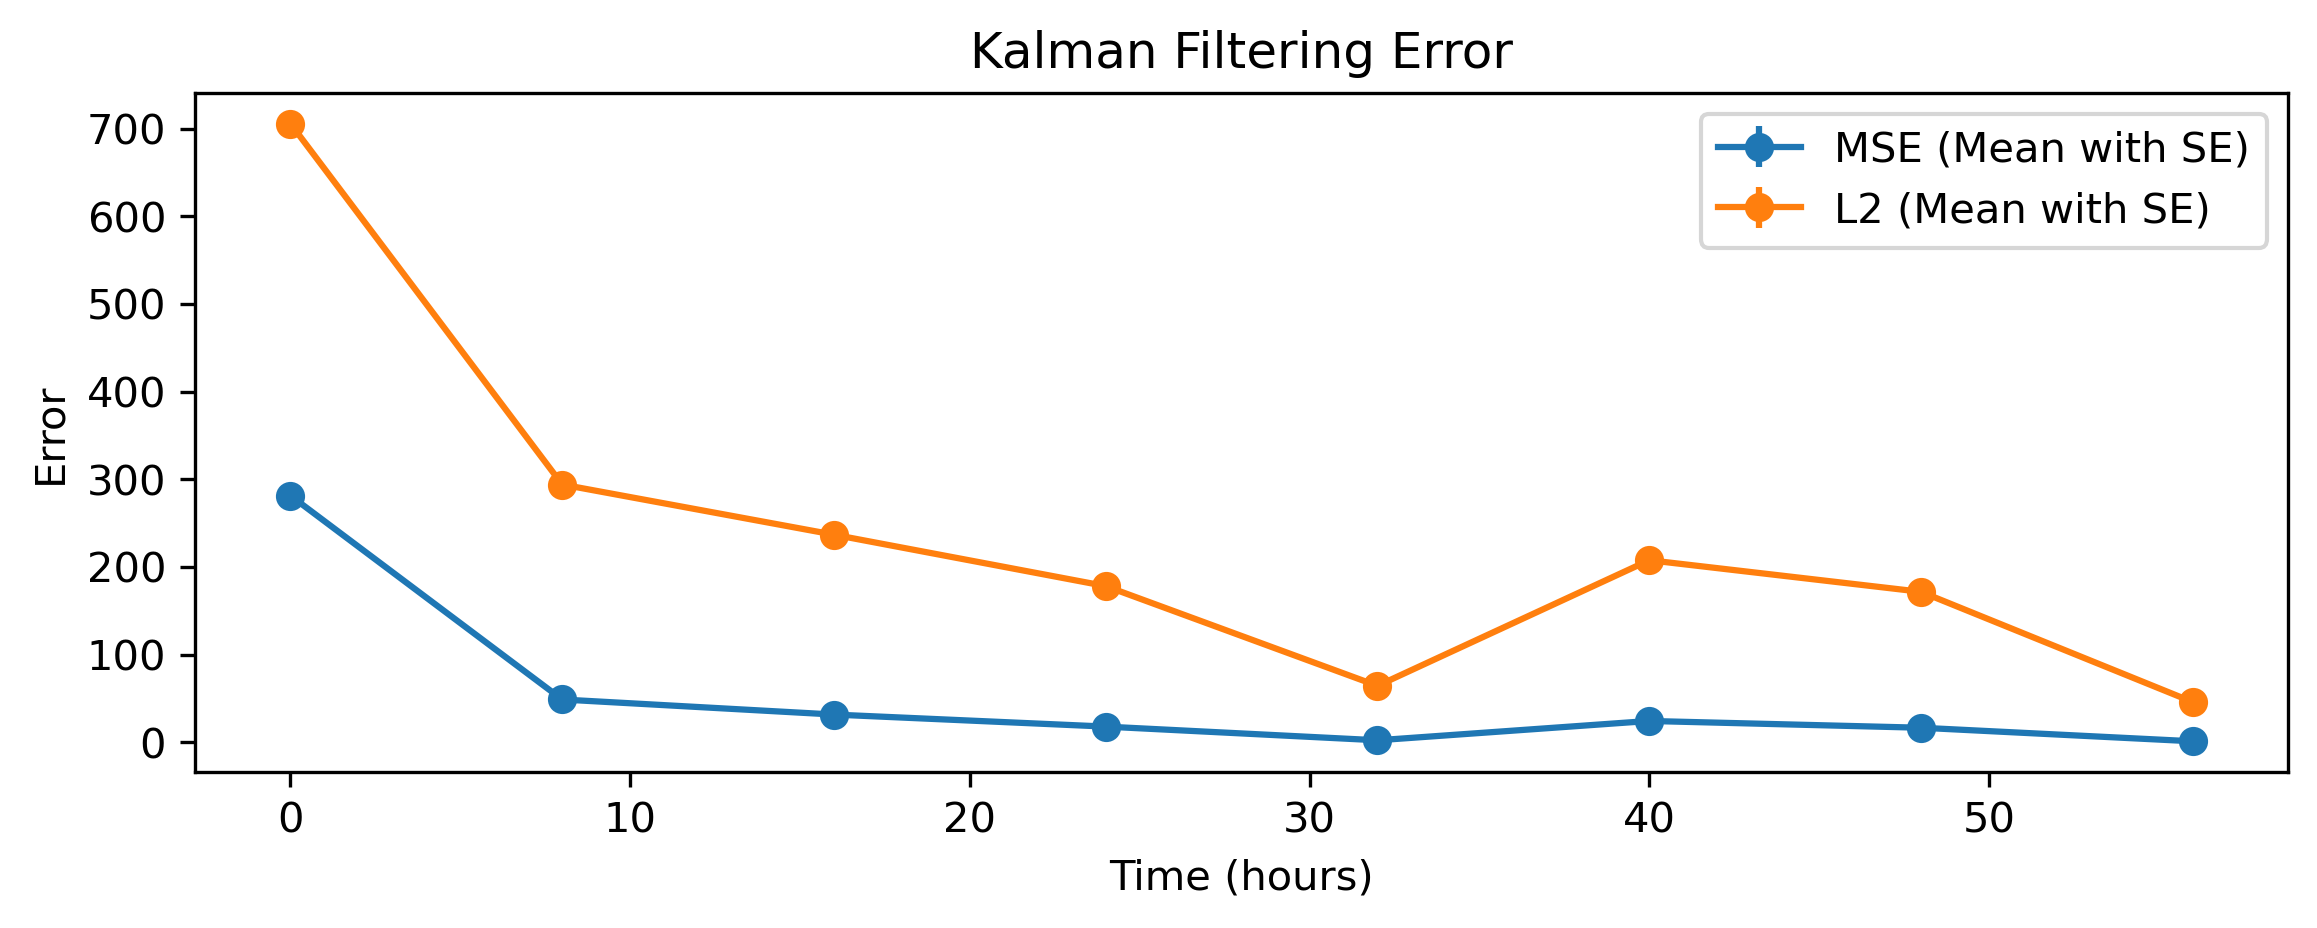

In [79]:
print(trajectoriesHat.shape)
print(trajectory.shape)

trueLine = {'style': '-.',
        'color': 'black',
        'linewidth': 0.5}
predLine = {'style': '-.',
        'color': 'grey',
        'linewidth': 0.25}
sampLine = {'style': '-o',
            'color': 'black',
            'linewidth': 0.5}

## plot errors
MSE = []
L2 = []
for t in range(trajectory.shape[1]):
    mse = []
    l2 = []
    for i in range(nsims):
        trajectoriesHat = trajs[i]
        mse.append((np.square(trajectory[:,t,0] - trajectoriesHat[:,t])).mean())
        l2.append(np.linalg.norm(trajectory[:,t,0] - trajectoriesHat[:,t]))
    MSE.append(mse)
    L2.append(l2)

MSE = np.array(MSE)
L2 = np.array(L2)

# Calculate mean and standard error for each column
mse_mean_values = np.mean(MSE, axis=1)
mse_std_errors = np.std(MSE, axis=1) / np.sqrt(MSE.shape[1])
l2_mean_values = np.mean(L2, axis=1)
l2_std_errors = np.std(L2, axis=1) / np.sqrt(L2.shape[1])
xrange = 8 * np.array(range(mse_mean_values.shape[0]))
plt.figure(figsize=(9,3))
plt.errorbar(xrange, mse_mean_values, yerr=mse_std_errors, fmt='-o', label='MSE (Mean with SE)')
plt.errorbar(xrange, l2_mean_values, yerr=l2_std_errors, fmt='-o', label='L2 (Mean with SE)')
plt.xlabel('Time (hours)')
plt.ylabel('Error')
plt.title('Kalman Filtering Error')
plt.legend()
plt.show()

In [69]:
# idxs = gene_list.index(sensorGenes)
idxs
j = 0
for i in idxs:
    print(list(gene_list)[i])
    print(sensorGenes[j])
    j += 1

list(gene_list)

['A2M',
 'AAGAB',
 'AAK1',
 'AAMP',
 'AAR2',
 'AATF',
 'ABCE1',
 'ABCF3',
 'ABHD12',
 'ABHD17B',
 'ABHD2',
 'ABI1',
 'ABI2',
 'ABRAXAS2',
 'ACAD9',
 'ACADM',
 'ACADVL',
 'ACBD3',
 'ACBD6',
 'ACIN1',
 'ACLY',
 'ACO2',
 'ACOT13',
 'ACP2',
 'ACSF3',
 'ACSL1',
 'ADAM9',
 'ADAR',
 'ADCY6',
 'ADD1',
 'ADIPOR1',
 'ADIPOR2',
 'ADK',
 'ADNP',
 'ADO',
 'ADPGK',
 'ADPRS',
 'AEBP2',
 'AFG3L2',
 'AFTPH',
 'AGA',
 'AGBL5',
 'AGFG1',
 'AGK',
 'AGO1',
 'AGPAT1',
 'AGPAT3',
 'AGTPBP1',
 'AHCY',
 'AHCYL1',
 'AIMP1',
 'AK2',
 'AKAP10',
 'AKAP8',
 'AKIRIN2',
 'AKR1A1',
 'AKT2',
 'AKT3',
 'AKTIP',
 'ALAS1',
 'ALDH18A1',
 'ALDH9A1',
 'ALDOA',
 'ALG1',
 'ALG13',
 'ALG2',
 'ALKBH5',
 'AMD1',
 'AMMECR1',
 'AMMECR1L',
 'AMZ2',
 'ANAPC2',
 'ANKLE2',
 'ANKRD13C',
 'ANKRD17',
 'ANKRD27',
 'ANKRD40',
 'ANO10',
 'ANP32B',
 'ANTXR1',
 'ANXA6',
 'ANXA7',
 'AP1G1',
 'AP2A1',
 'AP2A2',
 'AP3B1',
 'AP3D1',
 'AP3M1',
 'AP3S1',
 'APEX1',
 'APH1A',
 'APMAP',
 'APOL2',
 'APP',
 'APPBP2',
 'APPL1',
 'ARAF',
 'ARCN1',
 'AREL1'

In [55]:
sensors

gene                         ev1        weight    rank
0         UBB  4.800800e-01+0.000000e+00j  4.800800e-01     1.0
1        PTMA  2.718979e-01+0.000000e+00j  2.718979e-01     2.0
2       RACK1  2.307756e-01+0.000000e+00j  2.307756e-01     3.0
3       HLA-B  2.303546e-01+0.000000e+00j  2.303546e-01     4.0
4      EEF1B2  2.249322e-01+0.000000e+00j  2.249322e-01     5.0
...       ...                         ...           ...     ...
1765   CNRIP1  0.000000e+00+0.000000e+00j  0.000000e+00  1767.0
1766   ANTXR1  0.000000e+00+0.000000e+00j  0.000000e+00  1767.0
1767  KIRREL1  0.000000e+00+0.000000e+00j  0.000000e+00  1767.0
1768     MMP2 -1.000725e-07+0.000000e+00j -1.000725e-07  1769.0
1769   TSPAN6 -9.086993e-07+0.000000e+00j -9.086993e-07  1770.0

[1770 rows x 4 columns]

In [58]:
gene_list

Index(['A2M', 'AAGAB', 'AAK1', 'AAMP', 'AAR2', 'AATF', 'ABCE1', 'ABCF3',
       'ABHD12', 'ABHD17B',
       ...
       'ZNF740', 'ZNF75A', 'ZNF791', 'ZNF875', 'ZNHIT1', 'ZNHIT3', 'ZSCAN25',
       'ZUP1', 'ZZEF1', 'ZZZ3'],
      dtype='object', name='geneName', length=1770)

In [56]:
ss2015

{'sensors':          gene                         ev1        weight    rank
 0         UBB  4.800800e-01+0.000000e+00j  4.800800e-01     1.0
 1        PTMA  2.718979e-01+0.000000e+00j  2.718979e-01     2.0
 2       RACK1  2.307756e-01+0.000000e+00j  2.307756e-01     3.0
 3       HLA-B  2.303546e-01+0.000000e+00j  2.303546e-01     4.0
 4      EEF1B2  2.249322e-01+0.000000e+00j  2.249322e-01     5.0
 ...       ...                         ...           ...     ...
 1765   CNRIP1  0.000000e+00+0.000000e+00j  0.000000e+00  1767.0
 1766   ANTXR1  0.000000e+00+0.000000e+00j  0.000000e+00  1767.0
 1767  KIRREL1  0.000000e+00+0.000000e+00j  0.000000e+00  1767.0
 1768     MMP2 -1.000725e-07+0.000000e+00j -1.000725e-07  1769.0
 1769   TSPAN6 -9.086993e-07+0.000000e+00j -9.086993e-07  1770.0
 
 [1770 rows x 4 columns],
 'dmd': {'A': array([[ 1.62147274e-09,  2.31872017e-07,  3.28029433e-08, ...,
           1.52285759e-08,  6.85385400e-08, -1.05950420e-07],
         [-1.81878557e-07,  5.58912971e-0

### Code used to make figures for Kalman filtering

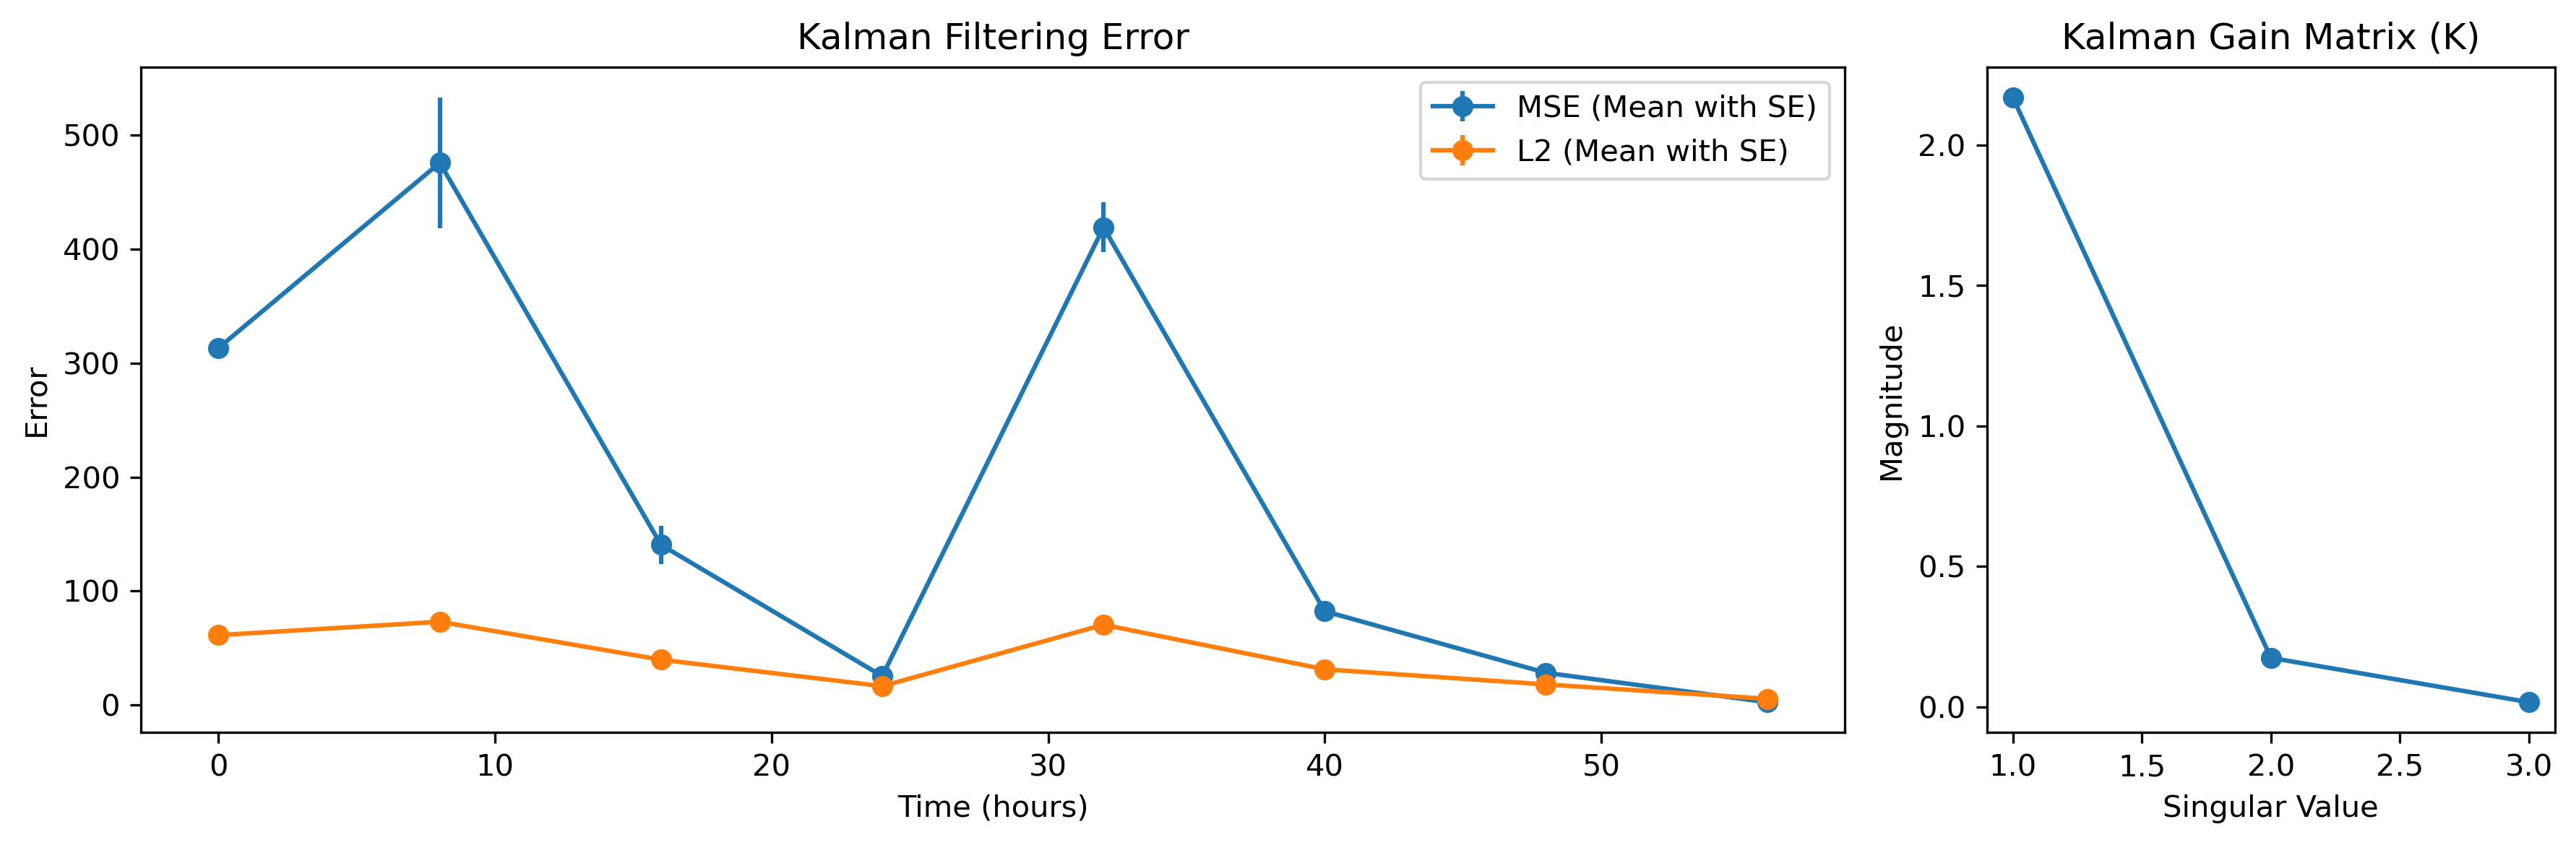

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [3, 1]})

# Plot for the first subplot
axs[0].errorbar(xrange, mse_mean_values, yerr=mse_std_errors, fmt='-o', label='MSE (Mean with SE)')
axs[0].errorbar(xrange, l2_mean_values, yerr=l2_std_errors, fmt='-o', label='L2 (Mean with SE)')

# Set labels and title for the first subplot
axs[0].set_xlabel('Time (hours)')
axs[0].set_ylabel('Error')
axs[0].set_title('Kalman Filtering Error')
axs[0].legend()

# Plot for the second subplot
axs[1].plot(np.arange(1, len(sigma) + 1), sigma, '-o')
axs[1].set_ylabel('Magnitude')
axs[1].set_xlabel('Singular Value')
axs[1].set_title('Kalman Gain Matrix (K)')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

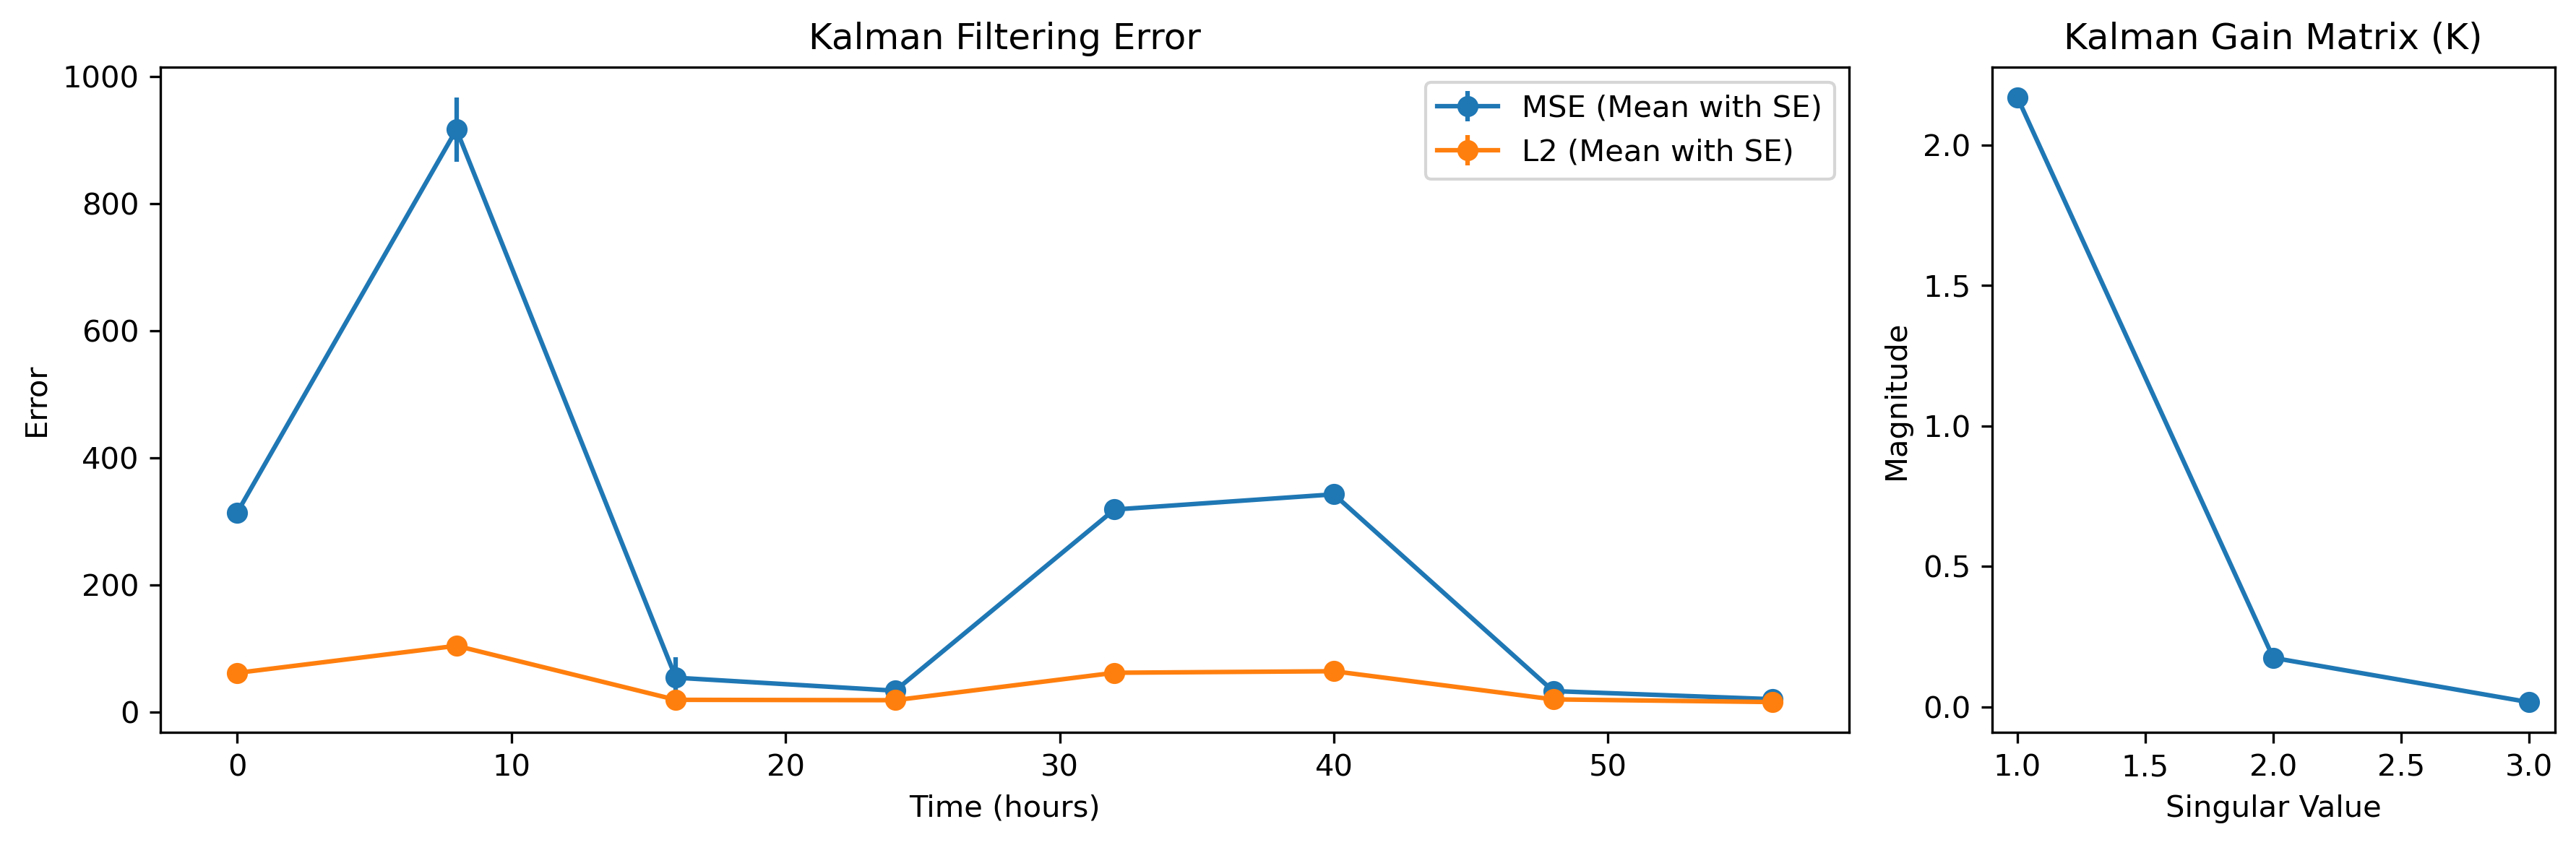

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [3, 1]})

# Plot for the first subplot
axs[0].errorbar(xrange, mse_mean_values, yerr=mse_std_errors, fmt='-o', label='MSE (Mean with SE)')
axs[0].errorbar(xrange, l2_mean_values, yerr=l2_std_errors, fmt='-o', label='L2 (Mean with SE)')

# Set labels and title for the first subplot
axs[0].set_xlabel('Time (hours)')
axs[0].set_ylabel('Error')
axs[0].set_title('Kalman Filtering Error')
axs[0].legend()

# Plot for the second subplot
axs[1].plot(np.arange(1, len(sigma) + 1), sigma, '-o')
axs[1].set_ylabel('Magnitude')
axs[1].set_xlabel('Singular Value')
axs[1].set_title('Kalman Gain Matrix (K)')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()


Text(0.5, 1.0, 'Kalman Gain Matrix (K)')

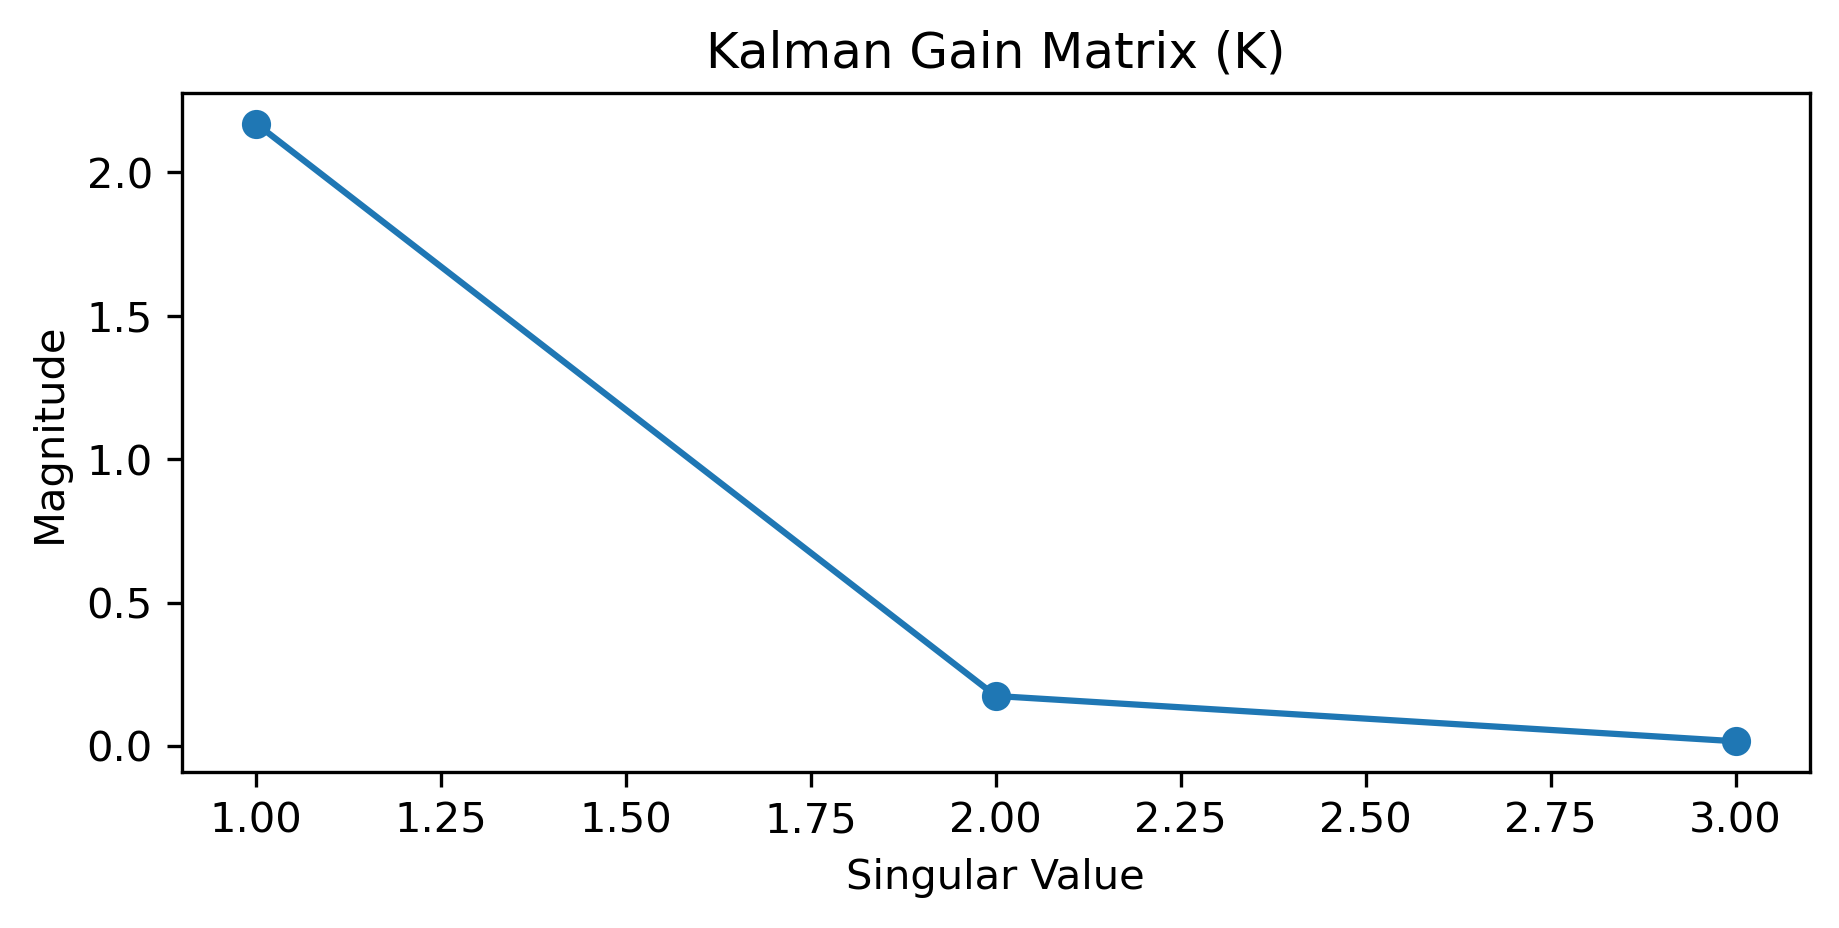

In [25]:
U, sigma, V = np.linalg.svd(f.K)
plt.plot(np.arange(1, len(sigma)+1), sigma, '-o')
plt.ylabel('Magnitude')
plt.xlabel('Singular Value')
plt.title('Kalman Gain Matrix (K)')

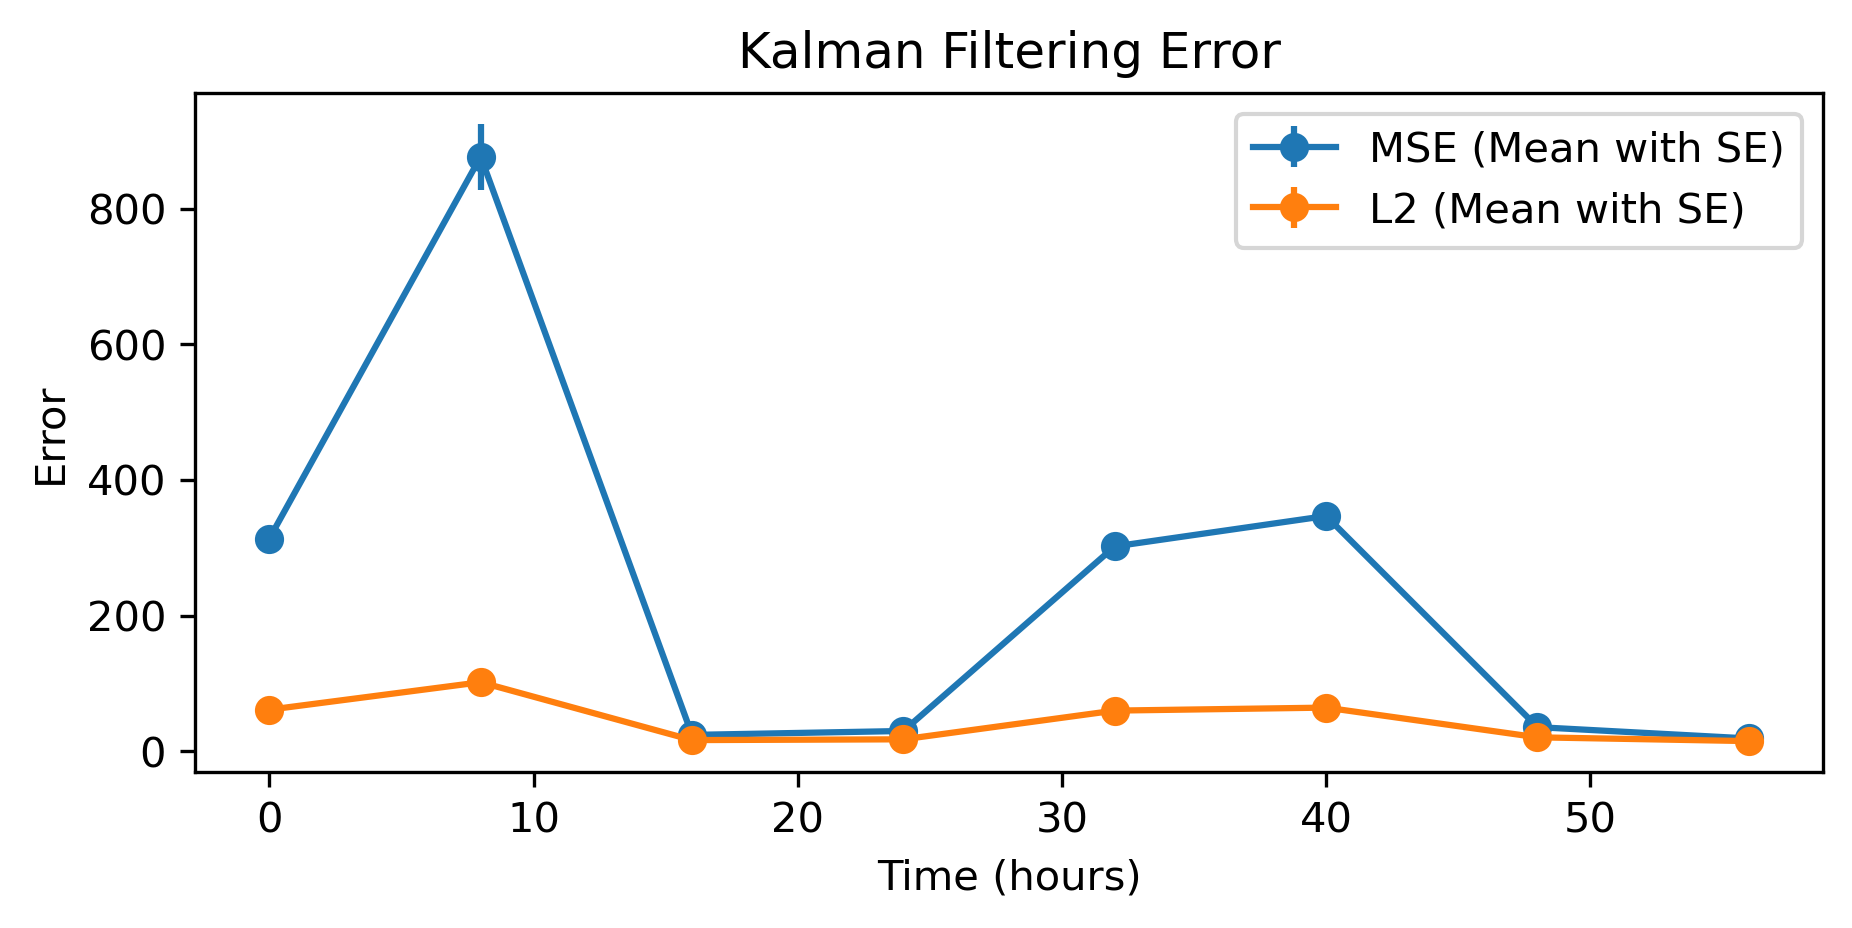

Text(0.5, 1.0, 'Kalman Gain Matrix (K)')

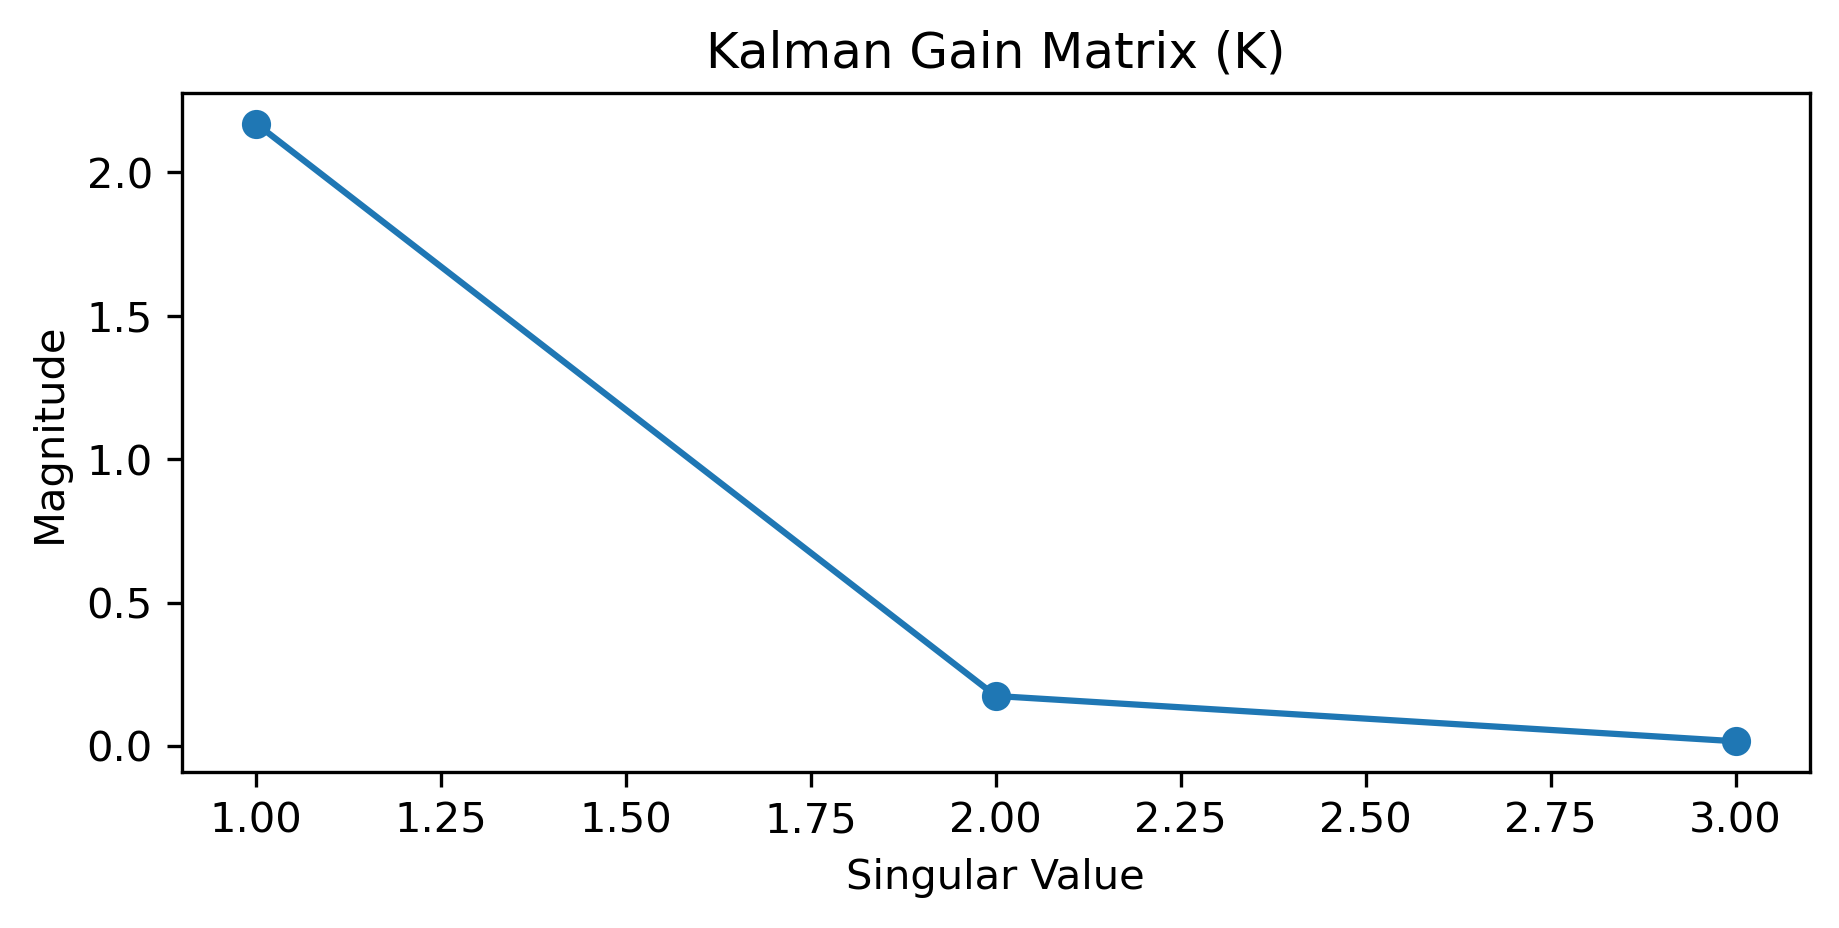

In [30]:


plt.errorbar(xrange, mse_mean_values, yerr=mse_std_errors, fmt='-o', label='MSE (Mean with SE)')
plt.errorbar(xrange, l2_mean_values, yerr=l2_std_errors, fmt='-o', label='L2 (Mean with SE)')

# Set labels and title
plt.xlabel('Time (hours)')
plt.ylabel('Error')
plt.title('Kalman Filtering Error')

# Show the legend
plt.legend()

# Show the plot
plt.show()

plt.plot(np.arange(1, len(sigma)+1), sigma, '-o')
plt.ylabel('Magnitude')
plt.xlabel('Singular Value')
plt.title('Kalman Gain Matrix (K)')

In [382]:
# apply kalman filter
Xhat = [f.x]
for i in range(trajectory.shape[1]-1):
    f.predict()
    f.update(C @ trajectory[:,i,0])
    Xhat.append(f.x)
    
trajectoriesHat = np.array(Xhat).T
print(trajectoriesHat.shape)
print(trajectory.shape)

(5, 8)
(5, 8, 2)


(12, 8)
(12, 8, 2)
8
8
8


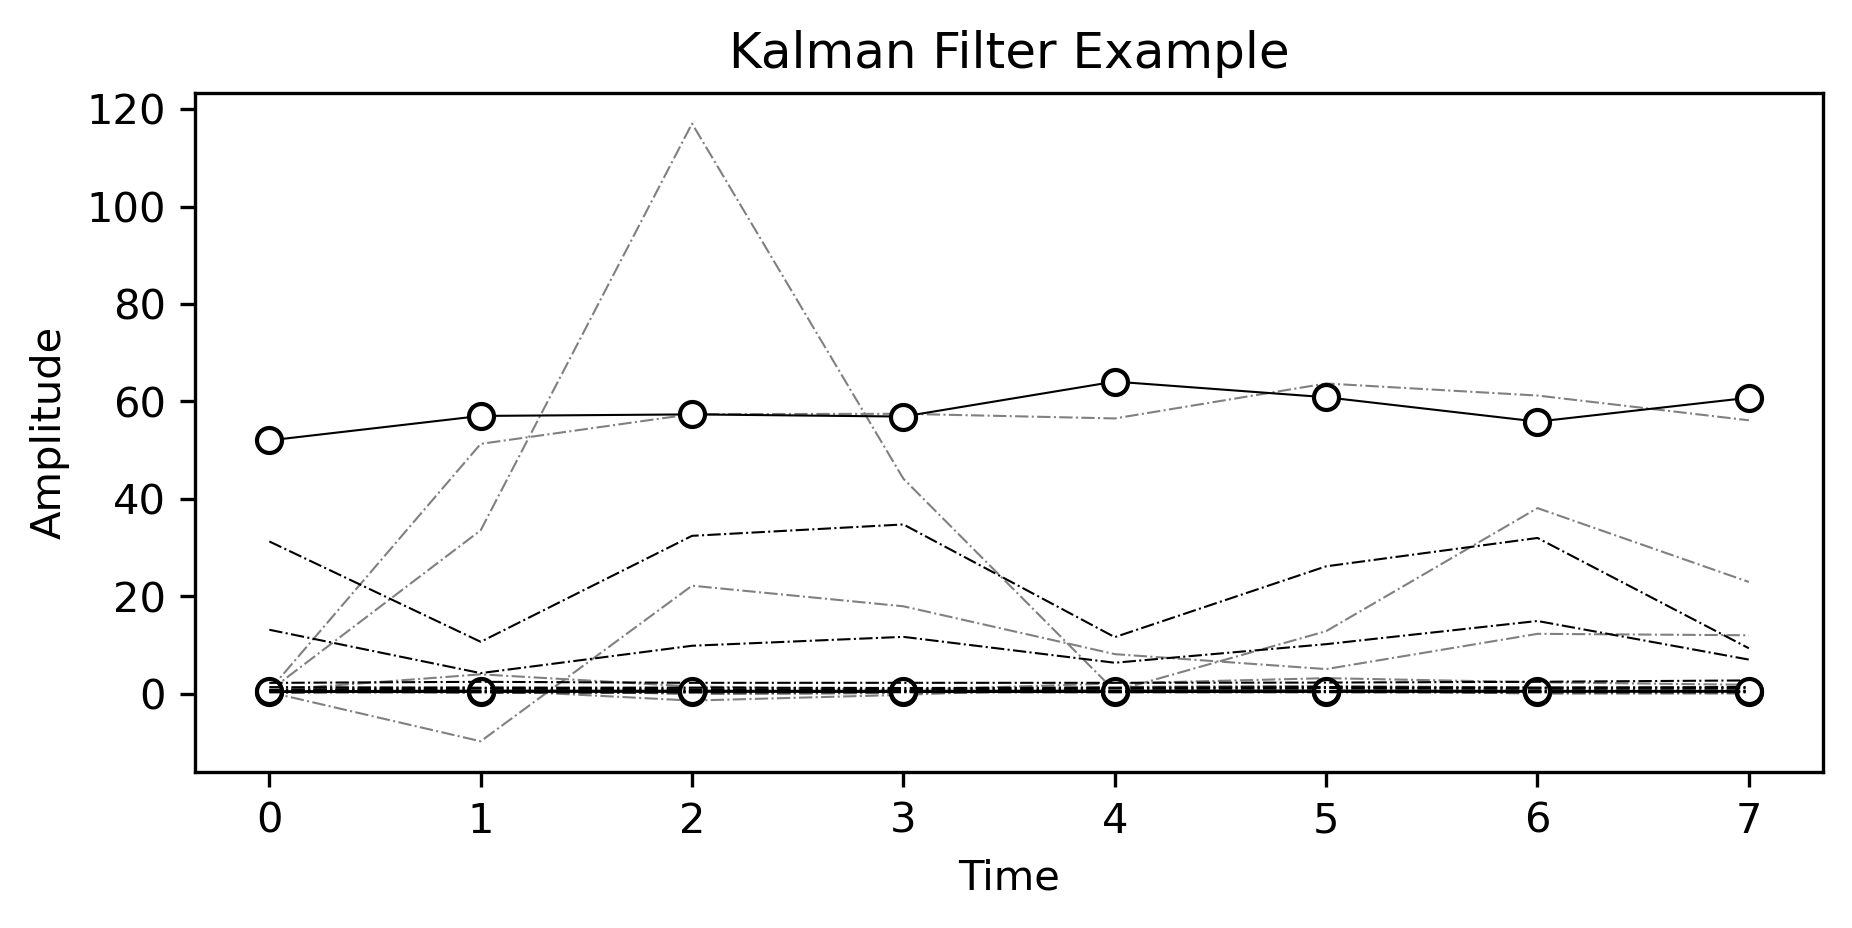

In [391]:
f.x = np.random.rand(A.shape[0])
# apply kalman filter
Xhat = [f.x]
for i in range(trajectory.shape[1]-1):
    f.predict()
    f.update(C @ trajectory[:,i,0])
    Xhat.append(f.x)
    
trajectoriesHat = np.array(Xhat).T
print(trajectoriesHat.shape)
print(trajectory.shape)

trueLine = {'style': '-.',
        'color': 'black',
        'linewidth': 0.5}
predLine = {'style': '-.',
        'color': 'grey',
        'linewidth': 0.5}

sampLine = {'style': '-o',
            'color': 'black',
            'linewidth': 0.5}

trajectoriesHat = np.array(Xhat).T
xrange = np.array(range(trajectory.shape[1]))
i=0
print(len(xrange))
print(len(trajectoriesHat[i,:]))
print(len(trajectory[i,:,1]))
for i in range(n):
    plt.plot(xrange, trajectoriesHat[i,:], predLine['style'], color=predLine['color'], markerfacecolor='white', linewidth=predLine['linewidth'])
for i in range(n):
    if i < C.shape[0]:
        line = sampLine
    else:
        line = trueLine
    plt.plot(xrange, trajectory[i,:,0], line['style'], color=line['color'], markerfacecolor='white', linewidth=line['linewidth'])    
plt.title('Kalman Filter Example')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.show()

(5, 8)
(5, 8, 2)


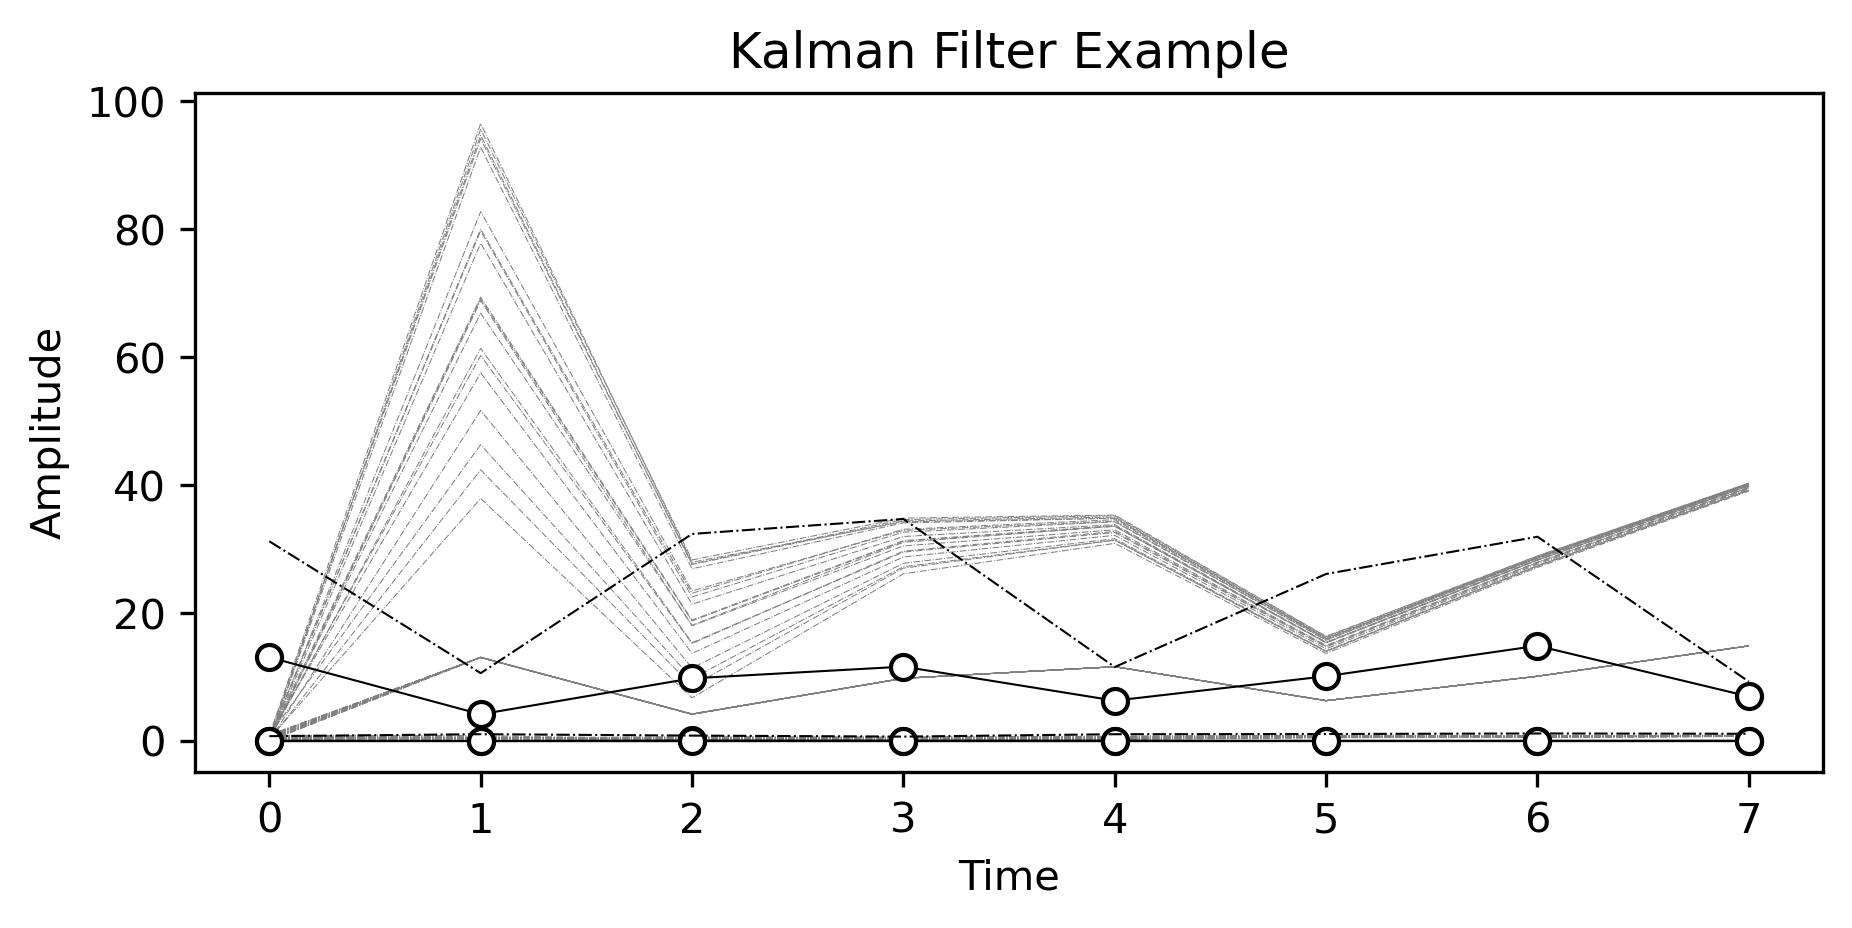

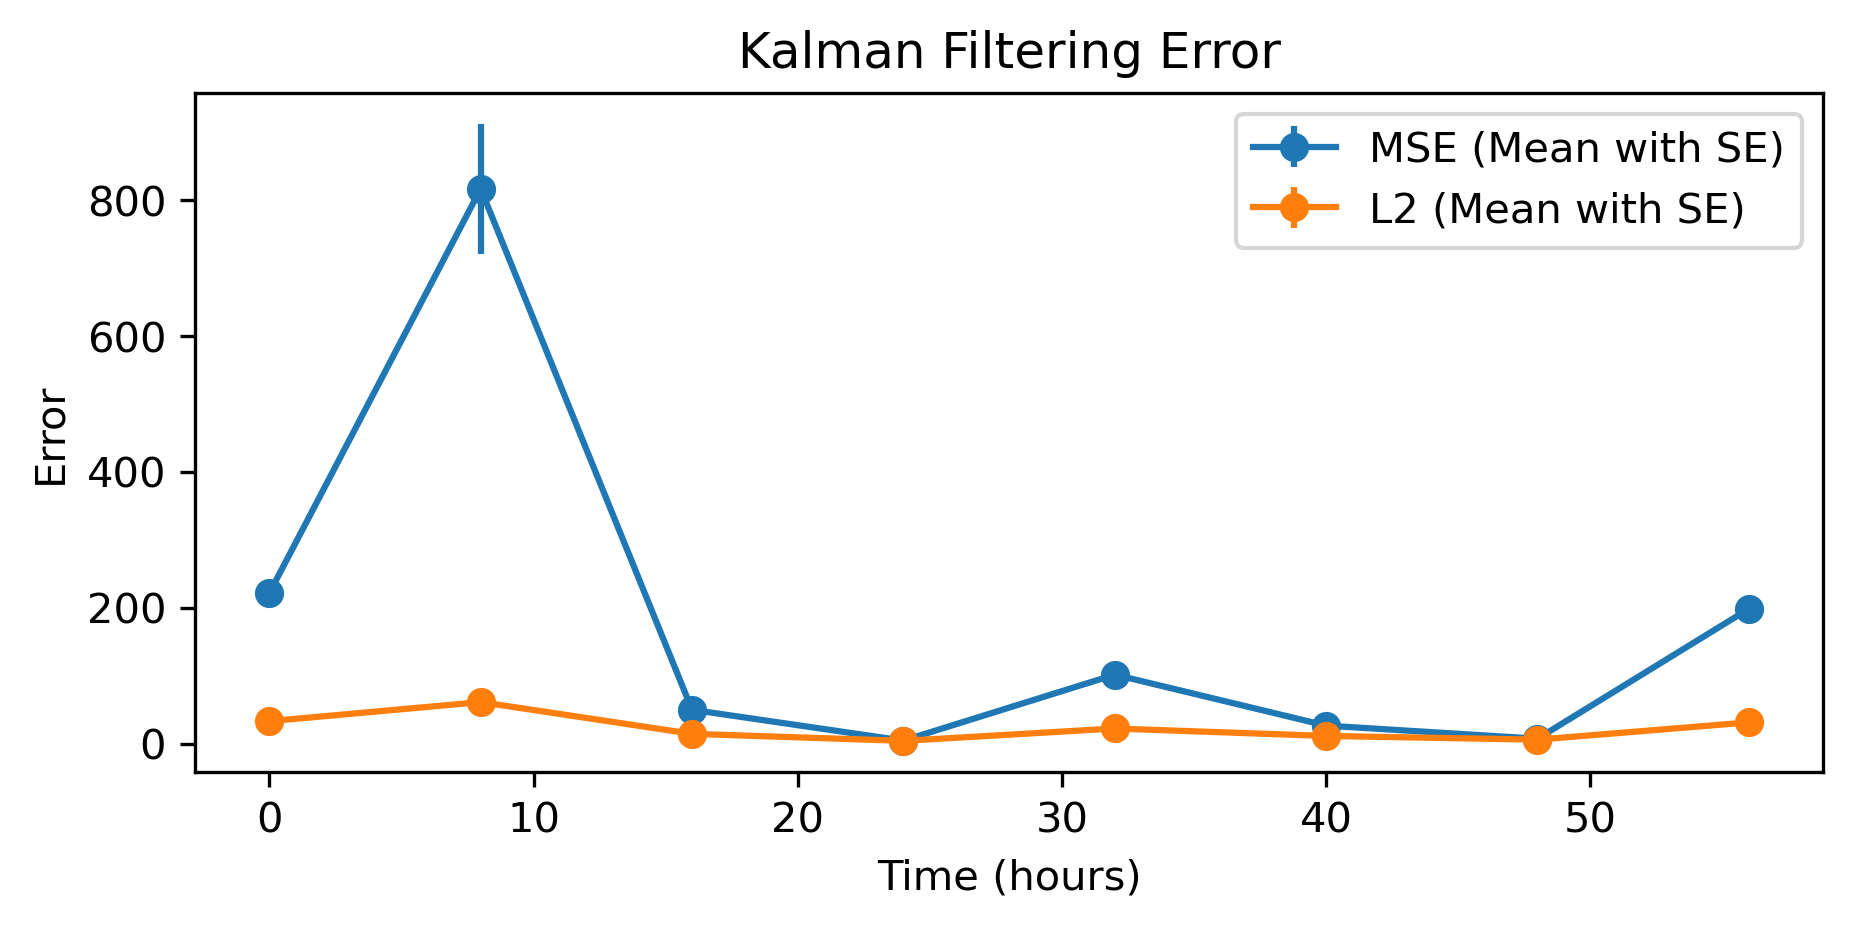

In [386]:
nsims = 20
trajs = []
for i in range(nsims):
    f.x = 1 * np.random.rand(A.shape[0])
    # apply kalman filter
    Xhat = [f.x]
    for i in range(trajectory.shape[1]-1):
        f.predict()
        f.update(C @ trajectory[:,i,0])
        Xhat.append(f.x)
    trajectoriesHat = np.array(Xhat).T
    trajs.append(trajectoriesHat)
    
print(trajectoriesHat.shape)
print(trajectory.shape)

trueLine = {'style': '-.',
        'color': 'black',
        'linewidth': 0.5}
predLine = {'style': '-.',
        'color': 'grey',
        'linewidth': 0.25}
sampLine = {'style': '-o',
            'color': 'black',
            'linewidth': 0.5}

xrange = np.array(range(trajectory.shape[1]))
for j in range(nsims):
    trajectoriesHat = trajs[j]
    for i in range(n):
        plt.plot(xrange, trajectoriesHat[i,:], predLine['style'], color=predLine['color'], markerfacecolor='white', linewidth=predLine['linewidth'])
        
for i in range(n):
    if i < C.shape[0]:
        line = sampLine
    else:
        line = trueLine
    plt.plot(xrange, trajectory[i,:,0], line['style'], color=line['color'], markerfacecolor='white', linewidth=line['linewidth'])    
plt.title('Kalman Filter Example')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.show()

## plot errors
MSE = []
L2 = []
for t in range(trajectory.shape[1]):
    mse = []
    l2 = []
    for i in range(nsims):
        trajectoriesHat = trajs[i]
        mse.append((np.square(trajectory[:,t,0] - trajectoriesHat[:,t])).mean())
        l2.append(np.linalg.norm(trajectory[:,t,0] - trajectoriesHat[:,t]))
    MSE.append(mse)
    L2.append(l2)

MSE = np.array(MSE)
L2 = np.array(L2)

# Calculate mean and standard error for each column
mse_mean_values = np.mean(MSE, axis=1)
mse_std_errors = np.std(MSE, axis=1) / np.sqrt(MSE.shape[1])
l2_mean_values = np.mean(L2, axis=1)
l2_std_errors = np.std(L2, axis=1) / np.sqrt(L2.shape[1])

# Plot the mean values with error bars
xrange = 8 * np.array(range(mse_mean_values.shape[0]))
plt.errorbar(xrange, mse_mean_values, yerr=mse_std_errors, fmt='-o', label='MSE (Mean with SE)')
plt.errorbar(xrange, l2_mean_values, yerr=l2_std_errors, fmt='-o', label='L2 (Mean with SE)')

# Set labels and title
plt.xlabel('Time (hours)')
plt.ylabel('Error')
plt.title('Kalman Filtering Error')

# Show the legend
plt.legend()

# Show the plot
plt.show()

(8, 20)
(8,)


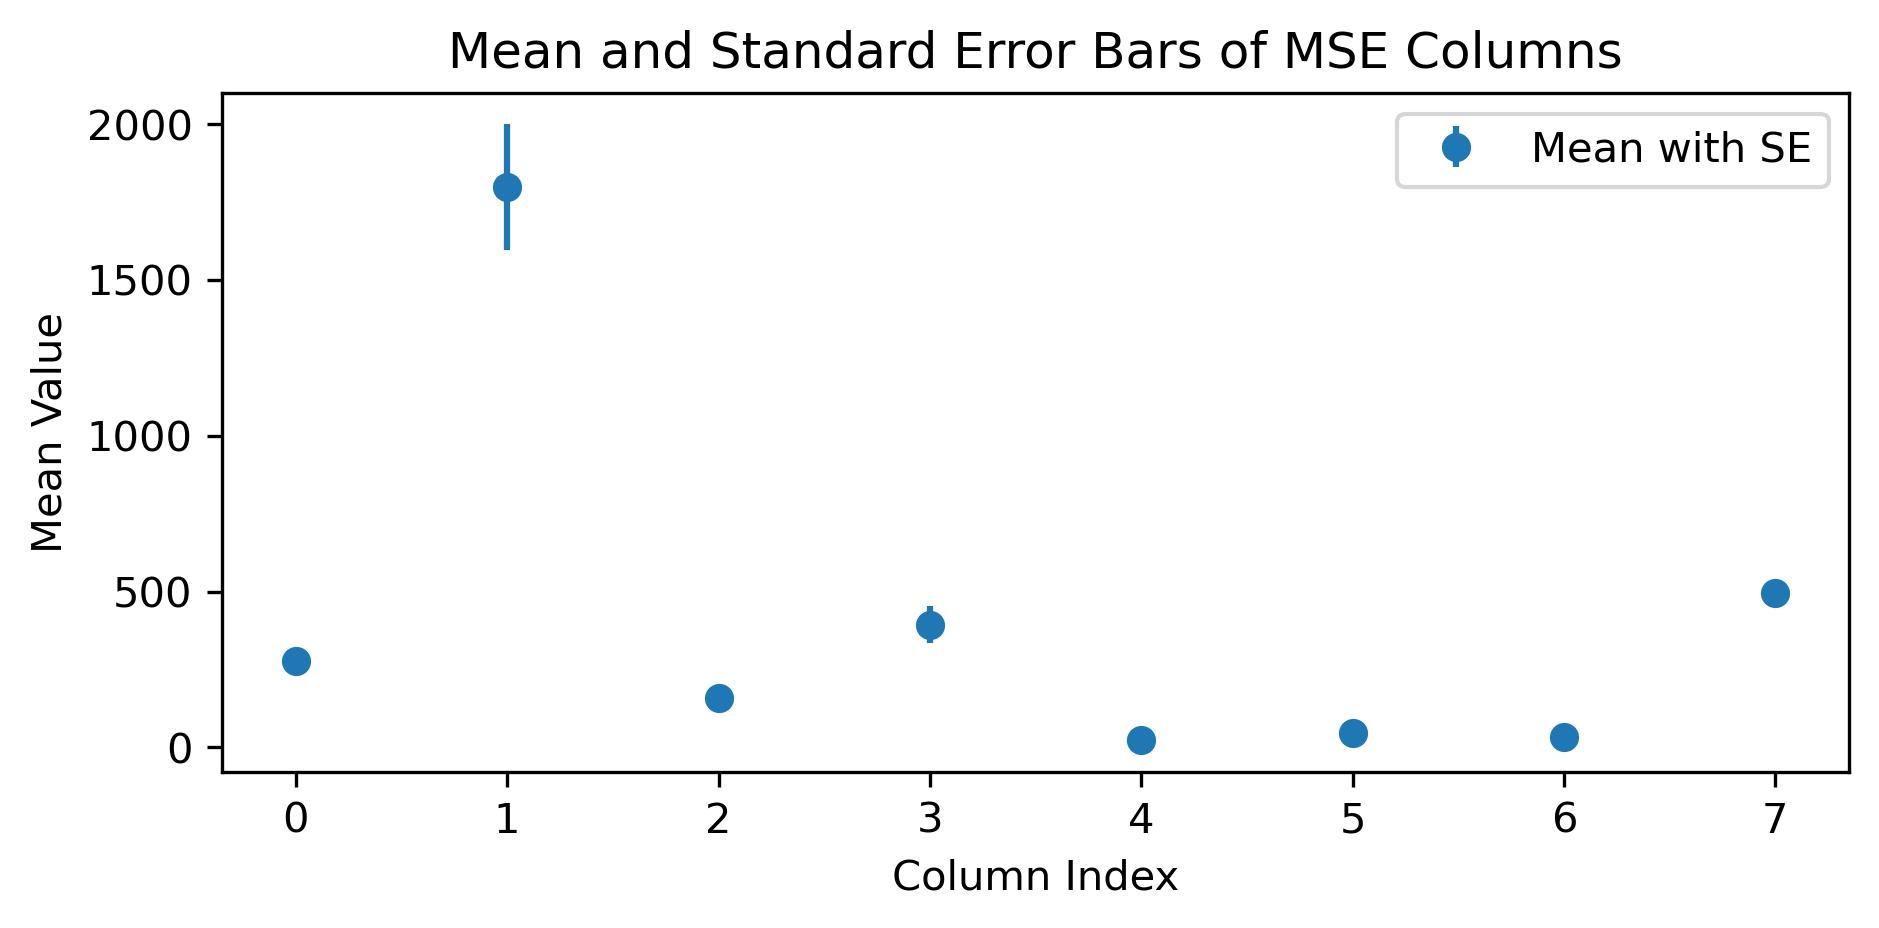

In [370]:
# Calculate mean and standard error for each column
mean_values = np.mean(MSE, axis=1)
std_errors = np.std(MSE, axis=1) / np.sqrt(MSE.shape[1])

print(MSE.shape)
print(mean_values.shape)

# Plot the mean values with error bars
plt.errorbar(range(mean_values.shape[0]), mean_values, yerr=std_errors, fmt='o', label='Mean with SE')

# Set labels and title
plt.xlabel('Column Index')
plt.ylabel('Mean Value')
plt.title('Mean and Standard Error Bars of MSE Columns')

# Show the legend
plt.legend()

# Show the plot
plt.show()

# Cell Tracks

In [461]:
dataPath = '/nfs/turbo/umms-indikar/shared/projects/wound_healing/results/wh3_pipeline_outputs/tracks/'
file = 'C1.tracks.full.csv'
df = pd.read_csv(dataPath + file)
df.columns

Index(['ID', 't', 'x', 'y', 'z', 'parent', 'root', 'state', 'generation',
       'dummy', 'area_x', 'area_y', 'area_convex', 'area_filled',
       'axis_major_length', 'axis_minor_length', 'eccentricity',
       'c0_intensity_max', 'c1_intensity_max', 'c2_intensity_max',
       'c0_intensity_min', 'c1_intensity_min', 'c2_intensity_min',
       'c0_intensity_mean', 'c1_intensity_mean', 'c2_intensity_mean', 'label',
       'prob', 'orientation', 'perimeter', 'solidity', 'circularity',
       'c0_logFoldChange_prepared', 'c1_logFoldChange_prepared',
       'c2_logFoldChange_prepared', 'c0_pval_prepared', 'c1_pval_prepared',
       'c2_pval_prepared', 'c0_logFoldChange_processed',
       'c1_logFoldChange_processed', 'c2_logFoldChange_processed',
       'c0_pval_processed', 'c1_pval_processed', 'c2_pval_processed'],
      dtype='object')

In [462]:
track0 = []
track1 = []
track2 = []
IDs = np.unique(df.ID)
for i in IDs:
    cellDf = df[df['ID'] == i]
    if cellDf.shape[0] < 10:
        continue
    track0.append(cellDf['c0_intensity_mean'].values)
    track1.append(cellDf['c1_intensity_mean'].values)
    track2.append(cellDf['c2_intensity_mean'].values)
    

In [454]:
# cellDf = df[df.index.isin([96])]
# cellDf
# track1

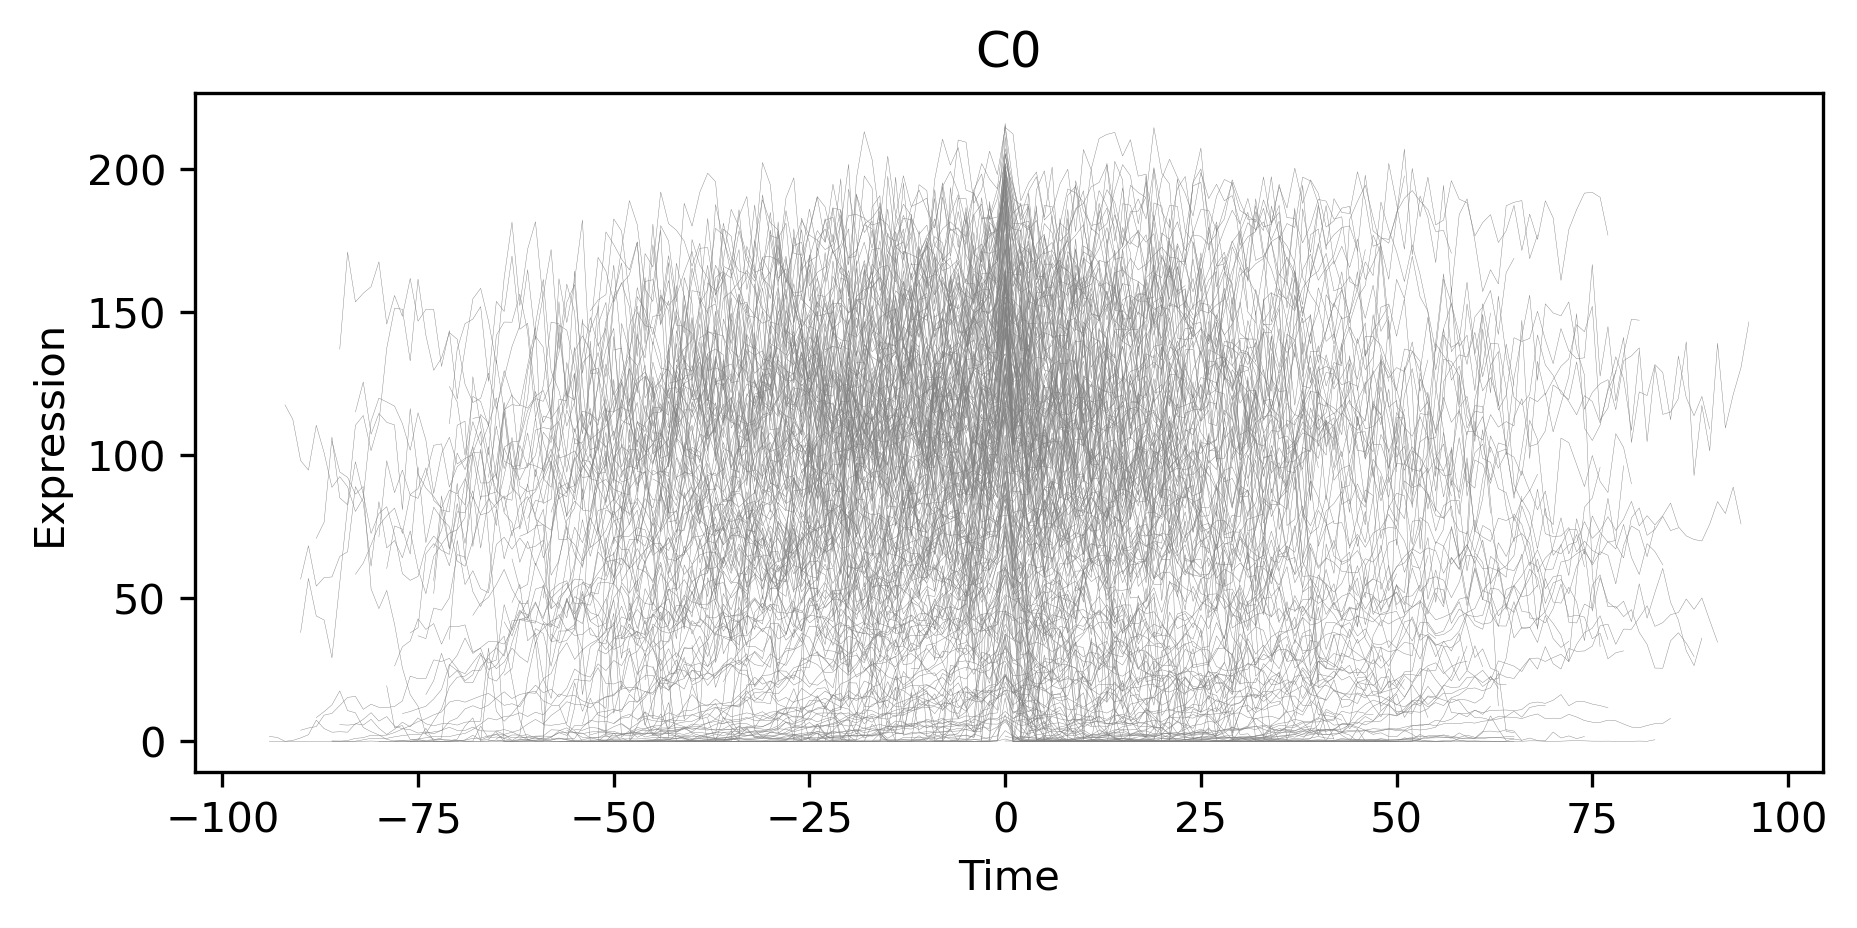

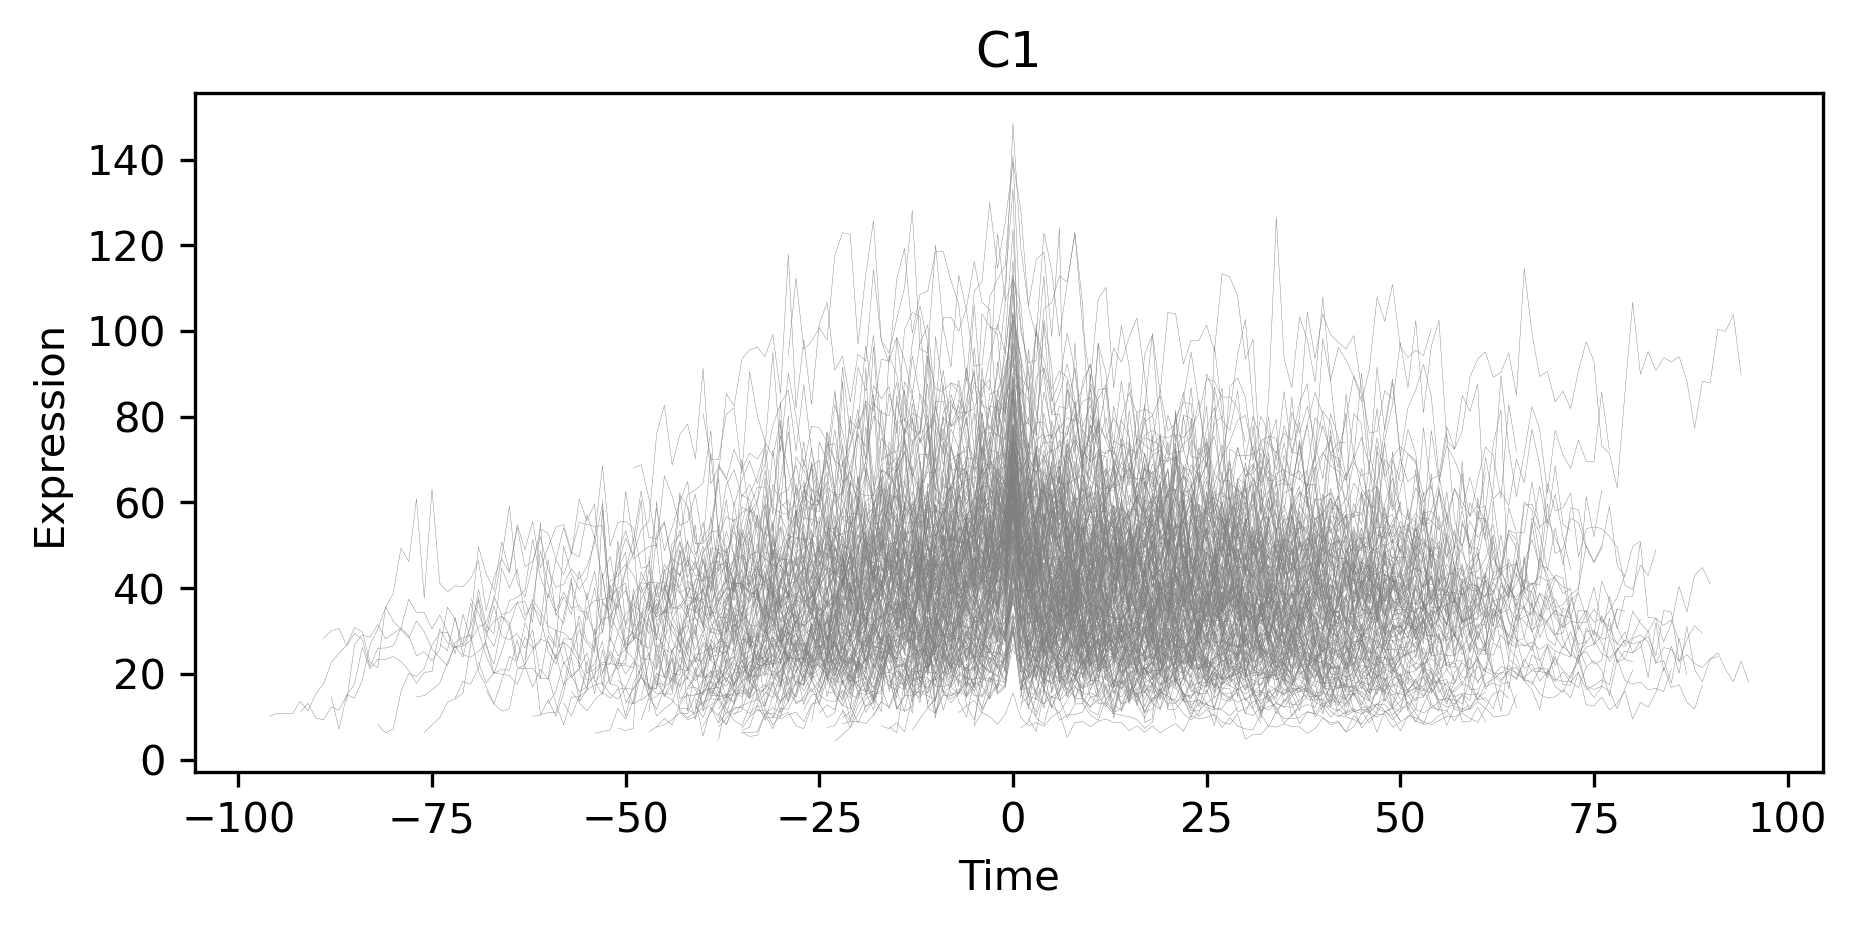

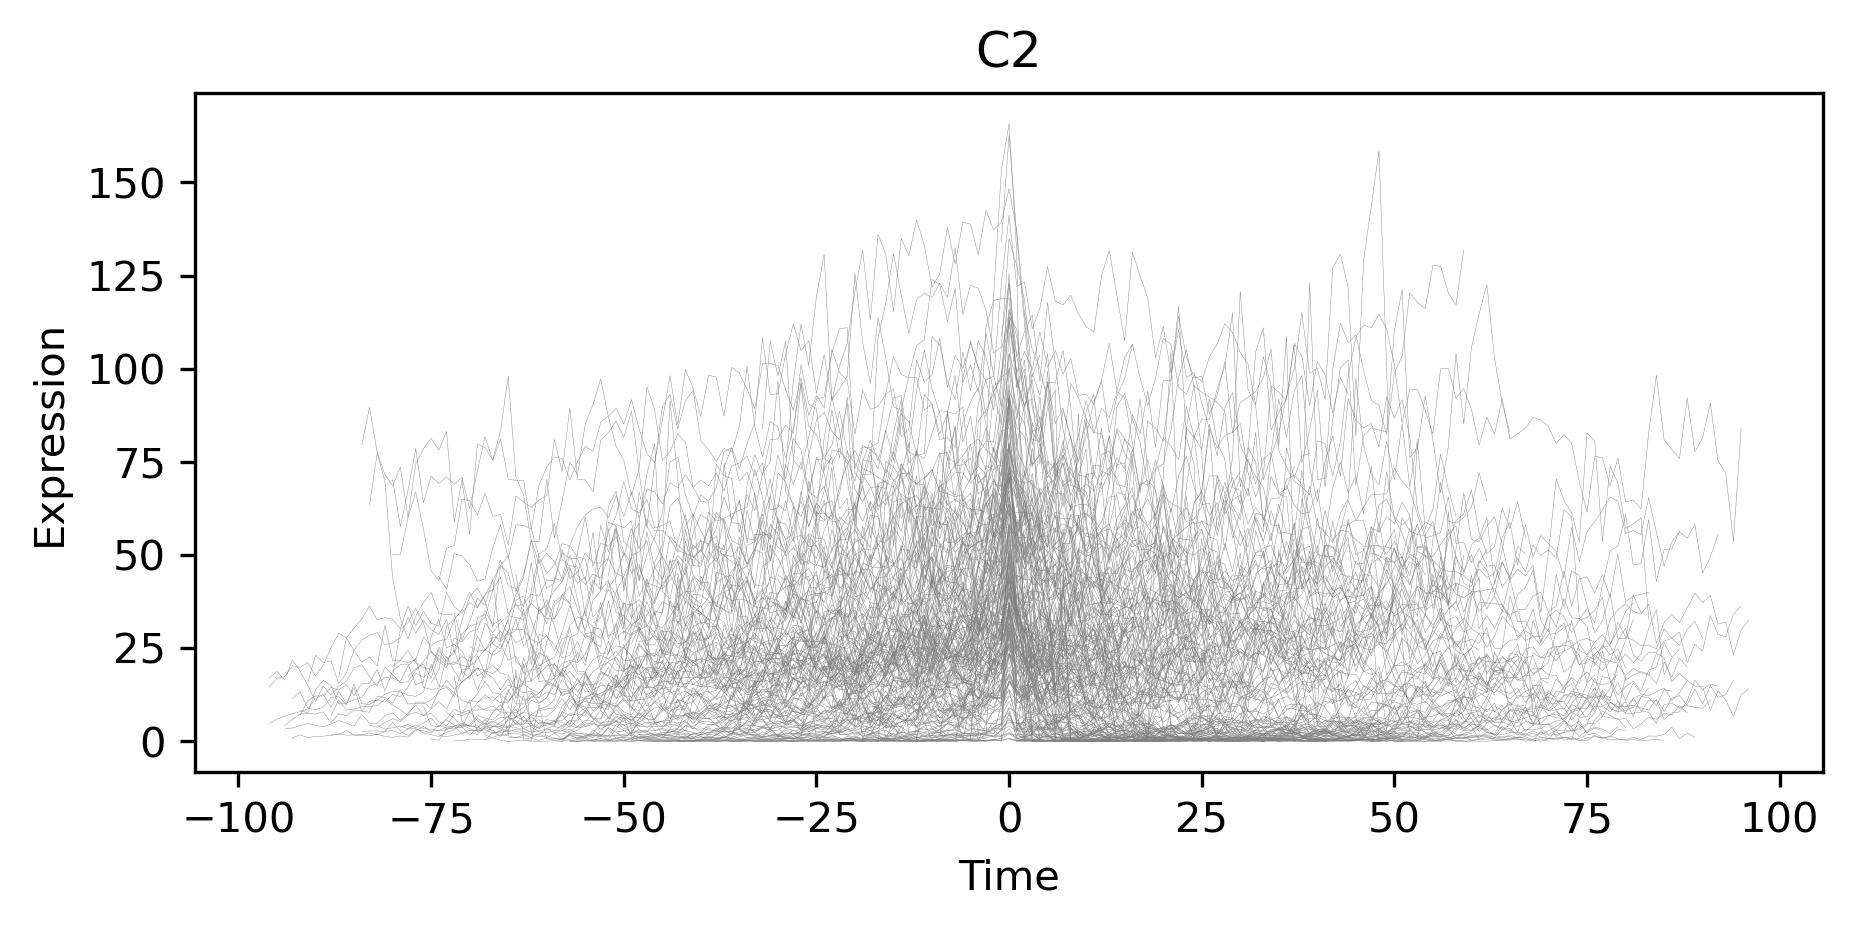

In [463]:
# track0
line = {'linewidth': 0.1}

for i in range(len(track0)):
    track = track0[i]
    if len(track) < 50:
        continue
    maxTime = np.argmax(track)
    xrange = np.arange(-maxTime, len(track) - maxTime)
    plt.plot(xrange, track, linewidth=line['linewidth'], color='grey')
plt.xlabel('Time')
plt.ylabel('Expression')
plt.title('C0')
plt.show()

for i in range(len(track1)):
    track = track1[i]
    if len(track) < 50:
        continue
    maxTime = np.argmax(track)
    xrange = np.arange(-maxTime, len(track) - maxTime)
    plt.plot(xrange, track, linewidth=line['linewidth'], color='grey')
plt.xlabel('Time')
plt.ylabel('Expression')
plt.title('C1')
plt.show()

for i in range(len(track2)):
    track = track2[i]
    if len(track) < 50:
        continue
    maxTime = np.argmax(track)
    xrange = np.arange(-maxTime, len(track) - maxTime)
    plt.plot(xrange, track, linewidth=line['linewidth'], color='grey')
plt.xlabel('Time')
plt.ylabel('Expression')
plt.title('C2')
plt.show()


In [435]:
track

array([-1.25687099])

In [427]:
maxTime = 3
np.arange(-maxTime, 5 - maxTime)

array([-3, -2, -1,  0,  1])

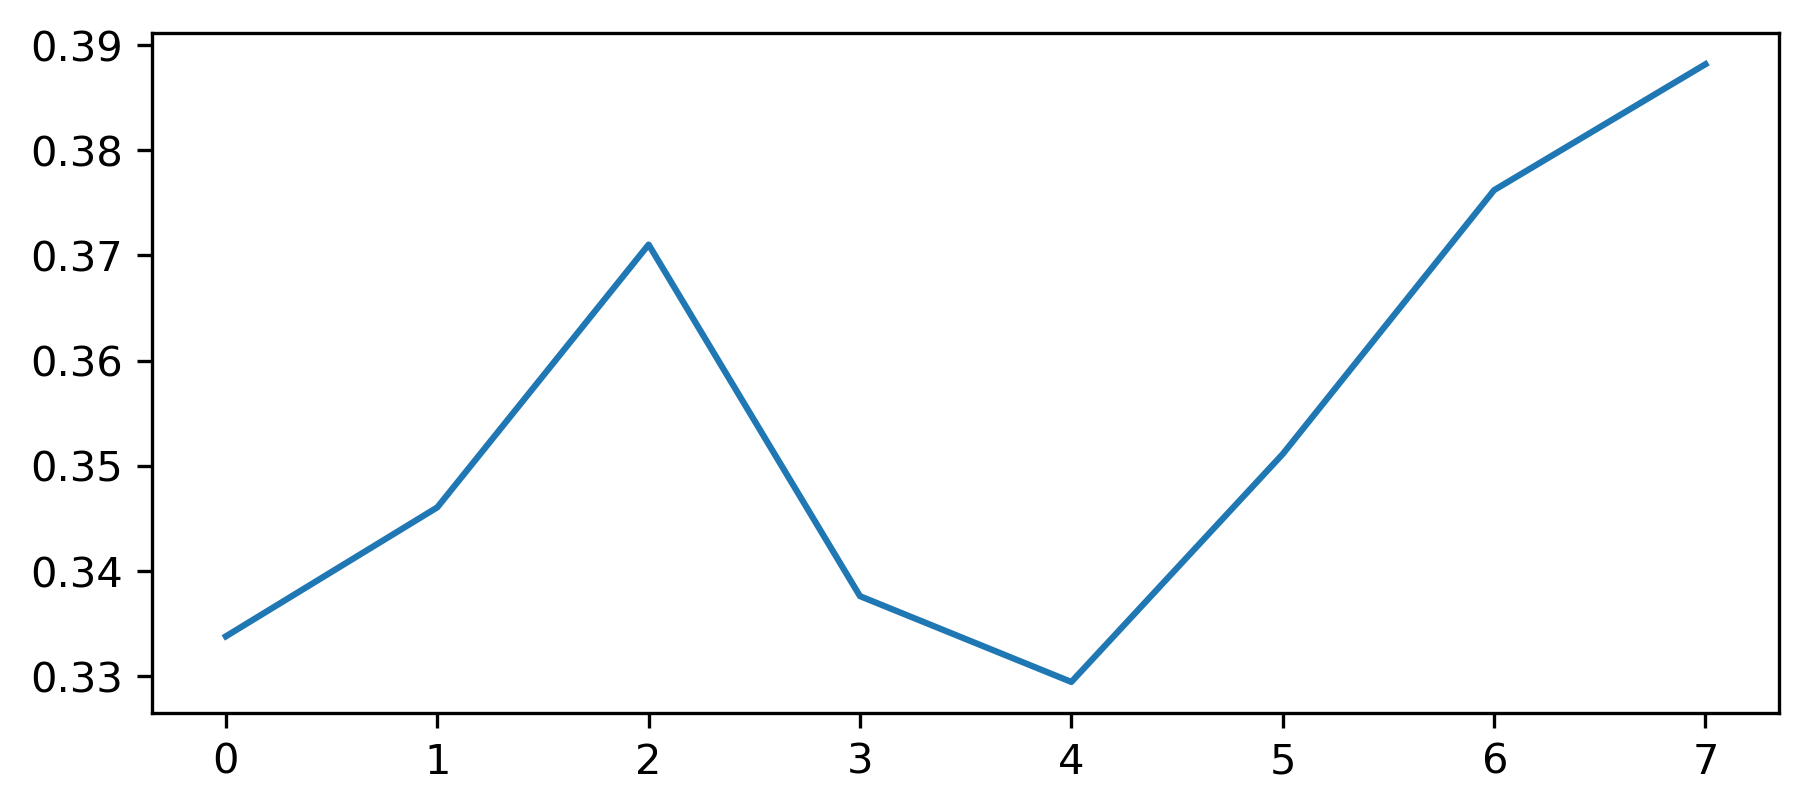

In [419]:
plt.plot(trajectory[0,:,0])

### `filterpy` Kalman Filter Implementation

In [132]:
!pip install filterpy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 1.6 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=f441f9e229c60f33f29b3404c9d7291d0725735604303d66a1c55a1f8cbd58a1
  Stored in directory: /home/jpic/.cache/pip/wheels/53/e6/de/a09ea01e923aaf88b9f8c7c44329e857b2c1a31901167e55e6
Successfully built filterpy
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


(5, 31)
(31,)


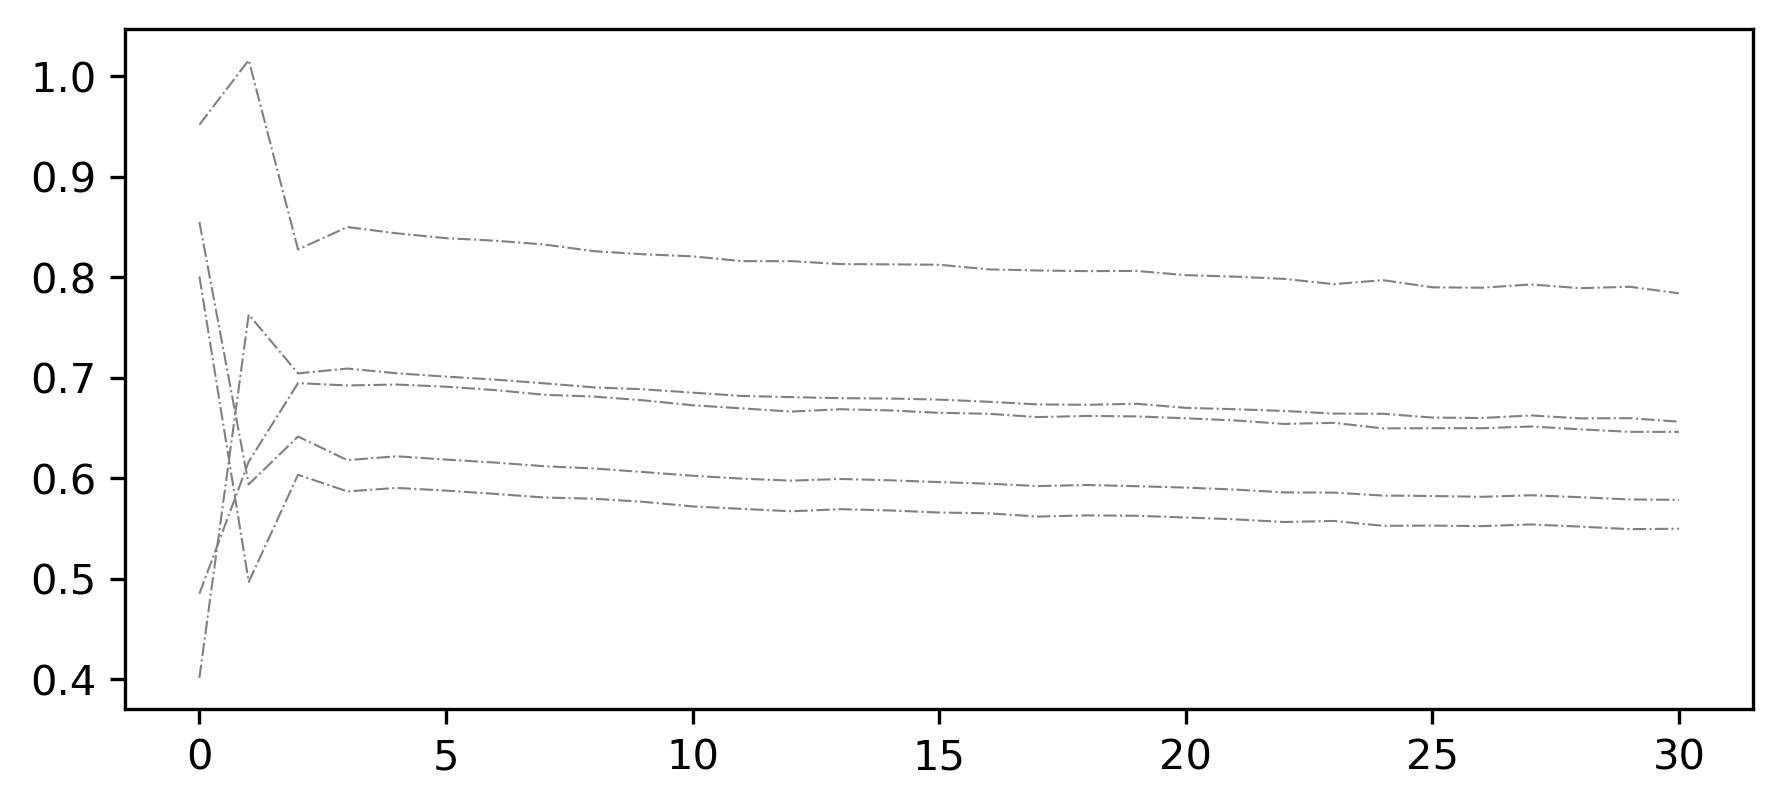

In [259]:
n = 5
T = 30
delta = 0.1
A = np.random.rand(n,n)
A /= np.sum(A,axis=0)
X = [np.random.rand(n)]
dif = 0.01
for i in range(T):
    X.append((1 - dif) * A @ X[-1] + dif * A @ np.random.rand(n) )
line = {'style': '-.',
        'color': 'grey',
        'linewidth': 0.5}
trajectories = np.array(X).T
xrange = np.array(range(T+1))
print(trajectories.shape)
print(xrange.shape)
for i in range(n):
    plt.plot(xrange, trajectories[i,:], line['style'], color=line['color'], markerfacecolor='white', linewidth=line['linewidth'])

In [260]:
# Sensor selection
r = 0
i = 0
while r < n:
    S = np.arange(0, i+1)
    C = getC(n, S)
    O = obsv(A,C)
    r = np.linalg.matrix_rank(O, tol=1e-3)
    i += 1
print(S)

[0 1]


In [261]:
# construct Kalman filter
f = KalmanFilter (dim_x=A.shape[0], dim_z=C.shape[0])
f.F = A
f.H = C
f.P *= 1
f.Q = np.random.rand(A.shape[0], A.shape[0])
f.x = np.random.rand(A.shape[0])
f.x

array([0.69451736, 0.47706136, 0.11395283, 0.62670484, 0.79288337])

In [262]:
# apply kalman filter
Xhat = [f.x]
for i in range(T):
    f.predict()
    f.update(C @ trajectories[:,i])
    Xhat.append(f.x)

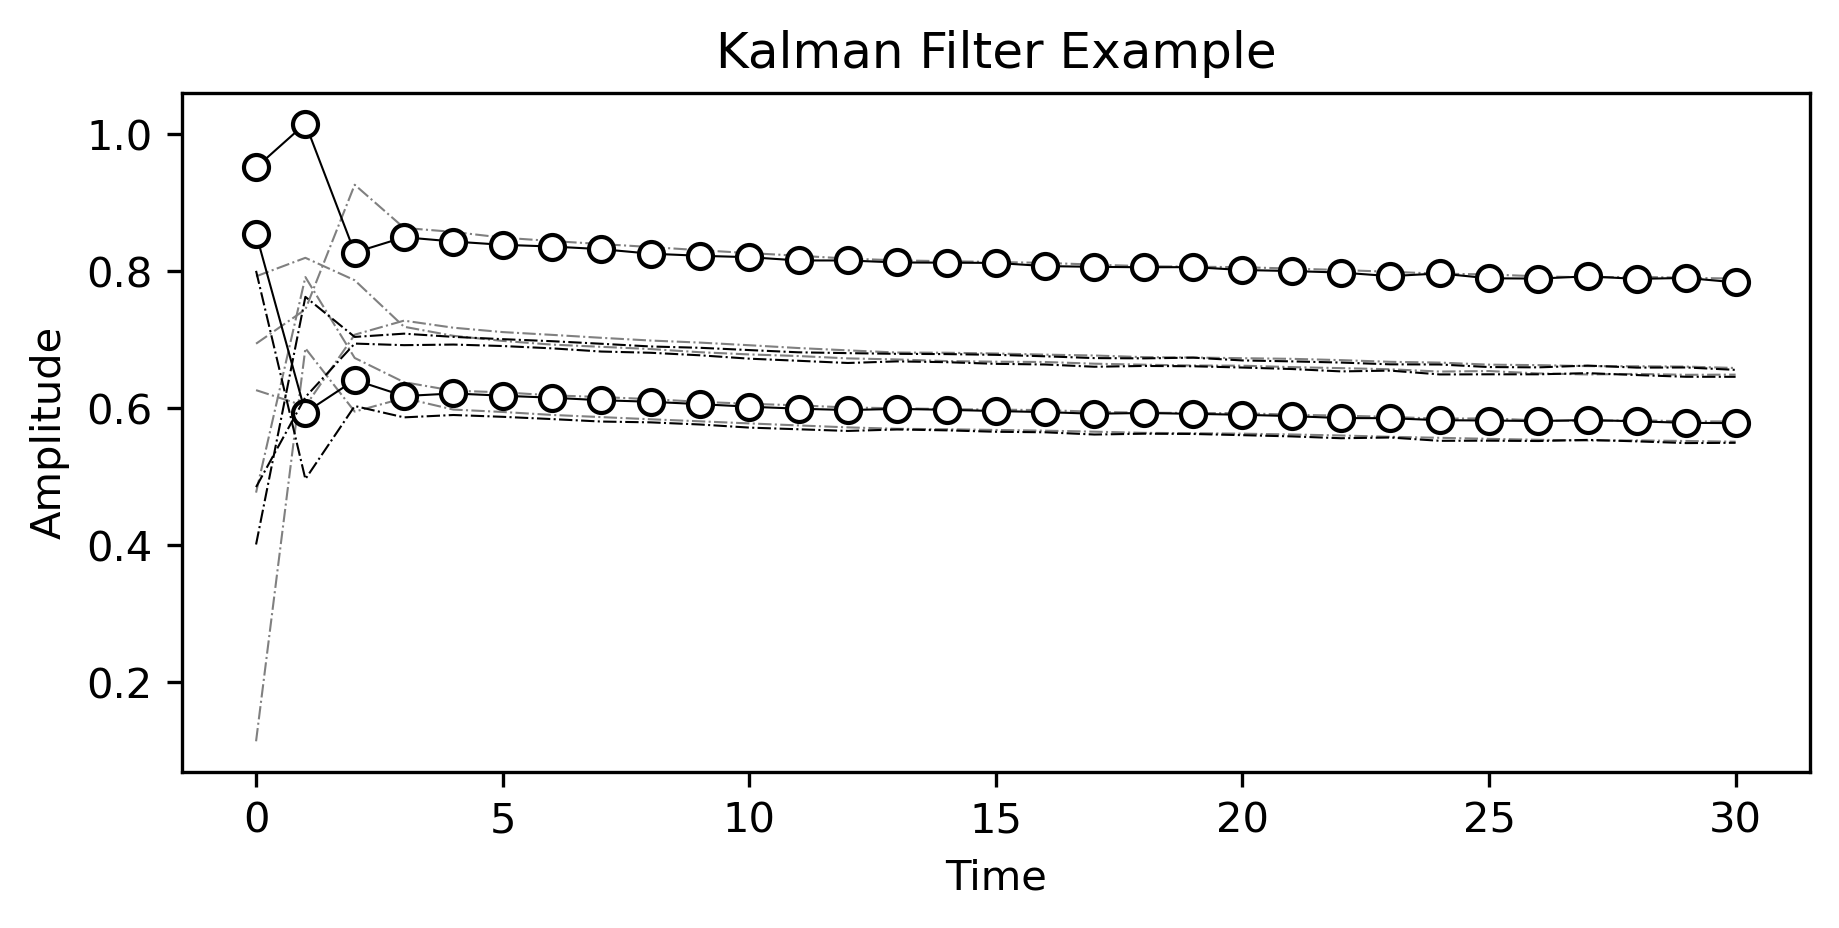

In [269]:
trueLine = {'style': '-.',
        'color': 'black',
        'linewidth': 0.5}
predLine = {'style': '-.',
        'color': 'grey',
        'linewidth': 0.5}

sampLine = {'style': '-o',
            'color': 'black',
            'linewidth': 0.5}

trajectoriesHat = np.array(Xhat).T
xrange = np.array(range(T+1))


for i in range(n):
    plt.plot(xrange, trajectoriesHat[i,:], predLine['style'], color=predLine['color'], markerfacecolor='white', linewidth=predLine['linewidth'])
for i in range(n):
    if i < C.shape[0]:
        line = sampLine
    else:
        line = trueLine
    plt.plot(xrange, trajectories[i,:], line['style'], color=line['color'], markerfacecolor='white', linewidth=line['linewidth'])    
plt.title('Kalman Filter Example')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.show()

Text(0.5, 1.0, 'Kalman Filter Convergence')

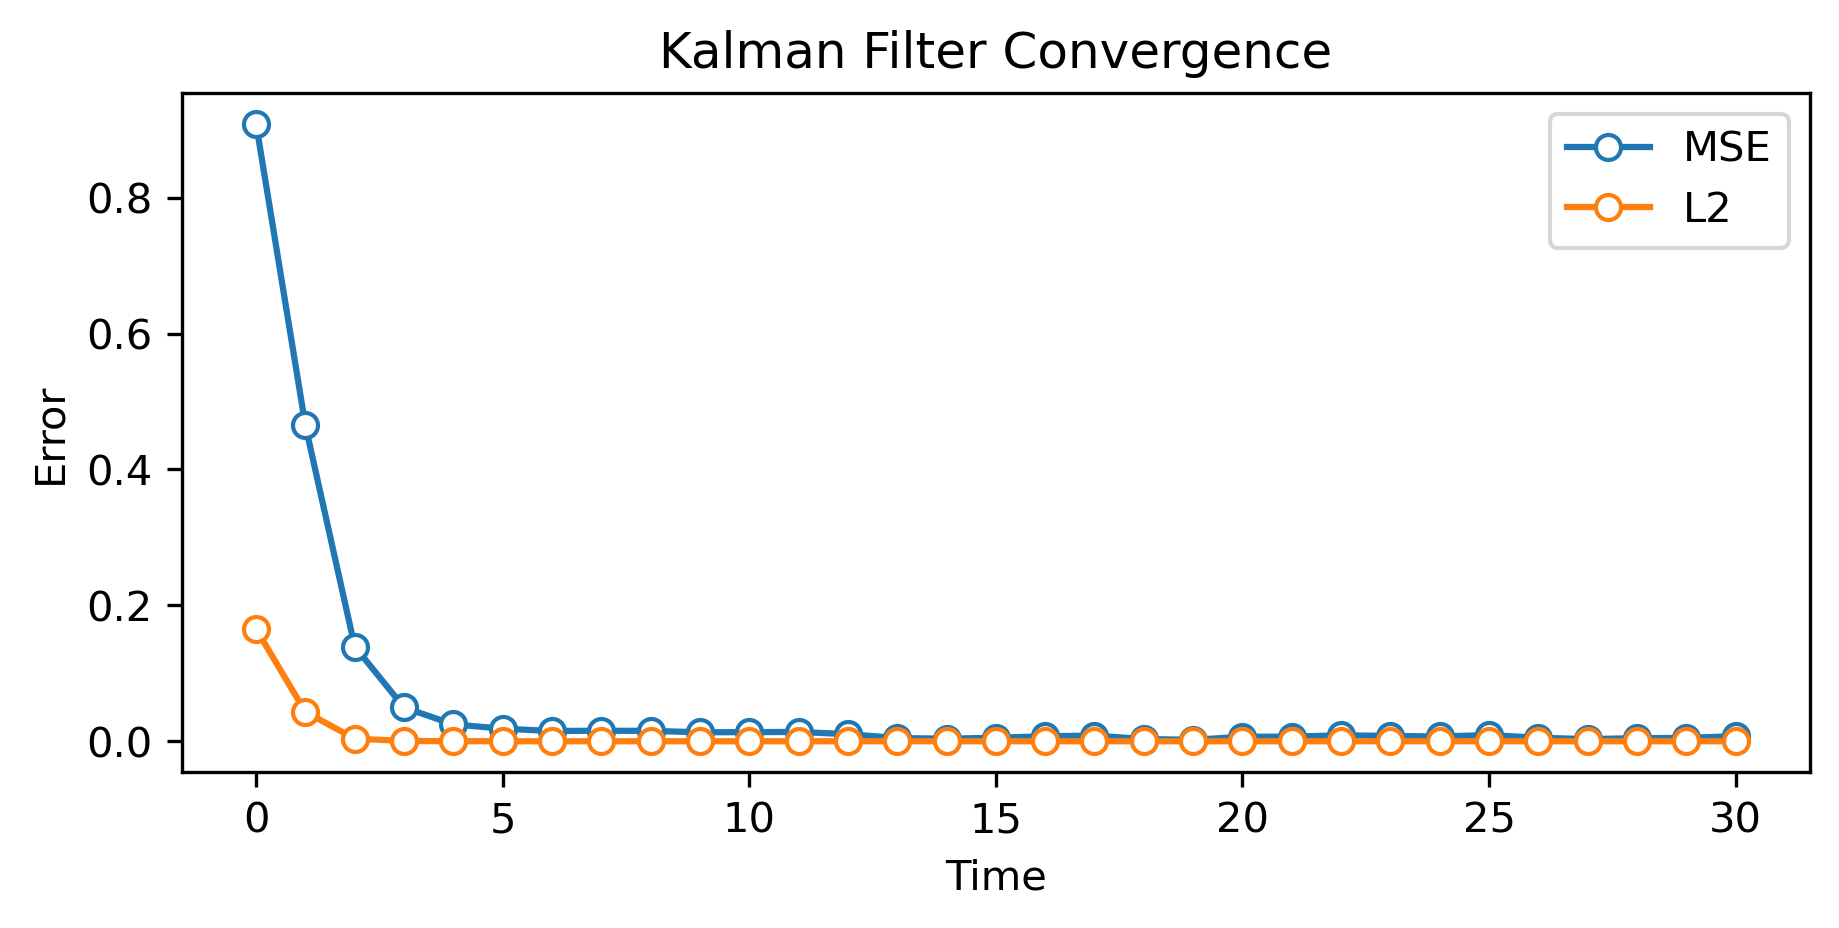

In [264]:
# Evaluate the error of the kalman filter
mse = []
l2 = []
for i in range(T+1):
    mse.append((np.square(trajectories[:,i] - trajectoriesHat[:,i])).mean())
    l2.append(np.linalg.norm(trajectories[:,i] - trajectoriesHat[:,i]))
    
plt.plot(xrange, l2, '-o', markerfacecolor='white')
plt.plot(xrange, mse, '-o', markerfacecolor='white')
plt.legend(['MSE', 'L2'])
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Kalman Filter Convergence')

In [221]:
trajectories[:,i].shape

(8,)

In [222]:
C.shape

(2, 8)

In [224]:
(C @ trajectories[:,i]).shape

(2,)

In [209]:
O

matrix([[1.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.14174299, 0.04404883, 0.06614207, 0.0859766 , 0.13792242,
         0.1062827 , 0.10672821, 0.20077899],
        [0.11606191, 0.13124213, 0.110255  , 0.11275287, 0.11770186,
         0.08864935, 0.10106363, 0.11643815],
        [0.11276099, 0.11361287, 0.10918343, 0.11023504, 0.11493338,
         0.11324299, 0.10759645, 0.11303449],
        [0.11244281, 0.11229708, 0.11119416, 0.11210734, 0.1117617 ,
         0.11193381, 0.11127882, 0.11212655],
        [0.11195348, 0.11207626, 0.11167412, 0.11188277, 0.11184653,
         0.11199458, 0.11181669, 0.11193636],
        [0.11191717, 0.11193658, 0.11184137, 0.11189756, 0.11187742,
         0.11195385, 0.11189358, 0.11188281],
        [0.11190348, 0.11190215, 0.11188766, 0.11190104, 0.11188864,
         0.11191767, 0.11190566, 0.11189463]])

In [13]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

In [162]:
f = KalmanFilter (dim_x=dmd_res['A'].shape[0], dim_z=3)
f.F = dmd_res['A']
f.H = C
f.P *= 1000
f.Q = np.random.rand(dmd_res['A'].shape[0],dmd_res['A'].shape[0])
f.x = np.random.rand(dmd_res['A'].shape[0])
f.x

array([0.58459127, 0.11674678, 0.59980845, 0.17543212, 0.42910971,
       0.15628442, 0.54320949, 0.05535951, 0.72825977, 0.40397995,
       0.22438526, 0.65232658, 0.92093134, 0.05983389, 0.526626  ,
       0.27224154, 0.57606562])

In [150]:
f.x = np.random.rand(len(genes))
f.x

array([0.13272538, 0.63107647, 0.59355667, 0.77125262, 0.04764473,
       0.09065948, 0.46261453, 0.89124647, 0.6021608 , 0.45363009,
       0.28869889, 0.09291984, 0.20277747, 0.27720206, 0.69739391,
       0.61071148, 0.44663763, 0.86001752])

In [175]:
X = [f.x]
t = 20
for i in range(t):
    f.predict()
    X.append(f.x)
X = np.array(X)
print(X.shape)
xrange = 1 * np.array(range(t+1))
print(xrange.shape)

(21, 17)
(21,)


IndexError: index 17 is out of bounds for axis 1 with size 17

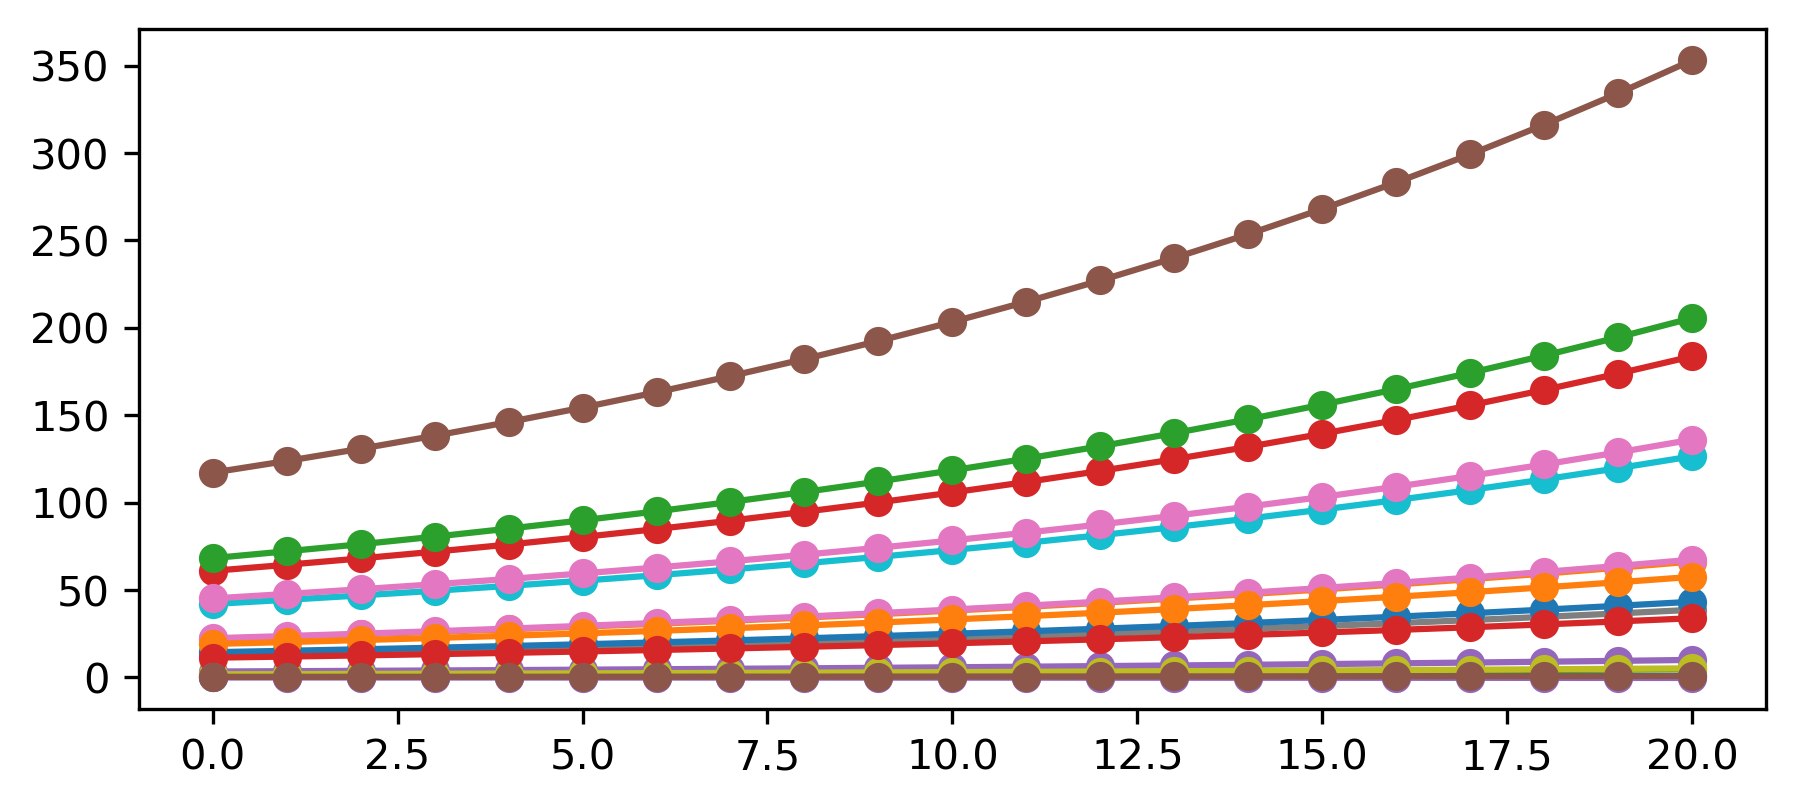

In [176]:
for i in range(X.shape[0]):
    plt.plot(xrange, X[:,i], '-o')

In [159]:
print(f.P.shape)
print(f.F.shape)
print(f.Q.shape)


(17, 17)
(17, 17)
(2, 2)


### Implementing a Kalman Filter

In [130]:
def kalman_filter(A, C, Q, R, x0, P0, measurements):
    """
    Kalman filter implementation for estimation.

    Parameters:
    - A: State transition matrix
    - C: Observation matrix
    - Q: Process noise covariance matrix
    - R: Measurement noise covariance matrix
    - x0: Initial state estimate
    - P0: Initial error covariance matrix
    - measurements: List of measurements over time

    Returns:
    - est_states: List of estimated states
    """

    # Initialization
    est_states = [x0]
    P = P0

    # Kalman filter loop
    for measurement in measurements:
        # Prediction step
        x_pred = A @ est_states[-1]
        P_pred = A @ P @ A.T + Q

        # Update step
        K = P_pred @ C.T @ np.linalg.inv(C @ P_pred @ C.T + R)
        x_update = x_pred + K @ (measurement - C @ x_pred)
        P_update = (np.eye(A.shape[0]) - K @ C) @ P_pred

        # Save estimated state
        est_states.append(x_update)

        # Update P for the next iteration
        P = P_update

    return est_states

# Scratch

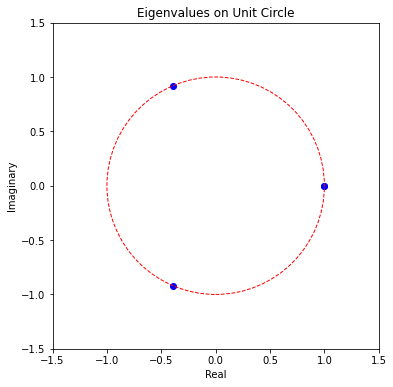

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming dmd_res['A'] is your matrix containing eigenvalues
eigenvalues = np.linalg.eigvals(dmd_res['A'])

# Plot the eigenvalues on the unit circle
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(np.cos(np.angle(eigenvalues)), np.sin(np.angle(eigenvalues)), color='blue', marker='o')

# Plot the unit circle
circle = plt.Circle((0, 0), 1, fill=False, color='red', linestyle='dashed')
ax.add_patch(circle)

# Set aspect ratio to 'equal' for a circular plot
ax.set_aspect('equal', adjustable='box')

# Set axis limits
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])

# Set labels and title
ax.set_xlabel('Real')
ax.set_ylabel('Imaginary')
ax.set_title('Eigenvalues on Unit Circle')

# Show the plot
plt.show()


In [43]:
eigenvalues

array([-0.37228132,  5.37228132])

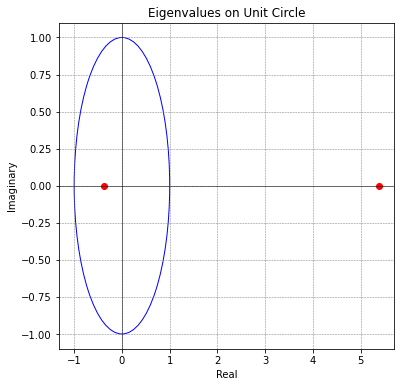

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming dmd_res['A'] contains your matrix
# Replace this with your actual matrix
A = np.array([[1, 2],
              [3, 4]])

# Compute eigenvalues of the matrix
eigenvalues, eigenvectors = np.linalg.eig(A)

# Plot the eigenvalues on the complex plane (unit circle)
plt.figure(figsize=(6, 6))  # Adjust the figure size as needed
plt.scatter(np.real(eigenvalues), np.imag(eigenvalues), color='red', marker='o')

# Plot the unit circle
unit_circle = plt.Circle((0, 0), 1, fill=False, color='blue')
plt.gca().add_patch(unit_circle)

# Set plot attributes
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Eigenvalues on Unit Circle')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

# Show the plot
plt.show()


In [34]:
dmd_res['A'][0,0]

0.0

Text(0.5, 0, 'Time (hours)')

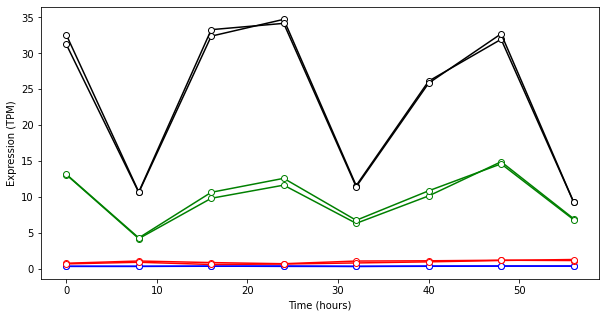

In [28]:
xrange = 8 * np.array(range(8))
plt.figure(figsize=(10,5))
plt.plot(xrange, outputSignals[0,:,0], '-o', color='blue', markerfacecolor='white')
plt.plot(xrange, outputSignals[0,:,1], '-o', color='blue', markerfacecolor='white')
plt.plot(xrange, outputSignals[1,:,0], '-o', color='green', markerfacecolor='white')
plt.plot(xrange, outputSignals[1,:,1], '-o', color='green', markerfacecolor='white')
plt.plot(xrange, outputSignals[2,:,0], '-o', color='red', markerfacecolor='white')
plt.plot(xrange, outputSignals[2,:,1], '-o', color='red', markerfacecolor='white')
plt.plot(xrange, outputSignals[3,:,0], '-o', color='black', markerfacecolor='white')
plt.plot(xrange, outputSignals[3,:,1], '-o', color='black', markerfacecolor='white')

plt.ylabel('Expression (TPM)')
plt.xlabel('Time (hours)')

TypeError: view_init() takes from 1 to 3 positional arguments but 4 were given

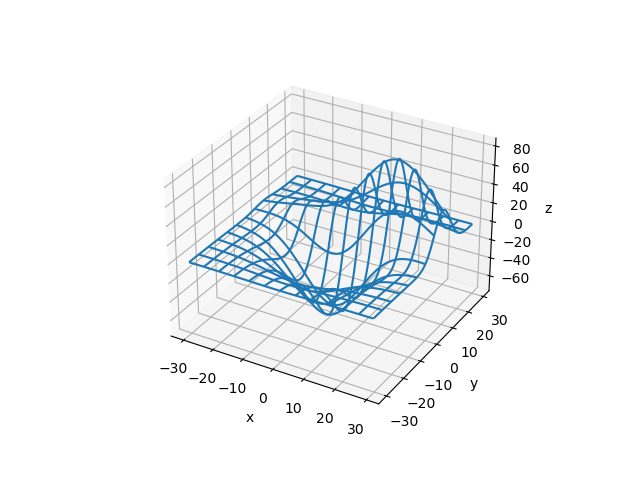

In [65]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Grab some example data and plot a basic wireframe.
X, Y, Z = axes3d.get_test_data(0.05)
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

# Set the axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# Rotate the axes and update
for angle in range(0, 360*4 + 1):
    # Normalize the angle to the range [-180, 180] for display
    angle_norm = (angle + 180) % 360 - 180

    # Cycle through a full rotation of elevation, then azimuth, roll, and all
    elev = azim = roll = 0
    if angle <= 360:
        elev = angle_norm
    elif angle <= 360*2:
        azim = angle_norm
    elif angle <= 360*3:
        roll = angle_norm
    else:
        elev = azim = roll = angle_norm

    # Update the axis view and title
    ax.view_init(elev, azim, roll)
    plt.title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))

    plt.draw()
    plt.pause(.001)

In [51]:
outputSignals[2,:,0]

array([1.29468456, 1.33981024, 1.35946773, 1.34225177, 1.22501951,
       1.32129545, 1.26658946, 1.01826179])

In [31]:
# 2015 cell cycle data
sensorGenes = ['PCNA','CDT1','GEM']
idxs = [gene_names_2015.index(e) for i, e in enumerate(sensorGenes) if e in gene_names_2015]
output = tpm_2015.values[idxs,:]
tpm_2015['geneName']
#for i in idxs:   print(gene_names_2015[i])

KeyError: 'geneName'

In [29]:
tpm_2015

S1a       S1b        S2a        S2b       S3a       S3b  \
geneName                                                                 
A1BG      0.204405  0.082987   0.067885   0.118756  0.025705  0.075546   
A1CF      0.000000  0.000000   0.000000   0.000000  0.000000  0.000000   
A2M       0.000000  0.000000   0.000000   0.004518  0.000000  0.000000   
A2ML1     0.000000  0.000000   0.000000   0.000000  0.000000  0.000000   
A3GALT2   0.000000  0.000000   0.000000   0.000000  0.000000  0.000000   
...            ...       ...        ...        ...       ...       ...   
ZYG11A    0.763658  0.770391   0.929159   0.957368  1.197200  1.180820   
ZYG11B    0.360814  0.430915   0.428591   0.383907  0.457626  0.459731   
ZYX       9.175940  9.489181  10.591246  10.304469  8.480236  8.542316   
ZZEF1     0.933090  0.942053   0.957160   0.983277  0.828198  0.781885   
ZZZ3      0.526726  0.536046   0.628820   0.631078  0.656203  0.644582   

               S4a       S4b       S5a       S5b       S6a        S6b  \
geneName                                                                
A1BG      0.101598  0.042542  0.082680  0.067470  0.081021   0.079350   
A1CF      0.000000  0.000000  0.000000  0.000000  0.000000   0.001530   
A2M       0.000000  0.000000  0.000000  0.000000  0.002774   0.000000   
A2ML1     0.000000  0.001831  0.000000  0.000000  0.000000   0.000000   
A3GALT2   0.000000  0.000000  0.000000  0.000000  0.000000   0.000000   
...            ...       ...       ...       ...       ...        ...   
ZYG11A    0.767954  0.640238  0.836086  0.874314  0.970330   1.018203   
ZYG11B    0.492860  0.503746  0.450900  0.381484  0.393992   0.427725   
ZYX       6.884274  6.822229  8.777100  9.395008  9.827026  10.081423   
ZZEF1     0.796802  0.806577  0.945842  0.932690  0.809867   0.840777   
ZZZ3      0.618359  0.563229  0.586142  0.575832  0.565655   0.591070   

               S7a       S7b       S8a       S8b       S9a       S9b  
geneName                                                              
A1BG      0.059601  0.043645  0.068562  0.083873  0.071520  0.041951  
A1CF      0.002872  0.000000  0.003304  0.000000  0.000000  0.000000  
A2M       0.002551  0.000000  0.000000  0.000000  0.000000  0.004788  
A2ML1     0.000000  0.001879  0.000000  0.000000  0.000000  0.000000  
A3GALT2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
...            ...       ...       ...       ...       ...       ...  
ZYG11A    0.781311  0.765154  0.752155  0.845052  0.987973  1.032302  
ZYG11B    0.437204  0.442461  0.385681  0.443812  0.394949  0.410307  
ZYX       7.042249  7.602863  7.665538  8.567518  8.698902  8.207962  
ZZEF1     0.876118  0.837086  0.929687  0.893738  0.781840  0.840677  
ZZZ3      0.588741  0.615817  0.608945  0.609779  0.655609  0.559248  

[19235 rows x 18 columns]

In [24]:
tpm_2015[int(idxs),:]

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'

In [58]:
#!pip3 install ipympl
!pip install ipympl


Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [59]:
# for creating a responsive plot
%matplotlib widget

# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


In [64]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyter-matplotlib


An error occurred.
ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
See the log file for details:  /tmp/jupyterlab-debug-xd3_tj_a.log


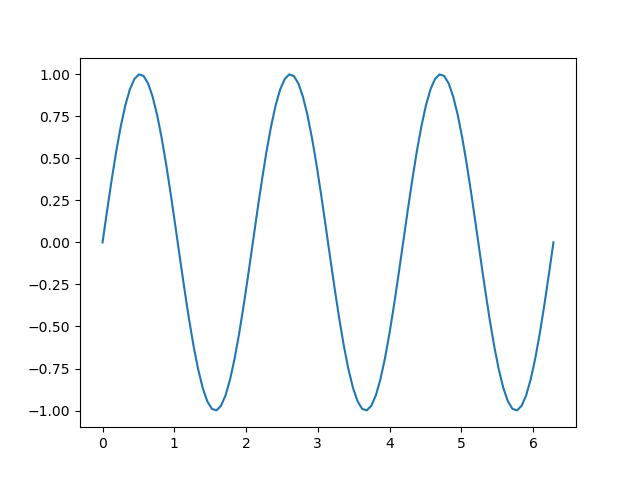

In [61]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()


x = np.linspace(0, 2*np.pi, 100)
y = np.sin(3*x)
ax.plot(x, y)

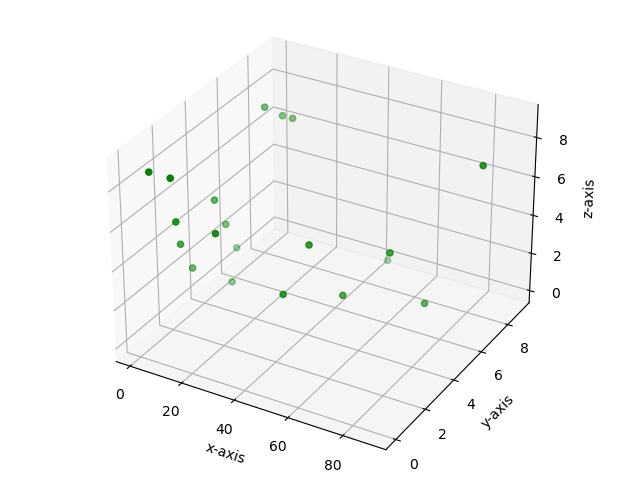

In [60]:
# creating 3d plot using matplotlib 
# in python
# creating random dataset
xs = [14, 24, 43, 47, 54, 66, 74, 89, 12,
    44, 1, 2, 3, 4, 5, 9, 8, 7, 6, 5]

ys = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 6, 3,
    5, 2, 4, 1, 8, 7, 0, 5]

zs = [9, 6, 3, 5, 2, 4, 1, 8, 7, 0, 1, 2, 
    3, 4, 5, 6, 7, 8, 9, 0]

# creating figure
fig = plt.figure()
ax = Axes3D(fig)

# creating the plot
plot_geeks = ax.scatter(xs, ys, zs, color='green')

# setting title and labels
ax.set_title("3D plot")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')

# displaying the plot
plt.show()


In [1]:
import pickle

file_path = 'gramT_stability_KF_out.pkl'

with open(file_path, 'rb') as file:
    loaded_out = pickle.load(file)


In [ ]:
loaded_out